In [1]:
!nvidia-smi

Thu Feb 22 19:31:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   36C    P5              23W / 215W |    774MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/CREMA-D/'

In [8]:
sr = 16000

x_train = np.load(f'{data_dir}crema_d.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}crema_d.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)

In [9]:
labels = ['ANG', 'NEU', 'SAD']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in y_train]
x_train = x_train[filtered_idx]
y_train = [label_to_index(idx) for idx in y_train[filtered_idx]]
print(x_train.shape)

filtered_idx = [label_filter(idx) for idx in y_test]
x_test = x_test[filtered_idx]
y_test = [label_to_index(idx) for idx in y_test[filtered_idx]]
print(x_test.shape)

(2508,)
(759,)


In [10]:
l = [len(i) for i in x_train]
print(min(l))
print(max(l))
sum(l) / len(l)

21355
80080


40594.362041467306

In [11]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [12]:
sample_rate=16000

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=3, sample_rate=16000):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 32

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
from IConNet.nn.model import M12

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
import traceback

In [17]:
model_config_path = 'config/model/m12_debug.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M12_debug', 'description': 'FirConv sequential for iemocap', 'fe': {'n_block': 2, 'n_channel': [64, 32], 'kernel_size': [63, 31], 'stride': [4, 4], 'window_k': [5, 9], 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 48, 'pooling': 'max', 'use_context': False, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256], 'norm_type': 'LayerNorm'}}

In [18]:
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
model

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [19]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [21]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▎                                                                                                                                                                             | 0.019801980198019802/10 [00:00<05:11, 31.19s/it]

Train Epoch: 1 [0/2508 (0%)]	Loss: 1.145589
Mem before-during-after: 528384 1929975296 21014016


  4%|███████▎                                                                                                                                                                       | 0.41584158415841604/10 [00:10<03:52, 24.23s/it]

Train Epoch: 1 [1280/2508 (51%)]	Loss: 0.887716
Mem before-during-after: 21014016 1940225024 21014016


 10%|█████████████████▌                                                                                                                                                              | 1.0000000000000007/10 [00:23<02:38, 17.61s/it]


Test Epoch: 1	Accuracy: 557/736 (73%)



 10%|█████████████████▉                                                                                                                                                              | 1.0198019801980205/10 [00:23<02:54, 19.43s/it]

Train Epoch: 2 [0/2508 (0%)]	Loss: 0.689239
Mem before-during-after: 21009920 1941396480 21014016


 14%|████████████████████████▉                                                                                                                                                       | 1.4158415841584169/10 [00:33<03:30, 24.52s/it]

Train Epoch: 2 [1280/2508 (51%)]	Loss: 0.456255
Mem before-during-after: 21014016 1939457024 21014016


 20%|███████████████████████████████████▏                                                                                                                                            | 2.0000000000000013/10 [00:46<02:35, 19.42s/it]


Test Epoch: 2	Accuracy: 575/736 (76%)



 20%|███████████████████████████████████▎                                                                                                                                            | 2.0099009900990112/10 [00:46<02:47, 21.01s/it]

Train Epoch: 3 [0/2508 (0%)]	Loss: 0.645834
Mem before-during-after: 21009920 1941396480 21014016


 24%|██████████████████████████████████████████▎                                                                                                                                     | 2.4059405940594076/10 [00:56<03:15, 25.76s/it]

Train Epoch: 3 [1280/2508 (51%)]	Loss: 0.538253
Mem before-during-after: 21014016 1940235264 21014016


 30%|█████████████████████████████████████████████████████                                                                                                                            | 3.000000000000002/10 [01:09<02:03, 17.64s/it]


Test Epoch: 3	Accuracy: 564/736 (74%)



 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 3.019801980198022/10 [01:10<02:15, 19.35s/it]

Train Epoch: 4 [0/2508 (0%)]	Loss: 0.592789
Mem before-during-after: 21009920 1941396480 21014016


 34%|████████████████████████████████████████████████████████████                                                                                                                    | 3.4158415841584184/10 [01:19<02:40, 24.40s/it]

Train Epoch: 4 [1280/2508 (51%)]	Loss: 0.642460
Mem before-during-after: 21014016 1939457024 21014016


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 4.000000000000003/10 [01:32<02:01, 20.30s/it]


Test Epoch: 4	Accuracy: 534/736 (70%)



 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                         | 4.0198019801980225/10 [01:33<02:02, 20.43s/it]

Train Epoch: 5 [0/2508 (0%)]	Loss: 0.410104
Mem before-during-after: 21009920 1941396480 21014016


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 4.415841584158419/10 [01:43<02:16, 24.47s/it]

Train Epoch: 5 [1280/2508 (51%)]	Loss: 0.590933
Mem before-during-after: 21014016 1940145152 21014016


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5.0000000000000036/10 [01:56<01:33, 18.77s/it]


Test Epoch: 5	Accuracy: 561/736 (74%)



 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 5.019801980198023/10 [01:56<01:37, 19.58s/it]

Train Epoch: 6 [0/2508 (0%)]	Loss: 0.634561
Mem before-during-after: 21009920 1941396480 21014016


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 5.40594059405941/10 [02:06<01:56, 25.36s/it]

Train Epoch: 6 [1280/2508 (51%)]	Loss: 0.399815
Mem before-during-after: 21014016 1940235264 21014016


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6.000000000000004/10 [02:19<01:10, 17.68s/it]


Test Epoch: 6	Accuracy: 567/736 (75%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6.019801980198024/10 [02:19<01:16, 19.30s/it]

Train Epoch: 7 [0/2508 (0%)]	Loss: 0.556609
Mem before-during-after: 21009920 1941396480 21014016


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 6.415841584158421/10 [02:29<01:27, 24.46s/it]

Train Epoch: 7 [1280/2508 (51%)]	Loss: 0.581864
Mem before-during-after: 21014016 1940235264 21014016


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7.000000000000005/10 [02:42<00:52, 17.57s/it]


Test Epoch: 7	Accuracy: 572/736 (75%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 7.019801980198025/10 [02:42<00:56, 18.98s/it]

Train Epoch: 8 [0/2508 (0%)]	Loss: 0.406566
Mem before-during-after: 21009920 1941396480 21014016


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7.4158415841584215/10 [02:52<01:01, 23.77s/it]

Train Epoch: 8 [1280/2508 (51%)]	Loss: 0.645310
Mem before-during-after: 21014016 1939457024 21014016


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8.000000000000005/10 [03:04<00:34, 17.49s/it]


Test Epoch: 8	Accuracy: 566/736 (75%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 8.019801980198023/10 [03:05<00:38, 19.38s/it]

Train Epoch: 9 [0/2508 (0%)]	Loss: 0.619100
Mem before-during-after: 21009920 1936208384 21014016


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8.415841584158384/10 [03:15<00:42, 26.94s/it]

Train Epoch: 9 [1280/2508 (51%)]	Loss: 0.895559
Mem before-during-after: 21014016 1940145152 21014016


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8.999999999999917/10 [03:28<00:17, 17.96s/it]


Test Epoch: 9	Accuracy: 571/736 (75%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9.019801980197935/10 [03:28<00:18, 19.33s/it]

Train Epoch: 10 [0/2508 (0%)]	Loss: 0.684581
Mem before-during-after: 21009920 1941396480 21014016


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9.415841584158295/10 [03:37<00:13, 23.55s/it]

Train Epoch: 10 [1280/2508 (51%)]	Loss: 0.707989
Mem before-during-after: 21014016 1940235264 21014016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999828/10 [03:50<00:00, 23.07s/it]


Test Epoch: 10	Accuracy: 572/736 (75%)



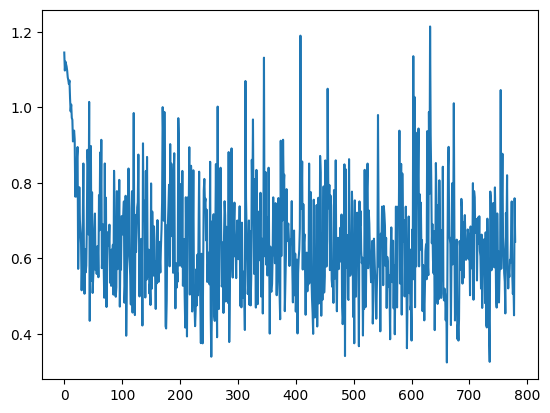

In [22]:
plt.plot(train_losses)

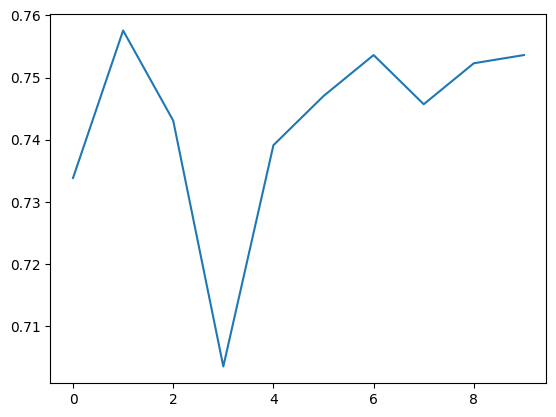

In [23]:
plt.plot(test_accuracy)

In [24]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [25]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 572/736 (0.7772)
{'acc_detail': tensor([0.8479, 0.6335, 0.8294], device='cuda:0'),
 'acc_unweighted': tensor(0.7703, device='cuda:0'),
 'acc_weighted': tensor(0.7772, device='cuda:0'),
 'f1s': tensor(0.7706, device='cuda:0'),
 'f1s_detail': tensor([0.8780, 0.6437, 0.7902], device='cuda:0'),
 'precision_detail': tensor([0.9102, 0.6542, 0.7545], device='cuda:0'),
 'recall_detail': tensor([0.8479, 0.6335, 0.8294], device='cuda:0'),
 'rocauc': tensor([0.9728, 0.8702, 0.9273], device='cuda:0'),
 'uar': tensor(0.7703, device='cuda:0'),
 'wap': tensor(0.7800, device='cuda:0')}


tensor([[223,  37,   3],
        [ 16, 140,  65],
        [  6,  37, 209]], device='cuda:0')

In [27]:
model_path = '../models_cremad3/cremad_label3_m12new_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [28]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad3/cremad_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/50 [00:00<18:35, 22.31s/it]

Train Epoch: 11 [0/2508 (0%)]	Loss: 0.967925
Mem before-during-after: 20003328 1940389888 21060096


  1%|█▍                                                                                                                                                                             | 0.41584158415841604/50 [00:11<21:47, 26.37s/it]

Train Epoch: 11 [1280/2508 (51%)]	Loss: 0.742339
Mem before-during-after: 21060096 1940281344 21060096


  2%|███▌                                                                                                                                                                            | 1.0000000000000007/50 [00:25<16:56, 20.75s/it]


Test Epoch: 11	Accuracy: 579/736 (76%)

saved model: ../models_cremad3/cremad_label3_m12new_best_11epoch.pt


  2%|███▌                                                                                                                                                                            | 1.0198019801980205/50 [00:25<17:43, 21.72s/it]

Train Epoch: 12 [0/2508 (0%)]	Loss: 0.704264
Mem before-during-after: 21056000 1941442560 21060096


  3%|████▉                                                                                                                                                                           | 1.4158415841584169/50 [00:36<22:04, 27.27s/it]

Train Epoch: 12 [1280/2508 (51%)]	Loss: 0.566800
Mem before-during-after: 21060096 1939503104 21060096


  4%|███████                                                                                                                                                                         | 2.0000000000000013/50 [00:50<15:40, 19.60s/it]


Test Epoch: 12	Accuracy: 581/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_12epoch.pt


  4%|███████▏                                                                                                                                                                         | 2.019801980198021/50 [00:50<16:43, 20.92s/it]

Train Epoch: 13 [0/2508 (0%)]	Loss: 0.783985
Mem before-during-after: 21056000 1941442560 21060096


  5%|████████▍                                                                                                                                                                       | 2.4059405940594076/50 [01:00<21:49, 27.51s/it]

Train Epoch: 13 [1280/2508 (51%)]	Loss: 0.492851
Mem before-during-after: 21060096 1940281344 21060096


  6%|██████████▌                                                                                                                                                                      | 3.000000000000002/50 [01:15<16:14, 20.73s/it]


Test Epoch: 13	Accuracy: 579/736 (76%)



  6%|██████████▋                                                                                                                                                                      | 3.009900990099012/50 [01:15<17:58, 22.96s/it]

Train Epoch: 14 [0/2508 (0%)]	Loss: 0.438624
Mem before-during-after: 21056000 1941442560 21060096


  7%|███████████▉                                                                                                                                                                    | 3.4059405940594085/50 [01:25<23:05, 29.74s/it]

Train Epoch: 14 [1280/2508 (51%)]	Loss: 0.468595
Mem before-during-after: 21060096 1940281344 21060096


  8%|██████████████▏                                                                                                                                                                  | 4.000000000000003/50 [01:39<14:48, 19.32s/it]


Test Epoch: 14	Accuracy: 581/736 (77%)



  8%|██████████████▏                                                                                                                                                                 | 4.0198019801980225/50 [01:40<15:54, 20.76s/it]

Train Epoch: 15 [0/2508 (0%)]	Loss: 0.738144
Mem before-during-after: 21056000 1941442560 21060096


  9%|███████████████▌                                                                                                                                                                 | 4.405940594059409/50 [01:50<21:20, 28.08s/it]

Train Epoch: 15 [1280/2508 (51%)]	Loss: 0.501296
Mem before-during-after: 21060096 1940281344 21060096


 10%|█████████████████▌                                                                                                                                                              | 5.0000000000000036/50 [02:04<14:34, 19.44s/it]


Test Epoch: 15	Accuracy: 578/736 (76%)



 10%|█████████████████▊                                                                                                                                                               | 5.019801980198023/50 [02:04<15:28, 20.65s/it]

Train Epoch: 16 [0/2508 (0%)]	Loss: 0.555987
Mem before-during-after: 21056000 1941442560 21060096


 11%|███████████████████▏                                                                                                                                                              | 5.40594059405941/50 [02:14<20:27, 27.53s/it]

Train Epoch: 16 [1280/2508 (51%)]	Loss: 0.541986
Mem before-during-after: 21060096 1940281344 21060096


 12%|█████████████████████▏                                                                                                                                                           | 6.000000000000004/50 [02:28<14:52, 20.28s/it]


Test Epoch: 16	Accuracy: 582/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_16epoch.pt


 12%|█████████████████████▎                                                                                                                                                           | 6.019801980198024/50 [02:29<16:09, 22.04s/it]

Train Epoch: 17 [0/2508 (0%)]	Loss: 0.644156
Mem before-during-after: 21056000 1941442560 21060096


 13%|██████████████████████▋                                                                                                                                                          | 6.415841584158421/50 [02:39<18:21, 25.28s/it]

Train Epoch: 17 [1280/2508 (51%)]	Loss: 0.643811
Mem before-during-after: 21060096 1939503104 21060096


 14%|████████████████████████▊                                                                                                                                                        | 7.000000000000005/50 [02:53<13:41, 19.11s/it]


Test Epoch: 17	Accuracy: 579/736 (76%)



 14%|████████████████████████▊                                                                                                                                                        | 7.009900990099015/50 [02:53<15:12, 21.23s/it]

Train Epoch: 18 [0/2508 (0%)]	Loss: 0.607492
Mem before-during-after: 21056000 1941442560 21060096


 15%|██████████████████████████▏                                                                                                                                                      | 7.405940594059412/50 [03:03<19:37, 27.64s/it]

Train Epoch: 18 [1280/2508 (51%)]	Loss: 0.754397
Mem before-during-after: 21060096 1938351616 21060096


 16%|████████████████████████████▎                                                                                                                                                    | 8.000000000000005/50 [03:17<13:55, 19.90s/it]


Test Epoch: 18	Accuracy: 588/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_18epoch.pt


 16%|████████████████████████████▎                                                                                                                                                    | 8.009900990099014/50 [03:18<15:16, 21.83s/it]

Train Epoch: 19 [0/2508 (0%)]	Loss: 0.510151
Mem before-during-after: 21056000 1941442560 21060096


 17%|█████████████████████████████▊                                                                                                                                                   | 8.415841584158384/50 [03:28<17:25, 25.15s/it]

Train Epoch: 19 [1280/2508 (51%)]	Loss: 0.450139
Mem before-during-after: 21060096 1940281344 21060096


 18%|███████████████████████████████▊                                                                                                                                                 | 8.999999999999917/50 [03:42<13:07, 19.21s/it]


Test Epoch: 19	Accuracy: 582/736 (77%)



 18%|███████████████████████████████▉                                                                                                                                                 | 9.019801980197935/50 [03:43<14:14, 20.85s/it]

Train Epoch: 20 [0/2508 (0%)]	Loss: 0.453713
Mem before-during-after: 21056000 1941442560 21060096


 19%|█████████████████████████████████▎                                                                                                                                               | 9.405940594059286/50 [03:53<18:25, 27.22s/it]

Train Epoch: 20 [1280/2508 (51%)]	Loss: 0.515461
Mem before-during-after: 21060096 1940281344 21060096


 20%|███████████████████████████████████▍                                                                                                                                             | 9.999999999999828/50 [04:07<13:34, 20.37s/it]


Test Epoch: 20	Accuracy: 584/736 (77%)



 20%|███████████████████████████████████▏                                                                                                                                            | 10.009900990098837/50 [04:07<14:50, 22.26s/it]

Train Epoch: 21 [0/2508 (0%)]	Loss: 0.352268
Mem before-during-after: 21056000 1941442560 21060096


 21%|████████████████████████████████████▋                                                                                                                                           | 10.405940594059198/50 [04:17<18:38, 28.25s/it]

Train Epoch: 21 [1280/2508 (51%)]	Loss: 0.627884
Mem before-during-after: 21060096 1939503104 21060096


 22%|██████████████████████████████████████▋                                                                                                                                         | 10.999999999999739/50 [04:31<12:53, 19.83s/it]


Test Epoch: 21	Accuracy: 586/736 (77%)



 22%|██████████████████████████████████████▊                                                                                                                                         | 11.009900990098748/50 [04:32<13:59, 21.52s/it]

Train Epoch: 22 [0/2508 (0%)]	Loss: 0.639618
Mem before-during-after: 21056000 1941442560 21060096


 23%|████████████████████████████████████████▏                                                                                                                                       | 11.405940594059109/50 [04:42<17:42, 27.52s/it]

Train Epoch: 22 [1280/2508 (51%)]	Loss: 0.623801
Mem before-during-after: 21060096 1940281344 21060096


 24%|██████████████████████████████████████████▍                                                                                                                                      | 11.99999999999965/50 [04:56<12:14, 19.34s/it]


Test Epoch: 22	Accuracy: 584/736 (77%)



 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.009900990098659/50 [04:57<13:24, 21.17s/it]

Train Epoch: 23 [0/2508 (0%)]	Loss: 0.342155
Mem before-during-after: 21056000 1941442560 21060096


 25%|███████████████████████████████████████████▉                                                                                                                                     | 12.40594059405902/50 [05:07<17:08, 27.37s/it]

Train Epoch: 23 [1280/2508 (51%)]	Loss: 0.518526
Mem before-during-after: 21060096 1940191232 21060096


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 12.999999999999561/50 [05:21<12:18, 19.95s/it]


Test Epoch: 23	Accuracy: 583/736 (77%)



 26%|██████████████████████████████████████████████                                                                                                                                   | 13.01980198019758/50 [05:22<12:48, 20.79s/it]

Train Epoch: 24 [0/2508 (0%)]	Loss: 0.569771
Mem before-during-after: 21056000 1941442560 21060096


 27%|███████████████████████████████████████████████▏                                                                                                                                | 13.405940594058931/50 [05:32<16:58, 27.83s/it]

Train Epoch: 24 [1280/2508 (51%)]	Loss: 0.601049
Mem before-during-after: 21060096 1940281344 21060096


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 13.999999999999472/50 [05:46<11:49, 19.71s/it]


Test Epoch: 24	Accuracy: 592/736 (78%)

saved model: ../models_cremad3/cremad_label3_m12new_best_24epoch.pt


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 14.01980198019749/50 [05:47<12:34, 20.97s/it]

Train Epoch: 25 [0/2508 (0%)]	Loss: 0.615991
Mem before-during-after: 21056000 1941442560 21060096


 29%|██████████████████████████████████████████████████▋                                                                                                                             | 14.405940594058842/50 [05:57<16:14, 27.38s/it]

Train Epoch: 25 [1280/2508 (51%)]	Loss: 0.585479
Mem before-during-after: 21060096 1940281344 21060096


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 14.999999999999384/50 [06:11<11:13, 19.24s/it]


Test Epoch: 25	Accuracy: 581/736 (77%)



 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.019801980197402/50 [06:12<12:06, 20.77s/it]

Train Epoch: 26 [0/2508 (0%)]	Loss: 0.670046
Mem before-during-after: 21056000 1941442560 21060096


 31%|██████████████████████████████████████████████████████▏                                                                                                                         | 15.405940594058753/50 [06:22<15:46, 27.36s/it]

Train Epoch: 26 [1280/2508 (51%)]	Loss: 0.382613
Mem before-during-after: 21060096 1940281344 21060096


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 15.999999999999295/50 [06:36<11:17, 19.93s/it]


Test Epoch: 26	Accuracy: 596/736 (79%)

saved model: ../models_cremad3/cremad_label3_m12new_best_26epoch.pt


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.009900990098306/50 [06:36<12:15, 21.64s/it]

Train Epoch: 27 [0/2508 (0%)]	Loss: 0.420001
Mem before-during-after: 21056000 1936254464 21060096


 33%|█████████████████████████████████████████████████████████▋                                                                                                                      | 16.405940594058666/50 [06:46<15:31, 27.74s/it]

Train Epoch: 27 [1280/2508 (51%)]	Loss: 0.546197
Mem before-during-after: 21060096 1939765248 21060096


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 16.999999999999208/50 [07:00<10:29, 19.09s/it]


Test Epoch: 27	Accuracy: 587/736 (77%)



 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.009900990098217/50 [07:01<11:31, 20.96s/it]

Train Epoch: 28 [0/2508 (0%)]	Loss: 0.456843
Mem before-during-after: 21056000 1941442560 21060096


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                  | 17.405940594058578/50 [07:11<15:35, 28.70s/it]

Train Epoch: 28 [1280/2508 (51%)]	Loss: 0.542243
Mem before-during-after: 21060096 1940281344 21060096


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 17.99999999999912/50 [07:25<10:25, 19.55s/it]


Test Epoch: 28	Accuracy: 598/736 (79%)

saved model: ../models_cremad3/cremad_label3_m12new_best_28epoch.pt


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.019801980197137/50 [07:26<11:14, 21.10s/it]

Train Epoch: 29 [0/2508 (0%)]	Loss: 0.455695
Mem before-during-after: 21056000 1941442560 21060096


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 18.40594059405849/50 [07:36<14:36, 27.75s/it]

Train Epoch: 29 [1280/2508 (51%)]	Loss: 0.875559
Mem before-during-after: 21060096 1940281344 21060096


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 18.99999999999903/50 [07:50<10:05, 19.54s/it]


Test Epoch: 29	Accuracy: 590/736 (78%)



 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 19.019801980197048/50 [07:51<10:53, 21.08s/it]

Train Epoch: 30 [0/2508 (0%)]	Loss: 0.643866
Mem before-during-after: 21056000 1941442560 21060096


 39%|█████████████████████████████████████████████████████████████████████                                                                                                             | 19.4059405940584/50 [08:01<14:53, 29.19s/it]

Train Epoch: 30 [1280/2508 (51%)]	Loss: 0.430609
Mem before-during-after: 21060096 1940281344 21060096


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 19.99999999999894/50 [08:15<09:35, 19.18s/it]


Test Epoch: 30	Accuracy: 598/736 (79%)



 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.01980198019696/50 [08:16<10:26, 20.91s/it]

Train Epoch: 31 [0/2508 (0%)]	Loss: 0.606744
Mem before-during-after: 21056000 1941442560 21060096


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 20.40594059405831/50 [08:26<15:09, 30.73s/it]

Train Epoch: 31 [1280/2508 (51%)]	Loss: 0.456326
Mem before-during-after: 21060096 1940281344 21060096


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 20.999999999998852/50 [08:40<09:21, 19.37s/it]


Test Epoch: 31	Accuracy: 591/736 (78%)



 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 21.00990099009786/50 [08:40<10:26, 21.61s/it]

Train Epoch: 32 [0/2508 (0%)]	Loss: 0.531876
Mem before-during-after: 21056000 1941442560 21060096


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                    | 21.405940594058222/50 [08:50<12:52, 27.03s/it]

Train Epoch: 32 [1280/2508 (51%)]	Loss: 0.499696
Mem before-during-after: 21060096 1940281344 21060096


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 21.999999999998764/50 [09:04<08:49, 18.90s/it]


Test Epoch: 32	Accuracy: 588/736 (77%)



 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 22.01980198019678/50 [09:05<09:41, 20.78s/it]

Train Epoch: 33 [0/2508 (0%)]	Loss: 0.511493
Mem before-during-after: 21056000 1941442560 21060096


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 22.405940594058134/50 [09:15<12:49, 27.90s/it]

Train Epoch: 33 [1280/2508 (51%)]	Loss: 0.519942
Mem before-during-after: 21060096 1940281344 21060096


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 22.999999999998675/50 [09:29<08:46, 19.51s/it]


Test Epoch: 33	Accuracy: 595/736 (78%)



 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                               | 23.019801980196693/50 [09:29<09:13, 20.51s/it]

Train Epoch: 34 [0/2508 (0%)]	Loss: 0.507361
Mem before-during-after: 21056000 1936254464 21060096


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 23.405940594058045/50 [09:39<12:03, 27.22s/it]

Train Epoch: 34 [1280/2508 (51%)]	Loss: 0.551797
Mem before-during-after: 21060096 1939765248 21060096


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 23.999999999998586/50 [09:53<08:32, 19.70s/it]


Test Epoch: 34	Accuracy: 588/736 (77%)



 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 24.019801980196604/50 [09:54<09:04, 20.95s/it]

Train Epoch: 35 [0/2508 (0%)]	Loss: 0.694638
Mem before-during-after: 21056000 1941442560 21060096


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 24.405940594057956/50 [10:04<12:30, 29.32s/it]

Train Epoch: 35 [1280/2508 (51%)]	Loss: 0.343827
Mem before-during-after: 21060096 1939503104 21060096


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 24.999999999998497/50 [10:18<08:06, 19.46s/it]


Test Epoch: 35	Accuracy: 560/736 (74%)



 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.019801980196515/50 [10:18<08:56, 21.48s/it]

Train Epoch: 36 [0/2508 (0%)]	Loss: 0.677446
Mem before-during-after: 21056000 1941442560 21060096


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 25.405940594057867/50 [10:29<11:57, 29.18s/it]

Train Epoch: 36 [1280/2508 (51%)]	Loss: 0.540364
Mem before-during-after: 21060096 1939503104 21060096


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 25.99999999999841/50 [10:43<07:35, 18.98s/it]


Test Epoch: 36	Accuracy: 576/736 (76%)



 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.019801980196426/50 [10:43<08:19, 20.84s/it]

Train Epoch: 37 [0/2508 (0%)]	Loss: 0.443275
Mem before-during-after: 21056000 1941442560 21060096


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26.40594059405778/50 [10:53<10:44, 27.33s/it]

Train Epoch: 37 [1280/2508 (51%)]	Loss: 0.610449
Mem before-during-after: 21060096 1940281344 21060096


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 26.99999999999832/50 [11:07<07:13, 18.87s/it]


Test Epoch: 37	Accuracy: 588/736 (77%)



 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 27.00990099009733/50 [11:08<08:05, 21.13s/it]

Train Epoch: 38 [0/2508 (0%)]	Loss: 0.632808
Mem before-during-after: 21056000 1941442560 21060096


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 27.40594059405769/50 [11:18<10:25, 27.69s/it]

Train Epoch: 38 [1280/2508 (51%)]	Loss: 0.618044
Mem before-during-after: 21060096 1940281344 21060096


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 27.99999999999823/50 [11:32<07:07, 19.45s/it]


Test Epoch: 38	Accuracy: 580/736 (76%)



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 28.00990099009724/50 [11:33<07:56, 21.66s/it]

Train Epoch: 39 [0/2508 (0%)]	Loss: 0.448962
Mem before-during-after: 21056000 1941442560 21060096


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 28.4059405940576/50 [11:43<10:04, 27.98s/it]

Train Epoch: 39 [1280/2508 (51%)]	Loss: 0.744586
Mem before-during-after: 21060096 1940281344 21060096


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 28.999999999998142/50 [11:58<07:10, 20.51s/it]


Test Epoch: 39	Accuracy: 590/736 (78%)



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 29.01980198019616/50 [11:58<07:31, 21.50s/it]

Train Epoch: 40 [0/2508 (0%)]	Loss: 0.676621
Mem before-during-after: 21056000 1941442560 21060096


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 29.405940594057512/50 [12:09<09:27, 27.57s/it]

Train Epoch: 40 [1280/2508 (51%)]	Loss: 0.597314
Mem before-during-after: 21060096 1940281344 21060096


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 29.999999999998053/50 [12:23<06:24, 19.25s/it]


Test Epoch: 40	Accuracy: 587/736 (77%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 30.01980198019607/50 [12:23<06:56, 20.86s/it]

Train Epoch: 41 [0/2508 (0%)]	Loss: 0.771528
Mem before-during-after: 21056000 1941442560 21060096


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 30.405940594057423/50 [12:33<08:59, 27.51s/it]

Train Epoch: 41 [1280/2508 (51%)]	Loss: 0.575098
Mem before-during-after: 21060096 1939503104 21060096


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 30.999999999997964/50 [12:47<05:55, 18.74s/it]


Test Epoch: 41	Accuracy: 571/736 (75%)



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 31.019801980195982/50 [12:47<06:31, 20.63s/it]

Train Epoch: 42 [0/2508 (0%)]	Loss: 0.313831
Mem before-during-after: 21056000 1941442560 21060096


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31.405940594057334/50 [12:58<08:35, 27.73s/it]

Train Epoch: 42 [1280/2508 (51%)]	Loss: 0.667098
Mem before-during-after: 21060096 1940281344 21060096


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 31.999999999997875/50 [13:12<06:06, 20.37s/it]


Test Epoch: 42	Accuracy: 598/736 (79%)



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 32.0198019801959/50 [13:13<06:22, 21.29s/it]

Train Epoch: 43 [0/2508 (0%)]	Loss: 0.501622
Mem before-during-after: 21056000 1941442560 21060096


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 32.40594059405739/50 [13:23<08:16, 28.19s/it]

Train Epoch: 43 [1280/2508 (51%)]	Loss: 0.522634
Mem before-during-after: 21060096 1940281344 21060096


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 32.999999999998145/50 [13:37<05:38, 19.91s/it]


Test Epoch: 43	Accuracy: 595/736 (78%)



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 33.01980198019617/50 [13:37<06:08, 21.71s/it]

Train Epoch: 44 [0/2508 (0%)]	Loss: 0.567857
Mem before-during-after: 21056000 1941442560 21060096


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 33.40594059405766/50 [13:48<07:40, 27.77s/it]

Train Epoch: 44 [1280/2508 (51%)]	Loss: 0.466336
Mem before-during-after: 21060096 1940281344 21060096


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 33.999999999998415/50 [14:02<05:14, 19.64s/it]


Test Epoch: 44	Accuracy: 592/736 (78%)



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.01980198019644/50 [14:02<05:36, 21.03s/it]

Train Epoch: 45 [0/2508 (0%)]	Loss: 0.360945
Mem before-during-after: 21056000 1941442560 21060096


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 34.40594059405793/50 [14:12<07:12, 27.76s/it]

Train Epoch: 45 [1280/2508 (51%)]	Loss: 0.438139
Mem before-during-after: 21060096 1939503104 21060096


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 34.999999999998685/50 [14:26<05:27, 21.84s/it]


Test Epoch: 45	Accuracy: 594/736 (78%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 35.0099009900977/50 [14:27<05:45, 23.02s/it]

Train Epoch: 46 [0/2508 (0%)]	Loss: 0.461787
Mem before-during-after: 21056000 1941442560 21060096


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 35.4059405940582/50 [14:37<06:37, 27.22s/it]

Train Epoch: 46 [1280/2508 (51%)]	Loss: 0.437588
Mem before-during-after: 21060096 1940191232 21060096


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 35.999999999998956/50 [14:51<04:45, 20.37s/it]


Test Epoch: 46	Accuracy: 596/736 (79%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 36.01980198019698/50 [14:51<04:51, 20.83s/it]

Train Epoch: 47 [0/2508 (0%)]	Loss: 0.552199
Mem before-during-after: 21056000 1941442560 21060096


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 36.40594059405847/50 [15:01<06:08, 27.14s/it]

Train Epoch: 47 [1280/2508 (51%)]	Loss: 0.565945
Mem before-during-after: 21060096 1940281344 21060096


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 36.999999999999226/50 [15:15<04:19, 19.98s/it]


Test Epoch: 47	Accuracy: 599/736 (79%)

saved model: ../models_cremad3/cremad_label3_m12new_best_47epoch.pt


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 37.01980198019725/50 [15:16<04:35, 21.22s/it]

Train Epoch: 48 [0/2508 (0%)]	Loss: 0.386920
Mem before-during-after: 21056000 1941442560 21060096


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 37.40594059405874/50 [15:26<05:52, 27.99s/it]

Train Epoch: 48 [1280/2508 (51%)]	Loss: 0.583836
Mem before-during-after: 21060096 1939503104 21060096


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 37.999999999999496/50 [15:40<04:02, 20.23s/it]


Test Epoch: 48	Accuracy: 593/736 (78%)



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.01980198019752/50 [15:40<04:11, 21.02s/it]

Train Epoch: 49 [0/2508 (0%)]	Loss: 0.504085
Mem before-during-after: 21056000 1941442560 21060096


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 38.40594059405901/50 [15:50<05:09, 26.67s/it]

Train Epoch: 49 [1280/2508 (51%)]	Loss: 0.463395
Mem before-during-after: 21060096 1940281344 21060096


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 38.999999999999766/50 [16:04<03:33, 19.38s/it]


Test Epoch: 49	Accuracy: 587/736 (77%)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.00990099009878/50 [16:04<03:58, 21.73s/it]

Train Epoch: 50 [0/2508 (0%)]	Loss: 0.308044
Mem before-during-after: 21056000 1941442560 21060096


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 39.40594059405928/50 [16:15<04:54, 27.80s/it]

Train Epoch: 50 [1280/2508 (51%)]	Loss: 0.495577
Mem before-during-after: 21060096 1940281344 21060096


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 40.000000000000036/50 [16:28<03:19, 19.99s/it]


Test Epoch: 50	Accuracy: 586/736 (77%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.01980198019806/50 [16:29<03:29, 20.98s/it]

Train Epoch: 51 [0/2508 (0%)]	Loss: 0.617582
Mem before-during-after: 21056000 1936254464 21060096


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 40.40594059405955/50 [16:39<04:29, 28.04s/it]

Train Epoch: 51 [1280/2508 (51%)]	Loss: 0.563241
Mem before-during-after: 21060096 1939765248 21060096


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 41.000000000000306/50 [16:53<02:59, 19.99s/it]


Test Epoch: 51	Accuracy: 580/736 (76%)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00990099009932/50 [16:54<03:18, 22.03s/it]

Train Epoch: 52 [0/2508 (0%)]	Loss: 0.708606
Mem before-during-after: 21056000 1941442560 21060096


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 41.40594059405982/50 [17:04<03:56, 27.56s/it]

Train Epoch: 52 [1280/2508 (51%)]	Loss: 0.511496
Mem before-during-after: 21060096 1940281344 21060096


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 42.000000000000576/50 [17:18<02:34, 19.36s/it]


Test Epoch: 52	Accuracy: 573/736 (75%)



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 42.0198019801986/50 [17:18<02:46, 20.84s/it]

Train Epoch: 53 [0/2508 (0%)]	Loss: 0.545610
Mem before-during-after: 21056000 1941442560 21060096


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 42.40594059406009/50 [17:28<03:27, 27.37s/it]

Train Epoch: 53 [1280/2508 (51%)]	Loss: 0.744595
Mem before-during-after: 21060096 1940281344 21060096


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.000000000000846/50 [17:43<02:18, 19.81s/it]


Test Epoch: 53	Accuracy: 593/736 (78%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.00990099009986/50 [17:43<02:32, 21.82s/it]

Train Epoch: 54 [0/2508 (0%)]	Loss: 0.504597
Mem before-during-after: 21056000 1941442560 21060096


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 43.40594059406036/50 [17:53<03:06, 28.34s/it]

Train Epoch: 54 [1280/2508 (51%)]	Loss: 0.455887
Mem before-during-after: 21060096 1940281344 21060096


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 44.000000000001116/50 [18:07<01:58, 19.68s/it]


Test Epoch: 54	Accuracy: 591/736 (78%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.01980198019914/50 [18:08<02:05, 20.93s/it]

Train Epoch: 55 [0/2508 (0%)]	Loss: 0.511945
Mem before-during-after: 21056000 1941442560 21060096


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 44.40594059406063/50 [18:18<02:32, 27.28s/it]

Train Epoch: 55 [1280/2508 (51%)]	Loss: 0.477985
Mem before-during-after: 21060096 1940281344 21060096


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 45.000000000001386/50 [18:31<01:37, 19.40s/it]


Test Epoch: 55	Accuracy: 593/736 (78%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 45.01980198019941/50 [18:32<01:43, 20.88s/it]

Train Epoch: 56 [0/2508 (0%)]	Loss: 0.299437
Mem before-during-after: 21056000 1941442560 21060096


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 45.4059405940609/50 [18:42<02:06, 27.48s/it]

Train Epoch: 56 [1280/2508 (51%)]	Loss: 0.548434
Mem before-during-after: 21060096 1940281344 21060096


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.000000000001656/50 [18:56<01:18, 19.55s/it]


Test Epoch: 56	Accuracy: 607/736 (80%)

saved model: ../models_cremad3/cremad_label3_m12new_best_56epoch.pt


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.01980198019968/50 [18:57<01:22, 20.79s/it]

Train Epoch: 57 [0/2508 (0%)]	Loss: 0.355096
Mem before-during-after: 21056000 1941442560 21060096


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 46.40594059406117/50 [19:07<01:38, 27.51s/it]

Train Epoch: 57 [1280/2508 (51%)]	Loss: 0.584555
Mem before-during-after: 21060096 1940191232 21060096


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.000000000001926/50 [19:21<00:59, 19.76s/it]


Test Epoch: 57	Accuracy: 580/736 (76%)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.01980198019995/50 [19:21<01:01, 20.73s/it]

Train Epoch: 58 [0/2508 (0%)]	Loss: 0.762256
Mem before-during-after: 21056000 1941442560 21060096


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47.40594059406144/50 [19:31<01:12, 27.90s/it]

Train Epoch: 58 [1280/2508 (51%)]	Loss: 0.387111
Mem before-during-after: 21060096 1940281344 21060096


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.000000000002196/50 [19:46<00:39, 19.52s/it]


Test Epoch: 58	Accuracy: 601/736 (79%)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.01980198020022/50 [19:46<00:41, 20.85s/it]

Train Epoch: 59 [0/2508 (0%)]	Loss: 0.456676
Mem before-during-after: 21056000 1941442560 21060096


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 48.40594059406171/50 [19:57<00:44, 28.23s/it]

Train Epoch: 59 [1280/2508 (51%)]	Loss: 0.234947
Mem before-during-after: 21060096 1939503104 21060096


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.000000000002466/50 [20:11<00:19, 19.60s/it]


Test Epoch: 59	Accuracy: 586/736 (77%)



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49.01980198020049/50 [20:11<00:20, 21.01s/it]

Train Epoch: 60 [0/2508 (0%)]	Loss: 0.423119
Mem before-during-after: 21056000 1941442560 21060096


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.40594059406198/50 [20:21<00:16, 27.59s/it]

Train Epoch: 60 [1280/2508 (51%)]	Loss: 0.595399
Mem before-during-after: 21060096 1940281344 21060096


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99009900990372/50 [20:35<00:00, 19.80s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.000000000002736/50 [20:35<00:00, 24.72s/it]


Test Epoch: 60	Accuracy: 593/736 (78%)



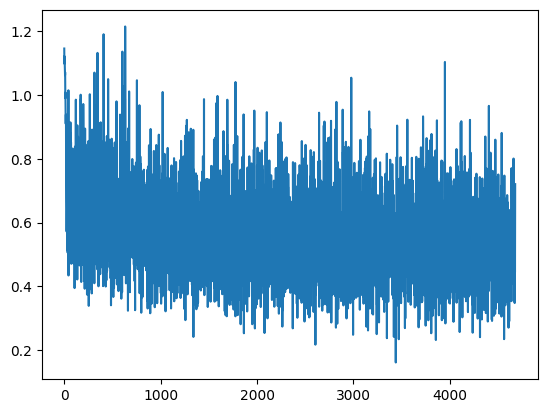

In [29]:
plt.plot(train_losses)

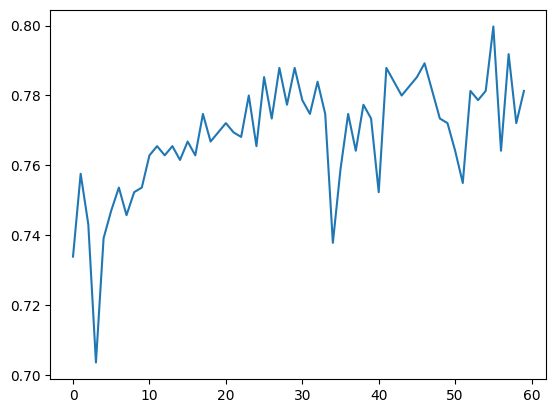

In [30]:
plt.plot(test_accuracy)

In [31]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 593/736 (0.8057)
{'acc_detail': tensor([0.8897, 0.7919, 0.7302], device='cuda:0'),
 'acc_unweighted': tensor(0.8039, device='cuda:0'),
 'acc_weighted': tensor(0.8057, device='cuda:0'),
 'f1s': tensor(0.8034, device='cuda:0'),
 'f1s_detail': tensor([0.8948, 0.7187, 0.7965], device='cuda:0'),
 'precision_detail': tensor([0.9000, 0.6579, 0.8762], device='cuda:0'),
 'recall_detail': tensor([0.8897, 0.7919, 0.7302], device='cuda:0'),
 'rocauc': tensor([0.9769, 0.9041, 0.9440], device='cuda:0'),
 'uar': tensor(0.8039, device='cuda:0'),
 'wap': tensor(0.8192, device='cuda:0')}


tensor([[234,  28,   1],
        [ 21, 175,  25],
        [  5,  63, 184]], device='cuda:0')

In [32]:
best_epoch = 56
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 607/736 (0.8247)
{'acc_detail': tensor([0.9049, 0.7330, 0.8214], device='cuda:0'),
 'acc_unweighted': tensor(0.8198, device='cuda:0'),
 'acc_weighted': tensor(0.8247, device='cuda:0'),
 'f1s': tensor(0.8197, device='cuda:0'),
 'f1s_detail': tensor([0.8964, 0.7281, 0.8347], device='cuda:0'),
 'precision_detail': tensor([0.8881, 0.7232, 0.8484], device='cuda:0'),
 'recall_detail': tensor([0.9049, 0.7330, 0.8214], device='cuda:0'),
 'rocauc': tensor([0.9771, 0.9029, 0.9421], device='cuda:0'),
 'uar': tensor(0.8198, device='cuda:0'),
 'wap': tensor(0.8250, device='cuda:0')}


tensor([[238,  23,   2],
        [ 24, 162,  35],
        [  6,  39, 207]], device='cuda:0')

In [33]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 440
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                           | 0.009900990099009901/440 [00:00<3:10:41, 26.00s/it]

Train Epoch: 61 [0/2508 (0%)]	Loss: 0.434723
Mem before-during-after: 21754880 1942141440 22811136


  0%|▏                                                                                                                                                                           | 0.40594059405940613/440 [00:10<3:29:09, 28.55s/it]

Train Epoch: 61 [1280/2508 (51%)]	Loss: 0.582526
Mem before-during-after: 22811136 1941254144 22811136


  0%|▍                                                                                                                                                                            | 1.0000000000000007/440 [00:24<2:24:01, 19.68s/it]


Test Epoch: 61	Accuracy: 596/736 (79%)



  0%|▍                                                                                                                                                                            | 1.0198019801980205/440 [00:25<2:38:45, 21.70s/it]

Train Epoch: 62 [0/2508 (0%)]	Loss: 0.496696
Mem before-during-after: 22807040 1943193600 22811136


  0%|▌                                                                                                                                                                             | 1.405940594059407/440 [00:35<3:20:36, 27.44s/it]

Train Epoch: 62 [1280/2508 (51%)]	Loss: 0.536091
Mem before-during-after: 22811136 1942032384 22811136


  0%|▊                                                                                                                                                                            | 2.0000000000000013/440 [00:49<2:31:17, 20.73s/it]


Test Epoch: 62	Accuracy: 606/736 (80%)



  0%|▊                                                                                                                                                                             | 2.019801980198021/440 [00:50<2:37:58, 21.64s/it]

Train Epoch: 63 [0/2508 (0%)]	Loss: 0.425441
Mem before-during-after: 22807040 1943193600 22811136


  1%|▉                                                                                                                                                                            | 2.4059405940594076/440 [01:00<3:25:36, 28.19s/it]

Train Epoch: 63 [1280/2508 (51%)]	Loss: 0.674731
Mem before-during-after: 22811136 1942032384 22811136


  1%|█▏                                                                                                                                                                            | 3.000000000000002/440 [01:15<2:36:21, 21.47s/it]


Test Epoch: 63	Accuracy: 584/736 (77%)



  1%|█▏                                                                                                                                                                            | 3.019801980198022/440 [01:15<2:37:28, 21.62s/it]

Train Epoch: 64 [0/2508 (0%)]	Loss: 0.442073
Mem before-during-after: 22807040 1943193600 22811136


  1%|█▎                                                                                                                                                                           | 3.4059405940594085/440 [01:25<3:26:28, 28.38s/it]

Train Epoch: 64 [1280/2508 (51%)]	Loss: 0.458862
Mem before-during-after: 22811136 1942032384 22811136


  1%|█▌                                                                                                                                                                            | 4.000000000000003/440 [01:40<2:25:39, 20.05s/it]


Test Epoch: 64	Accuracy: 568/736 (75%)



  1%|█▌                                                                                                                                                                            | 4.009900990099013/440 [01:40<2:38:07, 21.76s/it]

Train Epoch: 65 [0/2508 (0%)]	Loss: 0.390502
Mem before-during-after: 22807040 1943193600 22811136


  1%|█▋                                                                                                                                                                            | 4.405940594059409/440 [01:50<3:19:39, 27.50s/it]

Train Epoch: 65 [1280/2508 (51%)]	Loss: 0.511165
Mem before-during-after: 22811136 1942032384 22811136


  1%|█▉                                                                                                                                                                           | 5.0000000000000036/440 [02:05<2:24:15, 19.90s/it]


Test Epoch: 65	Accuracy: 591/736 (78%)



  1%|█▉                                                                                                                                                                            | 5.019801980198023/440 [02:05<2:36:38, 21.61s/it]

Train Epoch: 66 [0/2508 (0%)]	Loss: 0.569011
Mem before-during-after: 22807040 1943193600 22811136


  1%|██▏                                                                                                                                                                            | 5.40594059405941/440 [02:16<3:24:49, 28.28s/it]

Train Epoch: 66 [1280/2508 (51%)]	Loss: 0.402471
Mem before-during-after: 22811136 1942032384 22811136


  1%|██▎                                                                                                                                                                           | 6.000000000000004/440 [02:30<2:24:46, 20.02s/it]


Test Epoch: 66	Accuracy: 587/736 (77%)



  1%|██▍                                                                                                                                                                           | 6.019801980198024/440 [02:30<2:36:50, 21.68s/it]

Train Epoch: 67 [0/2508 (0%)]	Loss: 0.703362
Mem before-during-after: 22807040 1943193600 22811136


  1%|██▌                                                                                                                                                                           | 6.405940594059411/440 [02:40<3:25:20, 28.41s/it]

Train Epoch: 67 [1280/2508 (51%)]	Loss: 0.587296
Mem before-during-after: 22811136 1942032384 22811136


  2%|██▊                                                                                                                                                                           | 7.000000000000005/440 [02:55<2:24:26, 20.01s/it]


Test Epoch: 67	Accuracy: 591/736 (78%)



  2%|██▊                                                                                                                                                                           | 7.019801980198025/440 [02:55<2:33:36, 21.29s/it]

Train Epoch: 68 [0/2508 (0%)]	Loss: 0.354412
Mem before-during-after: 22807040 1943193600 22811136


  2%|██▉                                                                                                                                                                           | 7.405940594059412/440 [03:05<3:19:46, 27.71s/it]

Train Epoch: 68 [1280/2508 (51%)]	Loss: 0.543546
Mem before-during-after: 22811136 1942032384 22811136


  2%|███▏                                                                                                                                                                          | 8.000000000000005/440 [03:20<2:26:11, 20.30s/it]


Test Epoch: 68	Accuracy: 579/736 (76%)



  2%|███▏                                                                                                                                                                          | 8.019801980198023/440 [03:20<2:35:03, 21.54s/it]

Train Epoch: 69 [0/2508 (0%)]	Loss: 0.510915
Mem before-during-after: 22807040 1943193600 22811136


  2%|███▎                                                                                                                                                                          | 8.405940594059375/440 [03:30<3:22:35, 28.16s/it]

Train Epoch: 69 [1280/2508 (51%)]	Loss: 0.468095
Mem before-during-after: 22811136 1942032384 22811136


  2%|███▌                                                                                                                                                                          | 8.999999999999917/440 [03:45<2:19:48, 19.46s/it]


Test Epoch: 69	Accuracy: 581/736 (77%)



  2%|███▌                                                                                                                                                                          | 9.019801980197935/440 [03:45<2:32:29, 21.23s/it]

Train Epoch: 70 [0/2508 (0%)]	Loss: 0.472492
Mem before-during-after: 22807040 1943193600 22811136


  2%|███▋                                                                                                                                                                          | 9.405940594059286/440 [03:55<3:20:19, 27.91s/it]

Train Epoch: 70 [1280/2508 (51%)]	Loss: 0.818349
Mem before-during-after: 22811136 1942032384 22811136


  2%|███▉                                                                                                                                                                          | 9.999999999999828/440 [04:09<2:17:34, 19.20s/it]


Test Epoch: 70	Accuracy: 594/736 (78%)



  2%|███▉                                                                                                                                                                         | 10.009900990098837/440 [04:10<2:33:33, 21.43s/it]

Train Epoch: 71 [0/2508 (0%)]	Loss: 0.444011
Mem before-during-after: 22807040 1943193600 22811136


  2%|████                                                                                                                                                                         | 10.405940594059198/440 [04:20<3:20:31, 28.01s/it]

Train Epoch: 71 [1280/2508 (51%)]	Loss: 0.841040
Mem before-during-after: 22811136 1942032384 22811136


  2%|████▎                                                                                                                                                                        | 10.999999999999739/440 [04:34<2:25:05, 20.29s/it]


Test Epoch: 71	Accuracy: 601/736 (79%)



  3%|████▎                                                                                                                                                                        | 11.019801980197757/440 [04:35<2:31:17, 21.16s/it]

Train Epoch: 72 [0/2508 (0%)]	Loss: 0.590224
Mem before-during-after: 22807040 1943193600 22811136


  3%|████▍                                                                                                                                                                        | 11.405940594059109/440 [04:45<3:19:04, 27.87s/it]

Train Epoch: 72 [1280/2508 (51%)]	Loss: 0.554263
Mem before-during-after: 22811136 1941254144 22811136


  3%|████▋                                                                                                                                                                         | 11.99999999999965/440 [04:59<2:21:21, 19.82s/it]


Test Epoch: 72	Accuracy: 586/736 (77%)



  3%|████▋                                                                                                                                                                        | 12.019801980197668/440 [05:00<2:29:42, 20.99s/it]

Train Epoch: 73 [0/2508 (0%)]	Loss: 0.733393
Mem before-during-after: 22807040 1943193600 22811136


  3%|████▉                                                                                                                                                                         | 12.40594059405902/440 [05:10<3:27:19, 29.09s/it]

Train Epoch: 73 [1280/2508 (51%)]	Loss: 0.534575
Mem before-during-after: 22811136 1942032384 22811136


  3%|█████                                                                                                                                                                        | 12.999999999999561/440 [05:25<2:26:01, 20.52s/it]


Test Epoch: 73	Accuracy: 602/736 (79%)



  3%|█████▏                                                                                                                                                                        | 13.01980198019758/440 [05:25<2:33:34, 21.58s/it]

Train Epoch: 74 [0/2508 (0%)]	Loss: 0.455664
Mem before-during-after: 22807040 1943193600 22811136


  3%|█████▎                                                                                                                                                                       | 13.405940594058931/440 [05:35<3:17:14, 27.74s/it]

Train Epoch: 74 [1280/2508 (51%)]	Loss: 0.733052
Mem before-during-after: 22811136 1942032384 22811136


  3%|█████▌                                                                                                                                                                       | 13.999999999999472/440 [05:50<2:20:58, 19.86s/it]


Test Epoch: 74	Accuracy: 596/736 (79%)



  3%|█████▌                                                                                                                                                                        | 14.01980198019749/440 [05:50<2:29:13, 21.02s/it]

Train Epoch: 75 [0/2508 (0%)]	Loss: 0.552095
Mem before-during-after: 22807040 1943193600 22811136


  3%|█████▋                                                                                                                                                                       | 14.405940594058842/440 [06:00<3:19:08, 28.07s/it]

Train Epoch: 75 [1280/2508 (51%)]	Loss: 0.475070
Mem before-during-after: 22811136 1942032384 22811136


  3%|█████▉                                                                                                                                                                       | 14.999999999999384/440 [06:14<2:22:12, 20.08s/it]


Test Epoch: 75	Accuracy: 605/736 (80%)



  3%|█████▉                                                                                                                                                                       | 15.009900990098393/440 [06:15<2:36:04, 22.03s/it]

Train Epoch: 76 [0/2508 (0%)]	Loss: 0.656314
Mem before-during-after: 22807040 1943193600 22811136


  4%|██████                                                                                                                                                                       | 15.405940594058753/440 [06:25<3:23:51, 28.81s/it]

Train Epoch: 76 [1280/2508 (51%)]	Loss: 0.515549
Mem before-during-after: 22811136 1942032384 22811136


  4%|██████▎                                                                                                                                                                      | 15.999999999999295/440 [06:40<2:20:16, 19.85s/it]


Test Epoch: 76	Accuracy: 587/736 (77%)



  4%|██████▎                                                                                                                                                                      | 16.019801980197315/440 [06:40<2:32:17, 21.55s/it]

Train Epoch: 77 [0/2508 (0%)]	Loss: 0.749567
Mem before-during-after: 22807040 1943193600 22811136


  4%|██████▍                                                                                                                                                                      | 16.405940594058666/440 [06:51<3:21:41, 28.57s/it]

Train Epoch: 77 [1280/2508 (51%)]	Loss: 0.496707
Mem before-during-after: 22811136 1942032384 22811136


  4%|██████▋                                                                                                                                                                      | 16.999999999999208/440 [07:05<2:16:55, 19.42s/it]


Test Epoch: 77	Accuracy: 587/736 (77%)



  4%|██████▋                                                                                                                                                                      | 17.009900990098217/440 [07:05<2:31:38, 21.51s/it]

Train Epoch: 78 [0/2508 (0%)]	Loss: 0.757445
Mem before-during-after: 22807040 1943193600 22811136


  4%|██████▊                                                                                                                                                                      | 17.405940594058578/440 [07:16<3:14:24, 27.60s/it]

Train Epoch: 78 [1280/2508 (51%)]	Loss: 0.926614
Mem before-during-after: 22811136 1942032384 22811136


  4%|███████                                                                                                                                                                       | 17.99999999999912/440 [07:30<2:32:20, 21.66s/it]


Test Epoch: 78	Accuracy: 593/736 (78%)



  4%|███████                                                                                                                                                                      | 18.009900990098128/440 [07:30<2:40:07, 22.77s/it]

Train Epoch: 79 [0/2508 (0%)]	Loss: 0.700819
Mem before-during-after: 22807040 1943193600 22811136


  4%|███████▎                                                                                                                                                                      | 18.40594059405849/440 [07:41<3:15:20, 27.80s/it]

Train Epoch: 79 [1280/2508 (51%)]	Loss: 0.500157
Mem before-during-after: 22811136 1941254144 22811136


  4%|███████▌                                                                                                                                                                      | 18.99999999999903/440 [07:55<2:18:06, 19.68s/it]


Test Epoch: 79	Accuracy: 594/736 (78%)



  4%|███████▌                                                                                                                                                                      | 19.00990099009804/440 [07:55<2:30:08, 21.40s/it]

Train Epoch: 80 [0/2508 (0%)]	Loss: 0.638573
Mem before-during-after: 22807040 1943193600 22811136


  4%|███████▋                                                                                                                                                                       | 19.4059405940584/440 [08:05<3:12:57, 27.53s/it]

Train Epoch: 80 [1280/2508 (51%)]	Loss: 0.467376
Mem before-during-after: 22811136 1942032384 22811136


  5%|███████▉                                                                                                                                                                      | 19.99999999999894/440 [08:20<2:19:42, 19.96s/it]


Test Epoch: 80	Accuracy: 579/736 (76%)



  5%|███████▉                                                                                                                                                                      | 20.01980198019696/440 [08:20<2:32:27, 21.78s/it]

Train Epoch: 81 [0/2508 (0%)]	Loss: 1.037330
Mem before-during-after: 22807040 1943193600 22811136


  5%|████████                                                                                                                                                                      | 20.40594059405831/440 [08:30<3:11:17, 27.35s/it]

Train Epoch: 81 [1280/2508 (51%)]	Loss: 0.595484
Mem before-during-after: 22811136 1942032384 22811136


  5%|████████▎                                                                                                                                                                    | 20.999999999998852/440 [08:44<2:20:06, 20.06s/it]


Test Epoch: 81	Accuracy: 602/736 (79%)



  5%|████████▎                                                                                                                                                                     | 21.01980198019687/440 [08:45<2:26:54, 21.04s/it]

Train Epoch: 82 [0/2508 (0%)]	Loss: 0.432284
Mem before-during-after: 22807040 1943193600 22811136


  5%|████████▍                                                                                                                                                                    | 21.405940594058222/440 [08:55<3:20:10, 28.69s/it]

Train Epoch: 82 [1280/2508 (51%)]	Loss: 0.382877
Mem before-during-after: 22811136 1942032384 22811136


  5%|████████▋                                                                                                                                                                    | 21.999999999998764/440 [09:09<2:17:53, 19.79s/it]


Test Epoch: 82	Accuracy: 583/736 (77%)



  5%|████████▋                                                                                                                                                                     | 22.01980198019678/440 [09:09<2:28:31, 21.32s/it]

Train Epoch: 83 [0/2508 (0%)]	Loss: 0.691286
Mem before-during-after: 22807040 1943193600 22811136


  5%|████████▊                                                                                                                                                                    | 22.405940594058134/440 [09:19<3:11:44, 27.55s/it]

Train Epoch: 83 [1280/2508 (51%)]	Loss: 0.571183
Mem before-during-after: 22811136 1942032384 22811136


  5%|█████████                                                                                                                                                                    | 22.999999999998675/440 [09:34<2:16:35, 19.65s/it]


Test Epoch: 83	Accuracy: 601/736 (79%)



  5%|█████████                                                                                                                                                                    | 23.019801980196693/440 [09:34<2:26:32, 21.09s/it]

Train Epoch: 84 [0/2508 (0%)]	Loss: 0.531208
Mem before-during-after: 22807040 1943193600 22811136


  5%|█████████▏                                                                                                                                                                   | 23.405940594058045/440 [09:44<3:13:22, 27.85s/it]

Train Epoch: 84 [1280/2508 (51%)]	Loss: 0.488677
Mem before-during-after: 22811136 1942032384 22811136


  5%|█████████▍                                                                                                                                                                   | 23.999999999998586/440 [09:58<2:17:43, 19.86s/it]


Test Epoch: 84	Accuracy: 591/736 (78%)



  5%|█████████▍                                                                                                                                                                   | 24.019801980196604/440 [09:59<2:29:37, 21.58s/it]

Train Epoch: 85 [0/2508 (0%)]	Loss: 0.380922
Mem before-during-after: 22807040 1943193600 22811136


  6%|█████████▌                                                                                                                                                                   | 24.405940594057956/440 [10:09<3:14:54, 28.14s/it]

Train Epoch: 85 [1280/2508 (51%)]	Loss: 0.568437
Mem before-during-after: 22811136 1941254144 22811136


  6%|█████████▊                                                                                                                                                                   | 24.999999999998497/440 [10:23<2:18:12, 19.98s/it]


Test Epoch: 85	Accuracy: 591/736 (78%)



  6%|█████████▊                                                                                                                                                                   | 25.019801980196515/440 [10:24<2:25:21, 21.02s/it]

Train Epoch: 86 [0/2508 (0%)]	Loss: 0.473219
Mem before-during-after: 22807040 1943193600 22811136


  6%|█████████▉                                                                                                                                                                   | 25.405940594057867/440 [10:34<3:10:07, 27.51s/it]

Train Epoch: 86 [1280/2508 (51%)]	Loss: 0.466897
Mem before-during-after: 22811136 1941254144 22811136


  6%|██████████▎                                                                                                                                                                   | 25.99999999999841/440 [10:48<2:14:59, 19.56s/it]


Test Epoch: 86	Accuracy: 577/736 (76%)



  6%|██████████▏                                                                                                                                                                  | 26.019801980196426/440 [10:49<2:47:40, 24.30s/it]

Train Epoch: 87 [0/2508 (0%)]	Loss: 0.450821
Mem before-during-after: 22807040 1943193600 22811136


  6%|██████████▍                                                                                                                                                                   | 26.40594059405778/440 [10:59<3:13:51, 28.12s/it]

Train Epoch: 87 [1280/2508 (51%)]	Loss: 0.578732
Mem before-during-after: 22811136 1942032384 22811136


  6%|██████████▋                                                                                                                                                                   | 26.99999999999832/440 [11:13<2:16:41, 19.86s/it]


Test Epoch: 87	Accuracy: 556/736 (73%)



  6%|██████████▋                                                                                                                                                                   | 27.00990099009733/440 [11:13<2:32:02, 22.09s/it]

Train Epoch: 88 [0/2508 (0%)]	Loss: 0.912455
Mem before-during-after: 22807040 1943193600 22811136


  6%|██████████▊                                                                                                                                                                   | 27.40594059405769/440 [11:24<3:14:17, 28.25s/it]

Train Epoch: 88 [1280/2508 (51%)]	Loss: 0.592305
Mem before-during-after: 22811136 1941254144 22811136


  6%|███████████                                                                                                                                                                   | 27.99999999999823/440 [11:38<2:17:49, 20.07s/it]


Test Epoch: 88	Accuracy: 606/736 (80%)



  6%|███████████                                                                                                                                                                   | 28.01980198019625/440 [11:38<2:27:30, 21.48s/it]

Train Epoch: 89 [0/2508 (0%)]	Loss: 0.575191
Mem before-during-after: 22807040 1943193600 22811136


  6%|███████████▎                                                                                                                                                                   | 28.4059405940576/440 [11:49<3:12:45, 28.10s/it]

Train Epoch: 89 [1280/2508 (51%)]	Loss: 0.581109
Mem before-during-after: 22811136 1942032384 22811136


  7%|███████████▍                                                                                                                                                                 | 28.999999999998142/440 [12:03<2:16:03, 19.86s/it]


Test Epoch: 89	Accuracy: 606/736 (80%)



  7%|███████████▍                                                                                                                                                                  | 29.01980198019616/440 [12:03<2:26:26, 21.38s/it]

Train Epoch: 90 [0/2508 (0%)]	Loss: 0.373437
Mem before-during-after: 22807040 1943193600 22811136


  7%|███████████▌                                                                                                                                                                 | 29.405940594057512/440 [12:13<3:12:05, 28.07s/it]

Train Epoch: 90 [1280/2508 (51%)]	Loss: 0.313482
Mem before-during-after: 22811136 1942032384 22811136


  7%|███████████▊                                                                                                                                                                 | 29.999999999998053/440 [12:27<2:17:35, 20.14s/it]


Test Epoch: 90	Accuracy: 602/736 (79%)



  7%|███████████▊                                                                                                                                                                  | 30.01980198019607/440 [12:28<2:26:53, 21.50s/it]

Train Epoch: 91 [0/2508 (0%)]	Loss: 0.691593
Mem before-during-after: 22807040 1943193600 22811136


  7%|███████████▉                                                                                                                                                                 | 30.405940594057423/440 [12:38<3:08:07, 27.56s/it]

Train Epoch: 91 [1280/2508 (51%)]	Loss: 0.301101
Mem before-during-after: 22811136 1941254144 22811136


  7%|████████████▏                                                                                                                                                                | 30.999999999997964/440 [12:52<2:16:22, 20.01s/it]


Test Epoch: 91	Accuracy: 607/736 (80%)



  7%|████████████▏                                                                                                                                                                | 31.009900990096973/440 [12:52<2:31:03, 22.16s/it]

Train Epoch: 92 [0/2508 (0%)]	Loss: 0.612614
Mem before-during-after: 22807040 1943193600 22811136


  7%|████████████▎                                                                                                                                                                | 31.405940594057334/440 [13:03<3:11:53, 28.18s/it]

Train Epoch: 92 [1280/2508 (51%)]	Loss: 0.539322
Mem before-during-after: 22811136 1941254144 22811136


  7%|████████████▌                                                                                                                                                                | 31.999999999997875/440 [13:17<2:14:05, 19.72s/it]


Test Epoch: 92	Accuracy: 602/736 (79%)



  7%|████████████▋                                                                                                                                                                  | 32.0198019801959/440 [13:18<2:22:08, 20.90s/it]

Train Epoch: 93 [0/2508 (0%)]	Loss: 0.448198
Mem before-during-after: 22807040 1943193600 22811136


  7%|████████████▊                                                                                                                                                                 | 32.40594059405739/440 [13:28<3:13:43, 28.52s/it]

Train Epoch: 93 [1280/2508 (51%)]	Loss: 0.603185
Mem before-during-after: 22811136 1942032384 22811136


  7%|████████████▉                                                                                                                                                                | 32.999999999998145/440 [13:42<2:13:17, 19.65s/it]


Test Epoch: 93	Accuracy: 604/736 (80%)



  8%|█████████████                                                                                                                                                                 | 33.01980198019617/440 [13:43<2:24:04, 21.24s/it]

Train Epoch: 94 [0/2508 (0%)]	Loss: 0.965356
Mem before-during-after: 22807040 1943193600 22811136


  8%|█████████████▏                                                                                                                                                                | 33.40594059405766/440 [13:53<3:08:31, 27.82s/it]

Train Epoch: 94 [1280/2508 (51%)]	Loss: 0.574557
Mem before-during-after: 22811136 1941254144 22811136


  8%|█████████████▎                                                                                                                                                               | 33.999999999998415/440 [14:07<2:15:29, 20.02s/it]


Test Epoch: 94	Accuracy: 603/736 (79%)



  8%|█████████████▍                                                                                                                                                                | 34.00990099009743/440 [14:07<2:27:54, 21.86s/it]

Train Epoch: 95 [0/2508 (0%)]	Loss: 0.569120
Mem before-during-after: 22807040 1943193600 22811136


  8%|█████████████▌                                                                                                                                                                | 34.40594059405793/440 [14:18<3:07:36, 27.75s/it]

Train Epoch: 95 [1280/2508 (51%)]	Loss: 0.452047
Mem before-during-after: 22811136 1942032384 22811136


  8%|█████████████▊                                                                                                                                                               | 34.999999999998685/440 [14:32<2:15:31, 20.08s/it]


Test Epoch: 95	Accuracy: 586/736 (77%)



  8%|█████████████▉                                                                                                                                                                 | 35.0099009900977/440 [14:32<2:28:50, 22.05s/it]

Train Epoch: 96 [0/2508 (0%)]	Loss: 0.422623
Mem before-during-after: 22807040 1943193600 22811136


  8%|██████████████                                                                                                                                                                 | 35.4059405940582/440 [14:42<3:06:36, 27.67s/it]

Train Epoch: 96 [1280/2508 (51%)]	Loss: 0.348849
Mem before-during-after: 22811136 1942032384 22811136


  8%|██████████████▏                                                                                                                                                              | 35.999999999998956/440 [14:56<2:14:51, 20.03s/it]


Test Epoch: 96	Accuracy: 609/736 (80%)

saved model: ../models_cremad3/cremad_label3_m12new_best_96epoch.pt


  8%|██████████████▏                                                                                                                                                               | 36.00990099009797/440 [14:57<2:27:11, 21.86s/it]

Train Epoch: 97 [0/2508 (0%)]	Loss: 0.601822
Mem before-during-after: 22807040 1943193600 22811136


  8%|██████████████▍                                                                                                                                                               | 36.40594059405847/440 [15:07<3:05:57, 27.65s/it]

Train Epoch: 97 [1280/2508 (51%)]	Loss: 0.582234
Mem before-during-after: 22811136 1942032384 22811136


  8%|██████████████▌                                                                                                                                                              | 36.999999999999226/440 [15:21<2:16:45, 20.36s/it]


Test Epoch: 97	Accuracy: 601/736 (79%)



  8%|██████████████▋                                                                                                                                                               | 37.01980198019725/440 [15:22<2:24:25, 21.50s/it]

Train Epoch: 98 [0/2508 (0%)]	Loss: 0.490983
Mem before-during-after: 22807040 1943193600 22811136


  9%|██████████████▊                                                                                                                                                               | 37.40594059405874/440 [15:32<3:06:02, 27.73s/it]

Train Epoch: 98 [1280/2508 (51%)]	Loss: 0.529669
Mem before-during-after: 22811136 1941254144 22811136


  9%|██████████████▉                                                                                                                                                              | 37.999999999999496/440 [15:46<2:15:27, 20.22s/it]


Test Epoch: 98	Accuracy: 588/736 (77%)



  9%|███████████████                                                                                                                                                               | 38.01980198019752/440 [15:47<2:23:42, 21.45s/it]

Train Epoch: 99 [0/2508 (0%)]	Loss: 0.415254
Mem before-during-after: 22807040 1943193600 22811136


  9%|███████████████▏                                                                                                                                                              | 38.40594059405901/440 [15:57<3:07:06, 27.95s/it]

Train Epoch: 99 [1280/2508 (51%)]	Loss: 0.595455
Mem before-during-after: 22811136 1941254144 22811136


  9%|███████████████▎                                                                                                                                                             | 38.999999999999766/440 [16:11<2:16:22, 20.41s/it]


Test Epoch: 99	Accuracy: 596/736 (79%)



  9%|███████████████▍                                                                                                                                                              | 39.00990099009878/440 [16:11<2:27:09, 22.02s/it]

Train Epoch: 100 [0/2508 (0%)]	Loss: 0.384256
Mem before-during-after: 22807040 1943193600 22811136


  9%|███████████████▌                                                                                                                                                              | 39.40594059405928/440 [16:22<3:06:55, 28.00s/it]

Train Epoch: 100 [1280/2508 (51%)]	Loss: 0.502011
Mem before-during-after: 22811136 1941516288 22811136


  9%|███████████████▋                                                                                                                                                             | 40.000000000000036/440 [16:36<2:14:20, 20.15s/it]


Test Epoch: 100	Accuracy: 578/736 (76%)



  9%|███████████████▊                                                                                                                                                              | 40.00990099009905/440 [16:36<2:27:39, 22.15s/it]

Train Epoch: 101 [0/2508 (0%)]	Loss: 0.795359
Mem before-during-after: 22807040 1943193600 22811136


  9%|███████████████▉                                                                                                                                                              | 40.40594059405955/440 [16:47<3:20:31, 30.11s/it]

Train Epoch: 101 [1280/2508 (51%)]	Loss: 0.561622
Mem before-during-after: 22811136 1942032384 22811136


  9%|████████████████                                                                                                                                                             | 41.000000000000306/440 [17:01<2:12:37, 19.94s/it]


Test Epoch: 101	Accuracy: 574/736 (76%)



  9%|████████████████▏                                                                                                                                                             | 41.01980198019833/440 [17:01<2:21:36, 21.30s/it]

Train Epoch: 102 [0/2508 (0%)]	Loss: 0.500941
Mem before-during-after: 22807040 1943193600 22811136


  9%|████████████████▎                                                                                                                                                             | 41.40594059405982/440 [17:11<3:03:50, 27.67s/it]

Train Epoch: 102 [1280/2508 (51%)]	Loss: 0.533566
Mem before-during-after: 22811136 1942032384 22811136


 10%|████████████████▌                                                                                                                                                            | 42.000000000000576/440 [17:26<2:14:25, 20.26s/it]


Test Epoch: 102	Accuracy: 602/736 (79%)



 10%|████████████████▌                                                                                                                                                             | 42.00990099009959/440 [17:26<2:28:55, 22.45s/it]

Train Epoch: 103 [0/2508 (0%)]	Loss: 0.380792
Mem before-during-after: 22807040 1943193600 22811136


 10%|████████████████▊                                                                                                                                                             | 42.40594059406009/440 [17:36<3:06:26, 28.14s/it]

Train Epoch: 103 [1280/2508 (51%)]	Loss: 0.483267
Mem before-during-after: 22811136 1942032384 22811136


 10%|████████████████▉                                                                                                                                                            | 43.000000000000846/440 [17:51<2:13:48, 20.22s/it]


Test Epoch: 103	Accuracy: 608/736 (80%)



 10%|█████████████████                                                                                                                                                             | 43.00990099009986/440 [17:51<2:26:00, 22.07s/it]

Train Epoch: 104 [0/2508 (0%)]	Loss: 0.267467
Mem before-during-after: 22807040 1943193600 22811136


 10%|█████████████████▏                                                                                                                                                            | 43.40594059406036/440 [18:01<3:04:25, 27.90s/it]

Train Epoch: 104 [1280/2508 (51%)]	Loss: 0.433555
Mem before-during-after: 22811136 1942032384 22811136


 10%|█████████████████▎                                                                                                                                                           | 44.000000000001116/440 [18:16<2:21:34, 21.45s/it]


Test Epoch: 104	Accuracy: 599/736 (79%)



 10%|█████████████████▍                                                                                                                                                            | 44.00990099010013/440 [18:16<2:29:39, 22.68s/it]

Train Epoch: 105 [0/2508 (0%)]	Loss: 0.586547
Mem before-during-after: 22807040 1943193600 22811136


 10%|█████████████████▌                                                                                                                                                            | 44.40594059406063/440 [18:26<3:02:59, 27.75s/it]

Train Epoch: 105 [1280/2508 (51%)]	Loss: 0.331978
Mem before-during-after: 22811136 1942032384 22811136


 10%|█████████████████▋                                                                                                                                                           | 45.000000000001386/440 [18:40<2:13:30, 20.28s/it]


Test Epoch: 105	Accuracy: 535/736 (70%)



 10%|█████████████████▊                                                                                                                                                            | 45.01980198019941/440 [18:41<2:19:26, 21.18s/it]

Train Epoch: 106 [0/2508 (0%)]	Loss: 0.709835
Mem before-during-after: 22807040 1943193600 22811136


 10%|██████████████████                                                                                                                                                             | 45.4059405940609/440 [18:51<3:06:24, 28.35s/it]

Train Epoch: 106 [1280/2508 (51%)]	Loss: 0.746912
Mem before-during-after: 22811136 1942032384 22811136


 10%|██████████████████                                                                                                                                                           | 46.000000000001656/440 [19:05<2:10:31, 19.88s/it]


Test Epoch: 106	Accuracy: 603/736 (79%)



 10%|██████████████████▏                                                                                                                                                           | 46.01980198019968/440 [19:06<2:19:37, 21.26s/it]

Train Epoch: 107 [0/2508 (0%)]	Loss: 0.812307
Mem before-during-after: 22807040 1943193600 22811136


 11%|██████████████████▎                                                                                                                                                           | 46.40594059406117/440 [19:16<3:02:57, 27.89s/it]

Train Epoch: 107 [1280/2508 (51%)]	Loss: 0.435590
Mem before-during-after: 22811136 1942032384 22811136


 11%|██████████████████▍                                                                                                                                                          | 47.000000000001926/440 [19:30<2:09:24, 19.76s/it]


Test Epoch: 107	Accuracy: 595/736 (78%)



 11%|██████████████████▌                                                                                                                                                           | 47.01980198019995/440 [19:30<2:16:58, 20.91s/it]

Train Epoch: 108 [0/2508 (0%)]	Loss: 0.487986
Mem before-during-after: 22807040 1943193600 22811136


 11%|██████████████████▋                                                                                                                                                           | 47.40594059406144/440 [19:40<3:00:07, 27.53s/it]

Train Epoch: 108 [1280/2508 (51%)]	Loss: 0.532072
Mem before-during-after: 22811136 1941942272 22811136


 11%|██████████████████▊                                                                                                                                                          | 48.000000000002196/440 [19:55<2:11:14, 20.09s/it]


Test Epoch: 108	Accuracy: 590/736 (78%)



 11%|██████████████████▉                                                                                                                                                           | 48.01980198020022/440 [19:55<2:18:38, 21.22s/it]

Train Epoch: 109 [0/2508 (0%)]	Loss: 0.393122
Mem before-during-after: 22807040 1943193600 22811136


 11%|███████████████████▏                                                                                                                                                          | 48.40594059406171/440 [20:06<3:01:52, 27.87s/it]

Train Epoch: 109 [1280/2508 (51%)]	Loss: 0.408858
Mem before-during-after: 22811136 1942032384 22811136


 11%|███████████████████▎                                                                                                                                                         | 49.000000000002466/440 [20:20<2:07:56, 19.63s/it]


Test Epoch: 109	Accuracy: 575/736 (76%)



 11%|███████████████████▍                                                                                                                                                          | 49.00990099010148/440 [20:20<2:21:41, 21.74s/it]

Train Epoch: 110 [0/2508 (0%)]	Loss: 0.632593
Mem before-during-after: 22807040 1943193600 22811136


 11%|███████████████████▌                                                                                                                                                          | 49.40594059406198/440 [20:30<2:59:44, 27.61s/it]

Train Epoch: 110 [1280/2508 (51%)]	Loss: 0.633104
Mem before-during-after: 22811136 1942032384 22811136


 11%|███████████████████▋                                                                                                                                                         | 50.000000000002736/440 [20:44<2:11:25, 20.22s/it]


Test Epoch: 110	Accuracy: 587/736 (77%)



 11%|███████████████████▊                                                                                                                                                          | 50.01980198020076/440 [20:45<2:17:54, 21.22s/it]

Train Epoch: 111 [0/2508 (0%)]	Loss: 0.693863
Mem before-during-after: 22807040 1943193600 22811136


 11%|███████████████████▉                                                                                                                                                          | 50.40594059406225/440 [20:55<3:02:27, 28.10s/it]

Train Epoch: 111 [1280/2508 (51%)]	Loss: 0.516739
Mem before-during-after: 22811136 1941254144 22811136


 12%|████████████████████                                                                                                                                                         | 51.000000000003006/440 [21:09<2:12:24, 20.42s/it]


Test Epoch: 111	Accuracy: 593/736 (78%)



 12%|████████████████████▏                                                                                                                                                         | 51.01980198020103/440 [21:10<2:18:36, 21.38s/it]

Train Epoch: 112 [0/2508 (0%)]	Loss: 0.521775
Mem before-during-after: 22807040 1943193600 22811136


 12%|████████████████████▎                                                                                                                                                         | 51.40594059406252/440 [21:20<2:58:35, 27.58s/it]

Train Epoch: 112 [1280/2508 (51%)]	Loss: 0.459417
Mem before-during-after: 22811136 1943613440 22811136


 12%|████████████████████▍                                                                                                                                                        | 52.000000000003276/440 [21:34<2:11:05, 20.27s/it]


Test Epoch: 112	Accuracy: 562/736 (74%)



 12%|████████████████████▌                                                                                                                                                         | 52.00990099010229/440 [21:34<2:23:04, 22.12s/it]

Train Epoch: 113 [0/2508 (0%)]	Loss: 0.571334
Mem before-during-after: 22807040 1943193600 22811136


 12%|████████████████████▋                                                                                                                                                         | 52.40594059406279/440 [21:45<3:01:32, 28.10s/it]

Train Epoch: 113 [1280/2508 (51%)]	Loss: 0.381036
Mem before-during-after: 22811136 1942032384 22811136


 12%|████████████████████▊                                                                                                                                                        | 53.000000000003546/440 [21:59<2:11:03, 20.32s/it]


Test Epoch: 113	Accuracy: 590/736 (78%)



 12%|████████████████████▉                                                                                                                                                         | 53.01980198020157/440 [22:00<2:16:30, 21.16s/it]

Train Epoch: 114 [0/2508 (0%)]	Loss: 0.440258
Mem before-during-after: 22807040 1943193600 22811136


 12%|█████████████████████                                                                                                                                                         | 53.40594059406306/440 [22:10<2:59:16, 27.82s/it]

Train Epoch: 114 [1280/2508 (51%)]	Loss: 0.691788
Mem before-during-after: 22811136 1942032384 22811136


 12%|█████████████████████▏                                                                                                                                                       | 54.000000000003816/440 [22:24<2:05:21, 19.49s/it]


Test Epoch: 114	Accuracy: 597/736 (79%)



 12%|█████████████████████▎                                                                                                                                                        | 54.01980198020184/440 [22:24<2:16:01, 21.15s/it]

Train Epoch: 115 [0/2508 (0%)]	Loss: 0.482577
Mem before-during-after: 22807040 1943193600 22811136


 12%|█████████████████████▌                                                                                                                                                        | 54.40594059406333/440 [22:35<2:58:35, 27.79s/it]

Train Epoch: 115 [1280/2508 (51%)]	Loss: 1.061594
Mem before-during-after: 22811136 1941254144 22811136


 13%|█████████████████████▋                                                                                                                                                       | 55.000000000004086/440 [22:49<2:06:34, 19.73s/it]


Test Epoch: 115	Accuracy: 565/736 (74%)



 13%|█████████████████████▉                                                                                                                                                         | 55.0099009901031/440 [22:49<2:21:51, 22.11s/it]

Train Epoch: 116 [0/2508 (0%)]	Loss: 0.366455
Mem before-during-after: 22807040 1943193600 22811136


 13%|██████████████████████                                                                                                                                                         | 55.4059405940636/440 [23:00<3:00:41, 28.19s/it]

Train Epoch: 116 [1280/2508 (51%)]	Loss: 0.454791
Mem before-during-after: 22811136 1941254144 22811136


 13%|██████████████████████                                                                                                                                                       | 56.000000000004356/440 [23:14<2:07:55, 19.99s/it]


Test Epoch: 116	Accuracy: 573/736 (75%)



 13%|██████████████████████▏                                                                                                                                                       | 56.01980198020238/440 [23:14<2:16:30, 21.33s/it]

Train Epoch: 117 [0/2508 (0%)]	Loss: 0.463248
Mem before-during-after: 22807040 1943193600 22811136


 13%|██████████████████████▎                                                                                                                                                       | 56.40594059406387/440 [23:24<2:56:46, 27.65s/it]

Train Epoch: 117 [1280/2508 (51%)]	Loss: 0.706565
Mem before-during-after: 22811136 1941942272 22811136


 13%|██████████████████████▍                                                                                                                                                      | 57.000000000004626/440 [23:39<2:05:27, 19.65s/it]


Test Epoch: 117	Accuracy: 600/736 (79%)



 13%|██████████████████████▌                                                                                                                                                       | 57.00990099010364/440 [23:39<2:17:39, 21.57s/it]

Train Epoch: 118 [0/2508 (0%)]	Loss: 0.385340
Mem before-during-after: 22807040 1938005504 22811136


 13%|██████████████████████▋                                                                                                                                                       | 57.40594059406414/440 [23:49<3:01:41, 28.49s/it]

Train Epoch: 118 [1280/2508 (51%)]	Loss: 0.354951
Mem before-during-after: 22811136 1941516288 22811136


 13%|██████████████████████▊                                                                                                                                                      | 58.000000000004896/440 [24:04<2:04:56, 19.62s/it]


Test Epoch: 118	Accuracy: 600/736 (79%)



 13%|██████████████████████▉                                                                                                                                                       | 58.00990099010391/440 [24:04<2:15:42, 21.32s/it]

Train Epoch: 119 [0/2508 (0%)]	Loss: 0.510034
Mem before-during-after: 22807040 1943193600 22811136


 13%|███████████████████████                                                                                                                                                       | 58.40594059406441/440 [24:14<2:57:47, 27.96s/it]

Train Epoch: 119 [1280/2508 (51%)]	Loss: 0.449624
Mem before-during-after: 22811136 1942032384 22811136


 13%|███████████████████████▏                                                                                                                                                     | 59.000000000005166/440 [24:28<2:04:00, 19.53s/it]


Test Epoch: 119	Accuracy: 579/736 (76%)



 13%|███████████████████████▎                                                                                                                                                      | 59.01980198020319/440 [24:29<2:16:17, 21.46s/it]

Train Epoch: 120 [0/2508 (0%)]	Loss: 0.489113
Mem before-during-after: 22807040 1943193600 22811136


 14%|███████████████████████▍                                                                                                                                                      | 59.40594059406468/440 [24:39<2:55:20, 27.64s/it]

Train Epoch: 120 [1280/2508 (51%)]	Loss: 0.487228
Mem before-during-after: 22811136 1941942272 22811136


 14%|███████████████████████▌                                                                                                                                                     | 60.000000000005436/440 [24:53<2:07:52, 20.19s/it]


Test Epoch: 120	Accuracy: 595/736 (78%)



 14%|███████████████████████▋                                                                                                                                                      | 60.01980198020346/440 [24:54<2:20:01, 22.11s/it]

Train Epoch: 121 [0/2508 (0%)]	Loss: 0.335252
Mem before-during-after: 22807040 1943193600 22811136


 14%|███████████████████████▉                                                                                                                                                      | 60.40594059406495/440 [25:04<2:56:20, 27.87s/it]

Train Epoch: 121 [1280/2508 (51%)]	Loss: 0.244486
Mem before-during-after: 22811136 1942032384 22811136


 14%|███████████████████████▉                                                                                                                                                     | 61.000000000005706/440 [25:18<2:09:49, 20.55s/it]


Test Epoch: 121	Accuracy: 611/736 (81%)

saved model: ../models_cremad3/cremad_label3_m12new_best_121epoch.pt


 14%|████████████████████████▏                                                                                                                                                     | 61.01980198020373/440 [25:19<2:15:12, 21.41s/it]

Train Epoch: 122 [0/2508 (0%)]	Loss: 0.399501
Mem before-during-after: 22807040 1943193600 22811136


 14%|████████████████████████▎                                                                                                                                                     | 61.40594059406522/440 [25:29<2:57:38, 28.15s/it]

Train Epoch: 122 [1280/2508 (51%)]	Loss: 0.467328
Mem before-during-after: 22811136 1942032384 22811136


 14%|████████████████████████▍                                                                                                                                                    | 62.000000000005976/440 [25:43<2:07:10, 20.19s/it]


Test Epoch: 122	Accuracy: 601/736 (79%)



 14%|████████████████████████▌                                                                                                                                                     | 62.00990099010499/440 [25:43<2:17:16, 21.79s/it]

Train Epoch: 123 [0/2508 (0%)]	Loss: 0.459621
Mem before-during-after: 22807040 1943193600 22811136


 14%|████████████████████████▋                                                                                                                                                     | 62.40594059406549/440 [25:54<2:59:56, 28.59s/it]

Train Epoch: 123 [1280/2508 (51%)]	Loss: 0.712498
Mem before-during-after: 22811136 1942032384 22811136


 14%|████████████████████████▊                                                                                                                                                    | 63.000000000006246/440 [26:08<2:04:02, 19.74s/it]


Test Epoch: 123	Accuracy: 604/736 (80%)



 14%|████████████████████████▉                                                                                                                                                     | 63.00990099010526/440 [26:08<2:18:05, 21.98s/it]

Train Epoch: 124 [0/2508 (0%)]	Loss: 0.264848
Mem before-during-after: 22807040 1943193600 22811136


 14%|█████████████████████████                                                                                                                                                     | 63.40594059406576/440 [26:19<2:54:52, 27.86s/it]

Train Epoch: 124 [1280/2508 (51%)]	Loss: 0.509752
Mem before-during-after: 22811136 1942032384 22811136


 15%|█████████████████████████▎                                                                                                                                                    | 64.00000000000651/440 [26:33<2:06:09, 20.13s/it]


Test Epoch: 124	Accuracy: 587/736 (77%)



 15%|█████████████████████████▎                                                                                                                                                    | 64.01980198020453/440 [26:33<2:12:54, 21.21s/it]

Train Epoch: 125 [0/2508 (0%)]	Loss: 0.427132
Mem before-during-after: 22807040 1943193600 22811136


 15%|█████████████████████████▍                                                                                                                                                    | 64.40594059406602/440 [26:44<2:53:21, 27.69s/it]

Train Epoch: 125 [1280/2508 (51%)]	Loss: 0.235102
Mem before-during-after: 22811136 1941254144 22811136


 15%|█████████████████████████▋                                                                                                                                                    | 65.00000000000678/440 [26:58<2:04:01, 19.84s/it]


Test Epoch: 125	Accuracy: 601/736 (79%)



 15%|█████████████████████████▊                                                                                                                                                     | 65.0198019802048/440 [26:58<2:12:48, 21.25s/it]

Train Epoch: 126 [0/2508 (0%)]	Loss: 0.246061
Mem before-during-after: 22807040 1943193600 22811136


 15%|██████████████████████████                                                                                                                                                     | 65.4059405940663/440 [27:08<2:53:03, 27.72s/it]

Train Epoch: 126 [1280/2508 (51%)]	Loss: 0.434971
Mem before-during-after: 22811136 1942032384 22811136


 15%|██████████████████████████                                                                                                                                                    | 66.00000000000705/440 [27:23<2:04:27, 19.97s/it]


Test Epoch: 126	Accuracy: 595/736 (78%)



 15%|██████████████████████████                                                                                                                                                    | 66.00990099010606/440 [27:23<2:17:08, 22.00s/it]

Train Epoch: 127 [0/2508 (0%)]	Loss: 0.606175
Mem before-during-after: 22807040 1943193600 22811136


 15%|██████████████████████████▎                                                                                                                                                   | 66.40594059406656/440 [27:33<2:53:19, 27.84s/it]

Train Epoch: 127 [1280/2508 (51%)]	Loss: 0.458807
Mem before-during-after: 22811136 1941254144 22811136


 15%|██████████████████████████▍                                                                                                                                                   | 67.00000000000732/440 [27:48<2:01:20, 19.52s/it]


Test Epoch: 127	Accuracy: 590/736 (78%)



 15%|██████████████████████████▍                                                                                                                                                   | 67.00990099010633/440 [27:48<2:12:00, 21.23s/it]

Train Epoch: 128 [0/2508 (0%)]	Loss: 0.297745
Mem before-during-after: 22807040 1943193600 22811136


 15%|██████████████████████████▋                                                                                                                                                   | 67.40594059406683/440 [27:58<2:54:42, 28.13s/it]

Train Epoch: 128 [1280/2508 (51%)]	Loss: 0.667805
Mem before-during-after: 22811136 1942032384 22811136


 15%|██████████████████████████▉                                                                                                                                                   | 68.00000000000759/440 [28:12<2:03:38, 19.94s/it]


Test Epoch: 128	Accuracy: 587/736 (77%)



 15%|██████████████████████████▉                                                                                                                                                   | 68.01980198020561/440 [28:13<2:10:47, 21.10s/it]

Train Epoch: 129 [0/2508 (0%)]	Loss: 0.225125
Mem before-during-after: 22807040 1943193600 22811136


 16%|███████████████████████████▏                                                                                                                                                   | 68.4059405940671/440 [28:23<2:51:54, 27.76s/it]

Train Epoch: 129 [1280/2508 (51%)]	Loss: 0.509787
Mem before-during-after: 22811136 1942032384 22811136


 16%|███████████████████████████▎                                                                                                                                                  | 69.00000000000786/440 [28:37<2:03:49, 20.03s/it]


Test Epoch: 129	Accuracy: 579/736 (76%)



 16%|███████████████████████████▎                                                                                                                                                  | 69.00990099010687/440 [28:37<2:15:31, 21.92s/it]

Train Epoch: 130 [0/2508 (0%)]	Loss: 0.409528
Mem before-during-after: 22807040 1943193600 22811136


 16%|███████████████████████████▍                                                                                                                                                  | 69.40594059406737/440 [28:48<2:50:45, 27.65s/it]

Train Epoch: 130 [1280/2508 (51%)]	Loss: 0.331419
Mem before-during-after: 22811136 1942032384 22811136


 16%|███████████████████████████▋                                                                                                                                                  | 70.00000000000813/440 [29:02<2:00:29, 19.54s/it]


Test Epoch: 130	Accuracy: 588/736 (77%)



 16%|███████████████████████████▋                                                                                                                                                  | 70.00990099010714/440 [29:02<2:12:43, 21.52s/it]

Train Epoch: 131 [0/2508 (0%)]	Loss: 0.245075
Mem before-during-after: 22807040 1943193600 22811136


 16%|███████████████████████████▊                                                                                                                                                  | 70.40594059406764/440 [29:13<2:50:30, 27.68s/it]

Train Epoch: 131 [1280/2508 (51%)]	Loss: 0.508567
Mem before-during-after: 22811136 1942032384 22811136


 16%|████████████████████████████▏                                                                                                                                                  | 71.0000000000084/440 [29:27<2:06:58, 20.65s/it]


Test Epoch: 131	Accuracy: 578/736 (76%)



 16%|████████████████████████████                                                                                                                                                  | 71.01980198020642/440 [29:28<2:13:24, 21.69s/it]

Train Epoch: 132 [0/2508 (0%)]	Loss: 0.285037
Mem before-during-after: 22807040 1943193600 22811136


 16%|████████████████████████████▏                                                                                                                                                 | 71.40594059406791/440 [29:38<2:53:09, 28.19s/it]

Train Epoch: 132 [1280/2508 (51%)]	Loss: 0.407703
Mem before-during-after: 22811136 1942032384 22811136


 16%|████████████████████████████▍                                                                                                                                                 | 72.00000000000867/440 [29:52<2:02:08, 19.91s/it]


Test Epoch: 132	Accuracy: 585/736 (77%)



 16%|████████████████████████████▋                                                                                                                                                  | 72.0198019802067/440 [29:53<2:11:40, 21.47s/it]

Train Epoch: 133 [0/2508 (0%)]	Loss: 0.517913
Mem before-during-after: 22807040 1943193600 22811136


 16%|████████████████████████████▋                                                                                                                                                 | 72.40594059406818/440 [30:03<2:50:32, 27.84s/it]

Train Epoch: 133 [1280/2508 (51%)]	Loss: 0.586143
Mem before-during-after: 22811136 1941254144 22811136


 17%|████████████████████████████▊                                                                                                                                                 | 73.00000000000894/440 [30:17<1:57:13, 19.17s/it]


Test Epoch: 133	Accuracy: 600/736 (79%)



 17%|████████████████████████████▊                                                                                                                                                 | 73.00990099010795/440 [30:17<2:09:47, 21.22s/it]

Train Epoch: 134 [0/2508 (0%)]	Loss: 0.348350
Mem before-during-after: 22807040 1943193600 22811136


 17%|█████████████████████████████                                                                                                                                                 | 73.40594059406845/440 [30:28<2:48:57, 27.65s/it]

Train Epoch: 134 [1280/2508 (51%)]	Loss: 0.323176
Mem before-during-after: 22811136 1942032384 22811136


 17%|█████████████████████████████▎                                                                                                                                                | 74.00000000000921/440 [30:42<2:11:23, 21.54s/it]


Test Epoch: 134	Accuracy: 597/736 (79%)



 17%|█████████████████████████████▎                                                                                                                                                | 74.01980198020723/440 [30:42<2:12:31, 21.73s/it]

Train Epoch: 135 [0/2508 (0%)]	Loss: 0.298520
Mem before-during-after: 22807040 1943193600 22811136


 17%|█████████████████████████████▍                                                                                                                                                | 74.40594059406872/440 [30:53<2:49:39, 27.84s/it]

Train Epoch: 135 [1280/2508 (51%)]	Loss: 0.412016
Mem before-during-after: 22811136 1942032384 22811136


 17%|█████████████████████████████▋                                                                                                                                                | 75.00000000000948/440 [31:07<1:59:12, 19.60s/it]


Test Epoch: 135	Accuracy: 590/736 (78%)



 17%|█████████████████████████████▋                                                                                                                                                | 75.00990099010849/440 [31:07<2:14:20, 22.08s/it]

Train Epoch: 136 [0/2508 (0%)]	Loss: 0.262570
Mem before-during-after: 22807040 1943193600 22811136


 17%|██████████████████████████████▏                                                                                                                                                 | 75.405940594069/440 [31:18<2:48:08, 27.67s/it]

Train Epoch: 136 [1280/2508 (51%)]	Loss: 0.423533
Mem before-during-after: 22811136 1941942272 22811136


 17%|██████████████████████████████                                                                                                                                                | 76.00000000000975/440 [31:32<1:58:22, 19.51s/it]


Test Epoch: 136	Accuracy: 569/736 (75%)



 17%|██████████████████████████████                                                                                                                                                | 76.00990099010876/440 [31:32<2:11:58, 21.76s/it]

Train Epoch: 137 [0/2508 (0%)]	Loss: 0.307515
Mem before-during-after: 22807040 1943193600 22811136


 17%|██████████████████████████████▏                                                                                                                                               | 76.40594059406926/440 [31:42<2:49:44, 28.01s/it]

Train Epoch: 137 [1280/2508 (51%)]	Loss: 0.611776
Mem before-during-after: 22811136 1942032384 22811136


 18%|██████████████████████████████▍                                                                                                                                               | 77.00000000001002/440 [31:57<2:00:37, 19.94s/it]


Test Epoch: 137	Accuracy: 575/736 (76%)



 18%|██████████████████████████████▍                                                                                                                                               | 77.01980198020804/440 [31:57<2:08:57, 21.32s/it]

Train Epoch: 138 [0/2508 (0%)]	Loss: 0.404283
Mem before-during-after: 22807040 1943193600 22811136


 18%|██████████████████████████████▌                                                                                                                                               | 77.40594059406953/440 [32:07<2:48:00, 27.80s/it]

Train Epoch: 138 [1280/2508 (51%)]	Loss: 0.616633
Mem before-during-after: 22811136 1942032384 22811136


 18%|██████████████████████████████▊                                                                                                                                               | 78.00000000001029/440 [32:22<1:59:49, 19.86s/it]


Test Epoch: 138	Accuracy: 589/736 (78%)



 18%|███████████████████████████████                                                                                                                                                | 78.0099009901093/440 [32:22<2:10:17, 21.60s/it]

Train Epoch: 139 [0/2508 (0%)]	Loss: 0.243784
Mem before-during-after: 22807040 1943193600 22811136


 18%|███████████████████████████████▏                                                                                                                                               | 78.4059405940698/440 [32:32<2:47:13, 27.75s/it]

Train Epoch: 139 [1280/2508 (51%)]	Loss: 0.555630
Mem before-during-after: 22811136 1941254144 22811136


 18%|███████████████████████████████▏                                                                                                                                              | 79.00000000001056/440 [32:46<1:59:28, 19.86s/it]


Test Epoch: 139	Accuracy: 584/736 (77%)



 18%|███████████████████████████████▏                                                                                                                                              | 79.01980198020858/440 [32:47<2:08:02, 21.28s/it]

Train Epoch: 140 [0/2508 (0%)]	Loss: 0.325240
Mem before-during-after: 22807040 1943193600 22811136


 18%|███████████████████████████████▍                                                                                                                                              | 79.40594059407007/440 [32:57<2:45:55, 27.61s/it]

Train Epoch: 140 [1280/2508 (51%)]	Loss: 0.425119
Mem before-during-after: 22811136 1941901312 22811136


 18%|███████████████████████████████▋                                                                                                                                              | 80.00000000001083/440 [33:11<2:00:42, 20.12s/it]


Test Epoch: 140	Accuracy: 600/736 (79%)



 18%|███████████████████████████████▋                                                                                                                                              | 80.00990099010984/440 [33:11<2:12:37, 22.11s/it]

Train Epoch: 141 [0/2508 (0%)]	Loss: 0.247351
Mem before-during-after: 22807040 1943193600 22811136


 18%|███████████████████████████████▊                                                                                                                                              | 80.40594059407034/440 [33:22<2:46:59, 27.86s/it]

Train Epoch: 141 [1280/2508 (51%)]	Loss: 0.559268
Mem before-during-after: 22811136 1942032384 22811136


 18%|████████████████████████████████▏                                                                                                                                              | 81.0000000000111/440 [33:36<1:58:50, 19.86s/it]


Test Epoch: 141	Accuracy: 594/736 (78%)



 18%|████████████████████████████████                                                                                                                                              | 81.01980198020912/440 [33:36<2:05:49, 21.03s/it]

Train Epoch: 142 [0/2508 (0%)]	Loss: 0.392529
Mem before-during-after: 22807040 1943193600 22811136


 19%|████████████████████████████████▏                                                                                                                                             | 81.40594059407061/440 [33:47<2:46:44, 27.90s/it]

Train Epoch: 142 [1280/2508 (51%)]	Loss: 0.210042
Mem before-during-after: 22811136 1942032384 22811136


 19%|████████████████████████████████▍                                                                                                                                             | 82.00000000001137/440 [34:01<1:57:26, 19.68s/it]


Test Epoch: 142	Accuracy: 574/736 (76%)



 19%|████████████████████████████████▍                                                                                                                                             | 82.00990099011038/440 [34:01<2:10:12, 21.82s/it]

Train Epoch: 143 [0/2508 (0%)]	Loss: 0.342177
Mem before-during-after: 22807040 1943193600 22811136


 19%|████████████████████████████████▌                                                                                                                                             | 82.40594059407088/440 [34:11<2:47:51, 28.16s/it]

Train Epoch: 143 [1280/2508 (51%)]	Loss: 0.488356
Mem before-during-after: 22811136 1942032384 22811136


 19%|████████████████████████████████▊                                                                                                                                             | 83.00000000001164/440 [34:26<1:57:22, 19.73s/it]


Test Epoch: 143	Accuracy: 593/736 (78%)



 19%|████████████████████████████████▊                                                                                                                                             | 83.00990099011065/440 [34:26<2:10:14, 21.89s/it]

Train Epoch: 144 [0/2508 (0%)]	Loss: 0.382687
Mem before-during-after: 22807040 1943193600 22811136


 19%|████████████████████████████████▉                                                                                                                                             | 83.40594059407115/440 [34:36<2:44:56, 27.75s/it]

Train Epoch: 144 [1280/2508 (51%)]	Loss: 0.421964
Mem before-during-after: 22811136 1942032384 22811136


 19%|█████████████████████████████████▏                                                                                                                                            | 84.00000000001191/440 [34:51<2:00:05, 20.24s/it]


Test Epoch: 144	Accuracy: 592/736 (78%)



 19%|█████████████████████████████████▏                                                                                                                                            | 84.01980198020993/440 [34:51<2:06:58, 21.40s/it]

Train Epoch: 145 [0/2508 (0%)]	Loss: 0.142527
Mem before-during-after: 22807040 1943193600 22811136


 19%|█████████████████████████████████▍                                                                                                                                            | 84.40594059407142/440 [35:01<2:42:52, 27.48s/it]

Train Epoch: 145 [1280/2508 (51%)]	Loss: 0.121476
Mem before-during-after: 22811136 1942032384 22811136


 19%|█████████████████████████████████▌                                                                                                                                            | 85.00000000001218/440 [35:16<1:57:59, 19.94s/it]


Test Epoch: 145	Accuracy: 600/736 (79%)



 19%|█████████████████████████████████▌                                                                                                                                            | 85.00990099011119/440 [35:16<2:08:56, 21.79s/it]

Train Epoch: 146 [0/2508 (0%)]	Loss: 0.301987
Mem before-during-after: 22807040 1938005504 22811136


 19%|█████████████████████████████████▉                                                                                                                                             | 85.4059405940717/440 [35:26<2:48:13, 28.46s/it]

Train Epoch: 146 [1280/2508 (51%)]	Loss: 0.448021
Mem before-during-after: 22811136 1941516288 22811136


 20%|██████████████████████████████████                                                                                                                                            | 86.00000000001245/440 [35:40<1:57:28, 19.91s/it]


Test Epoch: 146	Accuracy: 592/736 (78%)



 20%|██████████████████████████████████                                                                                                                                            | 86.01980198021047/440 [35:41<2:04:00, 21.02s/it]

Train Epoch: 147 [0/2508 (0%)]	Loss: 0.348553
Mem before-during-after: 22807040 1943193600 22811136


 20%|██████████████████████████████████▏                                                                                                                                           | 86.40594059407196/440 [35:51<2:43:22, 27.72s/it]

Train Epoch: 147 [1280/2508 (51%)]	Loss: 0.310325
Mem before-during-after: 22811136 1942032384 22811136


 20%|██████████████████████████████████▍                                                                                                                                           | 87.00000000001272/440 [36:05<2:01:54, 20.72s/it]


Test Epoch: 147	Accuracy: 572/736 (75%)



 20%|██████████████████████████████████▍                                                                                                                                           | 87.01980198021074/440 [36:06<2:06:14, 21.46s/it]

Train Epoch: 148 [0/2508 (0%)]	Loss: 0.301965
Mem before-during-after: 22807040 1943193600 22811136


 20%|██████████████████████████████████▌                                                                                                                                           | 87.40594059407223/440 [36:16<2:45:36, 28.18s/it]

Train Epoch: 148 [1280/2508 (51%)]	Loss: 0.332772
Mem before-during-after: 22811136 1941254144 22811136


 20%|██████████████████████████████████▊                                                                                                                                           | 88.00000000001299/440 [36:30<1:57:26, 20.02s/it]


Test Epoch: 148	Accuracy: 604/736 (80%)



 20%|███████████████████████████████████▏                                                                                                                                            | 88.009900990112/440 [36:30<2:08:22, 21.88s/it]

Train Epoch: 149 [0/2508 (0%)]	Loss: 0.294025
Mem before-during-after: 22807040 1943193600 22811136


 20%|███████████████████████████████████▏                                                                                                                                           | 88.4059405940725/440 [36:40<2:41:17, 27.52s/it]

Train Epoch: 149 [1280/2508 (51%)]	Loss: 0.757407
Mem before-during-after: 22811136 1941942272 22811136


 20%|███████████████████████████████████▏                                                                                                                                          | 89.00000000001326/440 [36:55<2:16:08, 23.27s/it]


Test Epoch: 149	Accuracy: 581/736 (77%)



 20%|███████████████████████████████████▏                                                                                                                                          | 89.01980198021128/440 [36:55<2:11:18, 22.45s/it]

Train Epoch: 150 [0/2508 (0%)]	Loss: 0.389261
Mem before-during-after: 22807040 1943193600 22811136


 20%|███████████████████████████████████▎                                                                                                                                          | 89.40594059407277/440 [37:06<2:42:19, 27.78s/it]

Train Epoch: 150 [1280/2508 (51%)]	Loss: 0.197450
Mem before-during-after: 22811136 1942032384 22811136


 20%|███████████████████████████████████▌                                                                                                                                          | 90.00000000001353/440 [37:20<1:56:23, 19.95s/it]


Test Epoch: 150	Accuracy: 576/736 (76%)



 20%|███████████████████████████████████▌                                                                                                                                          | 90.01980198021155/440 [37:20<2:04:38, 21.37s/it]

Train Epoch: 151 [0/2508 (0%)]	Loss: 0.294315
Mem before-during-after: 22807040 1943193600 22811136


 21%|███████████████████████████████████▊                                                                                                                                          | 90.40594059407304/440 [37:30<2:42:42, 27.92s/it]

Train Epoch: 151 [1280/2508 (51%)]	Loss: 0.151135
Mem before-during-after: 22811136 1941254144 22811136


 21%|████████████████████████████████████▏                                                                                                                                          | 91.0000000000138/440 [37:45<1:59:27, 20.54s/it]


Test Epoch: 151	Accuracy: 584/736 (77%)



 21%|███████████████████████████████████▉                                                                                                                                          | 91.01980198021182/440 [37:45<2:05:49, 21.63s/it]

Train Epoch: 152 [0/2508 (0%)]	Loss: 0.232726
Mem before-during-after: 22807040 1943193600 22811136


 21%|████████████████████████████████████▏                                                                                                                                         | 91.40594059407331/440 [37:55<2:42:38, 27.99s/it]

Train Epoch: 152 [1280/2508 (51%)]	Loss: 0.182153
Mem before-during-after: 22811136 1942032384 22811136


 21%|████████████████████████████████████▍                                                                                                                                         | 92.00000000001407/440 [38:09<1:56:46, 20.13s/it]


Test Epoch: 152	Accuracy: 576/736 (76%)



 21%|████████████████████████████████████▍                                                                                                                                         | 92.00990099011308/440 [38:10<2:07:31, 21.99s/it]

Train Epoch: 153 [0/2508 (0%)]	Loss: 0.891185
Mem before-during-after: 22807040 1938005504 22811136


 21%|████████████████████████████████████▌                                                                                                                                         | 92.40594059407358/440 [38:20<2:39:45, 27.58s/it]

Train Epoch: 153 [1280/2508 (51%)]	Loss: 0.406224
Mem before-during-after: 22811136 1940102656 22811136


 21%|████████████████████████████████████▊                                                                                                                                         | 93.00000000001434/440 [38:34<1:53:04, 19.55s/it]


Test Epoch: 153	Accuracy: 584/736 (77%)



 21%|████████████████████████████████████▊                                                                                                                                         | 93.01980198021236/440 [38:35<2:03:39, 21.38s/it]

Train Epoch: 154 [0/2508 (0%)]	Loss: 0.205866
Mem before-during-after: 22807040 1943193600 22811136


 21%|████████████████████████████████████▉                                                                                                                                         | 93.40594059407385/440 [38:45<2:40:49, 27.84s/it]

Train Epoch: 154 [1280/2508 (51%)]	Loss: 0.177815
Mem before-during-after: 22811136 1942032384 22811136


 21%|█████████████████████████████████████▏                                                                                                                                        | 94.00000000001461/440 [38:59<1:55:05, 19.96s/it]


Test Epoch: 154	Accuracy: 579/736 (76%)



 21%|█████████████████████████████████████▏                                                                                                                                        | 94.01980198021263/440 [38:59<2:02:54, 21.32s/it]

Train Epoch: 155 [0/2508 (0%)]	Loss: 0.400610
Mem before-during-after: 22807040 1943193600 22811136


 21%|█████████████████████████████████████▎                                                                                                                                        | 94.40594059407412/440 [39:10<2:41:55, 28.11s/it]

Train Epoch: 155 [1280/2508 (51%)]	Loss: 0.189406
Mem before-during-after: 22811136 1942032384 22811136


 22%|█████████████████████████████████████▌                                                                                                                                        | 95.00000000001488/440 [39:24<1:55:48, 20.14s/it]


Test Epoch: 155	Accuracy: 587/736 (77%)



 22%|█████████████████████████████████████▊                                                                                                                                         | 95.0198019802129/440 [39:24<2:03:29, 21.48s/it]

Train Epoch: 156 [0/2508 (0%)]	Loss: 0.168719
Mem before-during-after: 22807040 1943193600 22811136


 22%|█████████████████████████████████████▉                                                                                                                                         | 95.4059405940744/440 [39:35<2:42:52, 28.36s/it]

Train Epoch: 156 [1280/2508 (51%)]	Loss: 0.260409
Mem before-during-after: 22811136 1942032384 22811136


 22%|█████████████████████████████████████▉                                                                                                                                        | 96.00000000001515/440 [39:49<1:54:43, 20.01s/it]


Test Epoch: 156	Accuracy: 575/736 (76%)



 22%|█████████████████████████████████████▉                                                                                                                                        | 96.00990099011416/440 [39:49<2:07:30, 22.24s/it]

Train Epoch: 157 [0/2508 (0%)]	Loss: 0.566647
Mem before-during-after: 22807040 1943193600 22811136


 22%|██████████████████████████████████████                                                                                                                                        | 96.40594059407466/440 [39:59<2:39:04, 27.78s/it]

Train Epoch: 157 [1280/2508 (51%)]	Loss: 0.283842
Mem before-during-after: 22811136 1942032384 22811136


 22%|██████████████████████████████████████▎                                                                                                                                       | 97.00000000001542/440 [40:14<1:59:50, 20.96s/it]


Test Epoch: 157	Accuracy: 605/736 (80%)



 22%|██████████████████████████████████████▎                                                                                                                                       | 97.01980198021344/440 [40:14<2:03:27, 21.60s/it]

Train Epoch: 158 [0/2508 (0%)]	Loss: 0.432803
Mem before-during-after: 22807040 1938005504 22811136


 22%|██████████████████████████████████████▌                                                                                                                                       | 97.40594059407493/440 [40:24<2:38:44, 27.80s/it]

Train Epoch: 158 [1280/2508 (51%)]	Loss: 0.305221
Mem before-during-after: 22811136 1941516288 22811136


 22%|██████████████████████████████████████▊                                                                                                                                       | 98.00000000001569/440 [40:38<1:54:00, 20.00s/it]


Test Epoch: 158	Accuracy: 588/736 (77%)



 22%|██████████████████████████████████████▊                                                                                                                                       | 98.01980198021371/440 [40:39<2:01:20, 21.29s/it]

Train Epoch: 159 [0/2508 (0%)]	Loss: 0.109686
Mem before-during-after: 22807040 1943193600 22811136


 22%|███████████████████████████████████████▏                                                                                                                                       | 98.4059405940752/440 [40:49<2:39:54, 28.09s/it]

Train Epoch: 159 [1280/2508 (51%)]	Loss: 0.226726
Mem before-during-after: 22811136 1942032384 22811136


 23%|███████████████████████████████████████▏                                                                                                                                      | 99.00000000001596/440 [41:03<1:55:33, 20.33s/it]


Test Epoch: 159	Accuracy: 570/736 (75%)



 23%|███████████████████████████████████████▏                                                                                                                                      | 99.01980198021398/440 [41:04<2:00:51, 21.27s/it]

Train Epoch: 160 [0/2508 (0%)]	Loss: 0.369060
Mem before-during-after: 22807040 1943193600 22811136


 23%|███████████████████████████████████████▎                                                                                                                                      | 99.40594059407547/440 [41:14<2:38:48, 27.98s/it]

Train Epoch: 160 [1280/2508 (51%)]	Loss: 0.433993
Mem before-during-after: 22811136 1942032384 22811136


 23%|███████████████████████████████████████▎                                                                                                                                     | 100.00000000001623/440 [41:28<1:54:21, 20.18s/it]


Test Epoch: 160	Accuracy: 573/736 (75%)



 23%|███████████████████████████████████████▎                                                                                                                                     | 100.01980198021425/440 [41:28<1:59:31, 21.09s/it]

Train Epoch: 161 [0/2508 (0%)]	Loss: 0.162217
Mem before-during-after: 22807040 1943193600 22811136


 23%|███████████████████████████████████████▍                                                                                                                                     | 100.40594059407574/440 [41:39<2:37:33, 27.84s/it]

Train Epoch: 161 [1280/2508 (51%)]	Loss: 0.283336
Mem before-during-after: 22811136 1942032384 22811136


 23%|███████████████████████████████████████▉                                                                                                                                      | 101.0000000000165/440 [41:53<1:53:45, 20.13s/it]


Test Epoch: 161	Accuracy: 538/736 (71%)



 23%|███████████████████████████████████████▋                                                                                                                                     | 101.01980198021452/440 [41:53<2:01:02, 21.42s/it]

Train Epoch: 162 [0/2508 (0%)]	Loss: 0.255849
Mem before-during-after: 22807040 1943193600 22811136


 23%|███████████████████████████████████████▊                                                                                                                                     | 101.40594059407601/440 [42:03<2:35:45, 27.60s/it]

Train Epoch: 162 [1280/2508 (51%)]	Loss: 0.571843
Mem before-during-after: 22811136 1941942272 22811136


 23%|████████████████████████████████████████                                                                                                                                     | 102.00000000001677/440 [42:18<1:51:58, 19.88s/it]


Test Epoch: 162	Accuracy: 579/736 (76%)



 23%|████████████████████████████████████████▎                                                                                                                                     | 102.0198019802148/440 [42:18<1:58:48, 21.09s/it]

Train Epoch: 163 [0/2508 (0%)]	Loss: 0.189637
Mem before-during-after: 22807040 1943193600 22811136


 23%|████████████████████████████████████████▎                                                                                                                                    | 102.40594059407628/440 [42:28<2:34:55, 27.54s/it]

Train Epoch: 163 [1280/2508 (51%)]	Loss: 0.148424
Mem before-during-after: 22811136 1941254144 22811136


 23%|████████████████████████████████████████▍                                                                                                                                    | 103.00000000001704/440 [42:42<1:54:32, 20.39s/it]


Test Epoch: 163	Accuracy: 569/736 (75%)



 23%|████████████████████████████████████████▌                                                                                                                                    | 103.01980198021506/440 [42:43<1:59:57, 21.36s/it]

Train Epoch: 164 [0/2508 (0%)]	Loss: 0.157189
Mem before-during-after: 22807040 1943193600 22811136


 24%|████████████████████████████████████████▋                                                                                                                                    | 103.40594059407655/440 [42:53<2:35:47, 27.77s/it]

Train Epoch: 164 [1280/2508 (51%)]	Loss: 0.154419
Mem before-during-after: 22811136 1942032384 22811136


 24%|████████████████████████████████████████▉                                                                                                                                    | 104.00000000001731/440 [43:07<1:51:50, 19.97s/it]


Test Epoch: 164	Accuracy: 584/736 (77%)



 24%|████████████████████████████████████████▉                                                                                                                                    | 104.00990099011632/440 [43:07<2:03:20, 22.03s/it]

Train Epoch: 165 [0/2508 (0%)]	Loss: 0.163073
Mem before-during-after: 22807040 1943193600 22811136


 24%|█████████████████████████████████████████                                                                                                                                    | 104.40594059407682/440 [43:18<2:36:30, 27.98s/it]

Train Epoch: 165 [1280/2508 (51%)]	Loss: 0.368196
Mem before-during-after: 22811136 1941254144 22811136


 24%|█████████████████████████████████████████▎                                                                                                                                   | 105.00000000001758/440 [43:32<2:22:21, 25.50s/it]


Test Epoch: 165	Accuracy: 564/736 (74%)



 24%|█████████████████████████████████████████▌                                                                                                                                    | 105.0198019802156/440 [43:33<2:14:11, 24.03s/it]

Train Epoch: 166 [0/2508 (0%)]	Loss: 0.115152
Mem before-during-after: 22807040 1943193600 22811136


 24%|█████████████████████████████████████████▋                                                                                                                                    | 105.4059405940771/440 [43:43<2:34:12, 27.65s/it]

Train Epoch: 166 [1280/2508 (51%)]	Loss: 0.471994
Mem before-during-after: 22811136 1941254144 22811136


 24%|█████████████████████████████████████████▋                                                                                                                                   | 106.00000000001785/440 [43:57<1:50:07, 19.78s/it]


Test Epoch: 166	Accuracy: 554/736 (73%)



 24%|█████████████████████████████████████████▋                                                                                                                                   | 106.00990099011686/440 [43:57<2:01:17, 21.79s/it]

Train Epoch: 167 [0/2508 (0%)]	Loss: 0.167313
Mem before-during-after: 22807040 1943193600 22811136


 24%|█████████████████████████████████████████▊                                                                                                                                   | 106.40594059407736/440 [44:08<2:34:36, 27.81s/it]

Train Epoch: 167 [1280/2508 (51%)]	Loss: 0.329015
Mem before-during-after: 22811136 1942032384 22811136


 24%|██████████████████████████████████████████                                                                                                                                   | 107.00000000001812/440 [44:22<1:52:28, 20.26s/it]


Test Epoch: 167	Accuracy: 582/736 (77%)



 24%|██████████████████████████████████████████                                                                                                                                   | 107.01980198021614/440 [44:22<1:59:02, 21.45s/it]

Train Epoch: 168 [0/2508 (0%)]	Loss: 0.237678
Mem before-during-after: 22807040 1943193600 22811136


 24%|██████████████████████████████████████████▏                                                                                                                                  | 107.40594059407763/440 [44:33<2:36:29, 28.23s/it]

Train Epoch: 168 [1280/2508 (51%)]	Loss: 0.190465
Mem before-during-after: 22811136 1942032384 22811136


 25%|██████████████████████████████████████████▍                                                                                                                                  | 108.00000000001839/440 [44:47<1:56:31, 21.06s/it]


Test Epoch: 168	Accuracy: 587/736 (77%)



 25%|██████████████████████████████████████████▍                                                                                                                                  | 108.01980198021641/440 [44:47<1:58:49, 21.48s/it]

Train Epoch: 169 [0/2508 (0%)]	Loss: 0.052944
Mem before-during-after: 22807040 1943193600 22811136


 25%|██████████████████████████████████████████▊                                                                                                                                   | 108.4059405940779/440 [44:58<2:34:51, 28.02s/it]

Train Epoch: 169 [1280/2508 (51%)]	Loss: 0.099102
Mem before-during-after: 22811136 1942032384 22811136


 25%|██████████████████████████████████████████▊                                                                                                                                  | 109.00000000001866/440 [45:12<1:59:50, 21.72s/it]


Test Epoch: 169	Accuracy: 564/736 (74%)



 25%|██████████████████████████████████████████▊                                                                                                                                  | 109.01980198021668/440 [45:12<2:01:20, 22.00s/it]

Train Epoch: 170 [0/2508 (0%)]	Loss: 0.204095
Mem before-during-after: 22807040 1943193600 22811136


 25%|███████████████████████████████████████████                                                                                                                                  | 109.40594059407817/440 [45:23<2:35:38, 28.25s/it]

Train Epoch: 170 [1280/2508 (51%)]	Loss: 0.124159
Mem before-during-after: 22811136 1942032384 22811136


 25%|███████████████████████████████████████████▎                                                                                                                                 | 110.00000000001893/440 [45:37<1:51:50, 20.34s/it]


Test Epoch: 170	Accuracy: 586/736 (77%)



 25%|███████████████████████████████████████████▎                                                                                                                                 | 110.01980198021695/440 [45:37<1:58:14, 21.50s/it]

Train Epoch: 171 [0/2508 (0%)]	Loss: 0.147363
Mem before-during-after: 22807040 1943193600 22811136


 25%|███████████████████████████████████████████▍                                                                                                                                 | 110.40594059407844/440 [45:48<2:32:08, 27.69s/it]

Train Epoch: 171 [1280/2508 (51%)]	Loss: 0.258696
Mem before-during-after: 22811136 1942032384 22811136


 25%|███████████████████████████████████████████▉                                                                                                                                  | 111.0000000000192/440 [46:02<1:48:14, 19.74s/it]


Test Epoch: 171	Accuracy: 582/736 (77%)



 25%|███████████████████████████████████████████▋                                                                                                                                 | 111.01980198021722/440 [46:02<1:54:36, 20.90s/it]

Train Epoch: 172 [0/2508 (0%)]	Loss: 0.141146
Mem before-during-after: 22807040 1943193600 22811136


 25%|███████████████████████████████████████████▊                                                                                                                                 | 111.40594059407871/440 [46:12<2:30:50, 27.54s/it]

Train Epoch: 172 [1280/2508 (51%)]	Loss: 0.204494
Mem before-during-after: 22811136 1942032384 22811136


 25%|████████████████████████████████████████████                                                                                                                                 | 112.00000000001947/440 [46:26<1:49:58, 20.12s/it]


Test Epoch: 172	Accuracy: 585/736 (77%)



 25%|████████████████████████████████████████████▎                                                                                                                                 | 112.0198019802175/440 [46:27<1:55:18, 21.09s/it]

Train Epoch: 173 [0/2508 (0%)]	Loss: 0.094670
Mem before-during-after: 22807040 1943193600 22811136


 26%|████████████████████████████████████████████▏                                                                                                                                | 112.40594059407898/440 [46:37<2:31:11, 27.69s/it]

Train Epoch: 173 [1280/2508 (51%)]	Loss: 0.205899
Mem before-during-after: 22811136 1942032384 22811136


 26%|████████████████████████████████████████████▍                                                                                                                                | 113.00000000001974/440 [46:51<1:45:37, 19.38s/it]


Test Epoch: 173	Accuracy: 563/736 (74%)



 26%|████████████████████████████████████████████▍                                                                                                                                | 113.00990099011875/440 [46:51<1:55:40, 21.23s/it]

Train Epoch: 174 [0/2508 (0%)]	Loss: 0.190057
Mem before-during-after: 22807040 1943193600 22811136


 26%|████████████████████████████████████████████▌                                                                                                                                | 113.40594059407925/440 [47:02<2:31:34, 27.85s/it]

Train Epoch: 174 [1280/2508 (51%)]	Loss: 0.409473
Mem before-during-after: 22811136 1942032384 22811136


 26%|████████████████████████████████████████████▊                                                                                                                                | 114.00000000002001/440 [47:16<1:51:26, 20.51s/it]


Test Epoch: 174	Accuracy: 547/736 (72%)



 26%|████████████████████████████████████████████▊                                                                                                                                | 114.01980198021803/440 [47:16<1:57:36, 21.65s/it]

Train Epoch: 175 [0/2508 (0%)]	Loss: 0.489158
Mem before-during-after: 22807040 1943193600 22811136


 26%|████████████████████████████████████████████▉                                                                                                                                | 114.40594059407952/440 [47:27<2:30:03, 27.65s/it]

Train Epoch: 175 [1280/2508 (51%)]	Loss: 0.263821
Mem before-during-after: 22811136 1942032384 22811136


 26%|█████████████████████████████████████████████▏                                                                                                                               | 115.00000000002028/440 [47:41<1:47:14, 19.80s/it]


Test Epoch: 175	Accuracy: 513/736 (68%)



 26%|█████████████████████████████████████████████▍                                                                                                                                | 115.0198019802183/440 [47:41<1:56:22, 21.48s/it]

Train Epoch: 176 [0/2508 (0%)]	Loss: 0.865942
Mem before-during-after: 22807040 1943193600 22811136


 26%|█████████████████████████████████████████████▋                                                                                                                                | 115.4059405940798/440 [47:51<2:31:26, 27.99s/it]

Train Epoch: 176 [1280/2508 (51%)]	Loss: 0.336858
Mem before-during-after: 22811136 1941254144 22811136


 26%|█████████████████████████████████████████████▌                                                                                                                               | 116.00000000002055/440 [48:06<1:45:37, 19.56s/it]


Test Epoch: 176	Accuracy: 570/736 (75%)



 26%|█████████████████████████████████████████████▌                                                                                                                               | 116.00990099011956/440 [48:06<1:57:01, 21.67s/it]

Train Epoch: 177 [0/2508 (0%)]	Loss: 0.176997
Mem before-during-after: 22807040 1943193600 22811136


 26%|█████████████████████████████████████████████▊                                                                                                                               | 116.40594059408006/440 [48:16<2:31:11, 28.03s/it]

Train Epoch: 177 [1280/2508 (51%)]	Loss: 0.278219
Mem before-during-after: 22811136 1942032384 22811136


 27%|██████████████████████████████████████████████                                                                                                                               | 117.00000000002082/440 [48:31<1:47:47, 20.02s/it]


Test Epoch: 177	Accuracy: 574/736 (76%)



 27%|██████████████████████████████████████████████                                                                                                                               | 117.00990099011983/440 [48:31<2:00:03, 22.30s/it]

Train Epoch: 178 [0/2508 (0%)]	Loss: 0.105769
Mem before-during-after: 22807040 1943193600 22811136


 27%|██████████████████████████████████████████████▏                                                                                                                              | 117.40594059408033/440 [48:41<2:28:44, 27.66s/it]

Train Epoch: 178 [1280/2508 (51%)]	Loss: 0.133606
Mem before-during-after: 22811136 1942032384 22811136


 27%|██████████████████████████████████████████████▍                                                                                                                              | 118.00000000002109/440 [48:56<1:49:02, 20.32s/it]


Test Epoch: 178	Accuracy: 566/736 (75%)



 27%|██████████████████████████████████████████████▍                                                                                                                              | 118.01980198021911/440 [48:56<1:53:19, 21.12s/it]

Train Epoch: 179 [0/2508 (0%)]	Loss: 0.175626
Mem before-during-after: 22807040 1943193600 22811136


 27%|██████████████████████████████████████████████▊                                                                                                                               | 118.4059405940806/440 [49:06<2:29:33, 27.90s/it]

Train Epoch: 179 [1280/2508 (51%)]	Loss: 0.241776
Mem before-during-after: 22811136 1942032384 22811136


 27%|██████████████████████████████████████████████▊                                                                                                                              | 119.00000000002136/440 [49:20<1:45:27, 19.71s/it]


Test Epoch: 179	Accuracy: 571/736 (75%)



 27%|██████████████████████████████████████████████▊                                                                                                                              | 119.00990099012037/440 [49:21<1:58:26, 22.14s/it]

Train Epoch: 180 [0/2508 (0%)]	Loss: 0.054205
Mem before-during-after: 22807040 1943193600 22811136


 27%|██████████████████████████████████████████████▉                                                                                                                              | 119.40594059408087/440 [49:31<2:33:01, 28.64s/it]

Train Epoch: 180 [1280/2508 (51%)]	Loss: 0.035919
Mem before-during-after: 22811136 1942032384 22811136


 27%|███████████████████████████████████████████████▏                                                                                                                             | 120.00000000002163/440 [49:45<1:48:07, 20.27s/it]


Test Epoch: 180	Accuracy: 560/736 (74%)



 27%|███████████████████████████████████████████████▏                                                                                                                             | 120.00990099012064/440 [49:46<1:58:17, 22.18s/it]

Train Epoch: 181 [0/2508 (0%)]	Loss: 0.086665
Mem before-during-after: 22807040 1943193600 22811136


 27%|███████████████████████████████████████████████▎                                                                                                                             | 120.40594059408114/440 [49:56<2:32:47, 28.68s/it]

Train Epoch: 181 [1280/2508 (51%)]	Loss: 0.037837
Mem before-during-after: 22811136 1942032384 22811136


 28%|███████████████████████████████████████████████▊                                                                                                                              | 121.0000000000219/440 [50:10<1:46:27, 20.02s/it]


Test Epoch: 181	Accuracy: 583/736 (77%)



 28%|███████████████████████████████████████████████▌                                                                                                                             | 121.01980198021992/440 [50:11<1:51:57, 21.06s/it]

Train Epoch: 182 [0/2508 (0%)]	Loss: 0.095066
Mem before-during-after: 22807040 1943193600 22811136


 28%|███████████████████████████████████████████████▋                                                                                                                             | 121.40594059408141/440 [50:21<2:26:51, 27.66s/it]

Train Epoch: 182 [1280/2508 (51%)]	Loss: 0.290597
Mem before-during-after: 22811136 1942032384 22811136


 28%|███████████████████████████████████████████████▉                                                                                                                             | 122.00000000002217/440 [50:35<1:48:40, 20.51s/it]


Test Epoch: 182	Accuracy: 579/736 (76%)



 28%|████████████████████████████████████████████████▎                                                                                                                             | 122.0198019802202/440 [50:36<1:54:10, 21.54s/it]

Train Epoch: 183 [0/2508 (0%)]	Loss: 0.067531
Mem before-during-after: 22807040 1943193600 22811136


 28%|████████████████████████████████████████████████▏                                                                                                                            | 122.40594059408168/440 [50:46<2:29:47, 28.30s/it]

Train Epoch: 183 [1280/2508 (51%)]	Loss: 0.106916
Mem before-during-after: 22811136 1942032384 22811136


 28%|████████████████████████████████████████████████▎                                                                                                                            | 123.00000000002244/440 [51:00<1:44:43, 19.82s/it]


Test Epoch: 183	Accuracy: 570/736 (75%)



 28%|████████████████████████████████████████████████▎                                                                                                                            | 123.01980198022046/440 [51:01<1:52:37, 21.32s/it]

Train Epoch: 184 [0/2508 (0%)]	Loss: 0.075569
Mem before-during-after: 22807040 1943193600 22811136


 28%|████████████████████████████████████████████████▌                                                                                                                            | 123.40594059408195/440 [51:11<2:27:30, 27.95s/it]

Train Epoch: 184 [1280/2508 (51%)]	Loss: 0.171380
Mem before-during-after: 22811136 1942032384 22811136


 28%|████████████████████████████████████████████████▊                                                                                                                            | 124.00000000002271/440 [51:25<1:46:36, 20.24s/it]


Test Epoch: 184	Accuracy: 546/736 (72%)



 28%|████████████████████████████████████████████████▊                                                                                                                            | 124.01980198022073/440 [51:26<1:52:31, 21.37s/it]

Train Epoch: 185 [0/2508 (0%)]	Loss: 0.028562
Mem before-during-after: 22807040 1943193600 22811136


 28%|████████████████████████████████████████████████▉                                                                                                                            | 124.40594059408222/440 [51:36<2:25:24, 27.65s/it]

Train Epoch: 185 [1280/2508 (51%)]	Loss: 0.069089
Mem before-during-after: 22811136 1942032384 22811136


 28%|█████████████████████████████████████████████████▏                                                                                                                           | 125.00000000002298/440 [51:50<1:47:24, 20.46s/it]


Test Epoch: 185	Accuracy: 571/736 (75%)



 28%|█████████████████████████████████████████████████▋                                                                                                                             | 125.019801980221/440 [51:51<1:53:52, 21.69s/it]

Train Epoch: 186 [0/2508 (0%)]	Loss: 0.054321
Mem before-during-after: 22807040 1943193600 22811136


 29%|█████████████████████████████████████████████████▌                                                                                                                            | 125.4059405940825/440 [52:01<2:26:07, 27.87s/it]

Train Epoch: 186 [1280/2508 (51%)]	Loss: 0.161601
Mem before-during-after: 22811136 1942032384 22811136


 29%|█████████████████████████████████████████████████▌                                                                                                                           | 126.00000000002325/440 [52:15<1:42:50, 19.65s/it]


Test Epoch: 186	Accuracy: 575/736 (76%)



 29%|█████████████████████████████████████████████████▌                                                                                                                           | 126.01980198022127/440 [52:16<1:51:49, 21.37s/it]

Train Epoch: 187 [0/2508 (0%)]	Loss: 0.177128
Mem before-during-after: 22807040 1943193600 22811136


 29%|█████████████████████████████████████████████████▋                                                                                                                           | 126.40594059408276/440 [52:26<2:26:15, 27.98s/it]

Train Epoch: 187 [1280/2508 (51%)]	Loss: 0.129707
Mem before-during-after: 22811136 1942032384 22811136


 29%|█████████████████████████████████████████████████▉                                                                                                                           | 127.00000000002352/440 [52:40<1:42:59, 19.74s/it]


Test Epoch: 187	Accuracy: 567/736 (75%)



 29%|█████████████████████████████████████████████████▉                                                                                                                           | 127.01980198022154/440 [52:41<1:50:39, 21.21s/it]

Train Epoch: 188 [0/2508 (0%)]	Loss: 0.191269
Mem before-during-after: 22807040 1943193600 22811136


 29%|██████████████████████████████████████████████████                                                                                                                           | 127.40594059408303/440 [52:51<2:24:21, 27.71s/it]

Train Epoch: 188 [1280/2508 (51%)]	Loss: 0.421296
Mem before-during-after: 22811136 1942032384 22811136


 29%|██████████████████████████████████████████████████▌                                                                                                                           | 128.0000000000238/440 [53:05<1:48:09, 20.80s/it]


Test Epoch: 188	Accuracy: 573/736 (75%)



 29%|██████████████████████████████████████████████████▎                                                                                                                          | 128.01980198022179/440 [53:05<1:52:07, 21.56s/it]

Train Epoch: 189 [0/2508 (0%)]	Loss: 0.056721
Mem before-during-after: 22807040 1943193600 22811136


 29%|██████████████████████████████████████████████████▍                                                                                                                          | 128.40594059408272/440 [53:16<2:24:34, 27.84s/it]

Train Epoch: 189 [1280/2508 (51%)]	Loss: 0.279551
Mem before-during-after: 22811136 1942032384 22811136


 29%|██████████████████████████████████████████████████▋                                                                                                                          | 129.00000000002262/440 [53:30<1:44:21, 20.13s/it]


Test Epoch: 189	Accuracy: 550/736 (72%)



 29%|██████████████████████████████████████████████████▋                                                                                                                          | 129.01980198022062/440 [53:30<1:52:30, 21.71s/it]

Train Epoch: 190 [0/2508 (0%)]	Loss: 0.211537
Mem before-during-after: 22807040 1943193600 22811136


 29%|██████████████████████████████████████████████████▉                                                                                                                          | 129.40594059408156/440 [53:40<2:24:49, 27.98s/it]

Train Epoch: 190 [1280/2508 (51%)]	Loss: 0.257218
Mem before-during-after: 22811136 1942032384 22811136


 30%|███████████████████████████████████████████████████                                                                                                                          | 130.00000000002146/440 [53:55<1:48:12, 20.94s/it]


Test Epoch: 190	Accuracy: 571/736 (75%)



 30%|███████████████████████████████████████████████████                                                                                                                          | 130.01980198021946/440 [53:55<1:53:18, 21.93s/it]

Train Epoch: 191 [0/2508 (0%)]	Loss: 0.185409
Mem before-during-after: 22807040 1943193600 22811136


 30%|███████████████████████████████████████████████████▌                                                                                                                          | 130.4059405940804/440 [54:05<2:22:41, 27.65s/it]

Train Epoch: 191 [1280/2508 (51%)]	Loss: 1.012568
Mem before-during-after: 22811136 1941942272 22811136


 30%|███████████████████████████████████████████████████▊                                                                                                                          | 131.0000000000203/440 [54:20<1:42:03, 19.82s/it]


Test Epoch: 191	Accuracy: 546/736 (72%)



 30%|███████████████████████████████████████████████████▊                                                                                                                          | 131.0198019802183/440 [54:20<1:47:44, 20.92s/it]

Train Epoch: 192 [0/2508 (0%)]	Loss: 0.070139
Mem before-during-after: 22807040 1943193600 22811136


 30%|███████████████████████████████████████████████████▋                                                                                                                         | 131.40594059407923/440 [54:30<2:23:52, 27.97s/it]

Train Epoch: 192 [1280/2508 (51%)]	Loss: 0.508492
Mem before-during-after: 22811136 1942032384 22811136


 30%|███████████████████████████████████████████████████▉                                                                                                                         | 132.00000000001913/440 [54:44<1:44:38, 20.38s/it]


Test Epoch: 192	Accuracy: 571/736 (75%)



 30%|███████████████████████████████████████████████████▉                                                                                                                         | 132.01980198021712/440 [54:45<1:50:15, 21.48s/it]

Train Epoch: 193 [0/2508 (0%)]	Loss: 0.162995
Mem before-during-after: 22807040 1943193600 22811136


 30%|████████████████████████████████████████████████████                                                                                                                         | 132.40594059407806/440 [54:55<2:23:23, 27.97s/it]

Train Epoch: 193 [1280/2508 (51%)]	Loss: 0.416158
Mem before-during-after: 22811136 1942032384 22811136


 30%|████████████████████████████████████████████████████▎                                                                                                                        | 133.00000000001796/440 [55:09<1:45:38, 20.65s/it]


Test Epoch: 193	Accuracy: 571/736 (75%)



 30%|████████████████████████████████████████████████████▎                                                                                                                        | 133.01980198021596/440 [55:10<1:49:11, 21.34s/it]

Train Epoch: 194 [0/2508 (0%)]	Loss: 0.138958
Mem before-during-after: 22807040 1943193600 22811136


 30%|████████████████████████████████████████████████████▊                                                                                                                         | 133.4059405940769/440 [55:20<2:21:02, 27.60s/it]

Train Epoch: 194 [1280/2508 (51%)]	Loss: 0.301674
Mem before-during-after: 22811136 1942032384 22811136


 30%|████████████████████████████████████████████████████▉                                                                                                                         | 134.0000000000168/440 [55:34<1:40:52, 19.78s/it]


Test Epoch: 194	Accuracy: 556/736 (73%)



 30%|████████████████████████████████████████████████████▉                                                                                                                         | 134.0198019802148/440 [55:35<1:47:09, 21.01s/it]

Train Epoch: 195 [0/2508 (0%)]	Loss: 0.052881
Mem before-during-after: 22807040 1943193600 22811136


 31%|████████████████████████████████████████████████████▊                                                                                                                        | 134.40594059407573/440 [55:45<2:20:21, 27.56s/it]

Train Epoch: 195 [1280/2508 (51%)]	Loss: 0.392341
Mem before-during-after: 22811136 1942032384 22811136


 31%|█████████████████████████████████████████████████████                                                                                                                        | 135.00000000001563/440 [55:59<1:41:53, 20.04s/it]


Test Epoch: 195	Accuracy: 583/736 (77%)



 31%|█████████████████████████████████████████████████████                                                                                                                        | 135.01980198021363/440 [55:59<1:46:51, 21.02s/it]

Train Epoch: 196 [0/2508 (0%)]	Loss: 0.201287
Mem before-during-after: 22807040 1943193600 22811136


 31%|█████████████████████████████████████████████████████▏                                                                                                                       | 135.40594059407456/440 [56:09<2:20:21, 27.65s/it]

Train Epoch: 196 [1280/2508 (51%)]	Loss: 0.223049
Mem before-during-after: 22811136 1941516288 22811136


 31%|█████████████████████████████████████████████████████▍                                                                                                                       | 136.00000000001447/440 [56:24<1:41:12, 19.98s/it]


Test Epoch: 196	Accuracy: 565/736 (74%)



 31%|█████████████████████████████████████████████████████▍                                                                                                                       | 136.00990099011347/440 [56:24<1:52:18, 22.17s/it]

Train Epoch: 197 [0/2508 (0%)]	Loss: 0.030384
Mem before-during-after: 22807040 1943193600 22811136


 31%|█████████████████████████████████████████████████████▉                                                                                                                        | 136.4059405940734/440 [56:34<2:22:05, 28.08s/it]

Train Epoch: 197 [1280/2508 (51%)]	Loss: 0.192601
Mem before-during-after: 22811136 1942032384 22811136


 31%|██████████████████████████████████████████████████████▏                                                                                                                       | 137.0000000000133/440 [56:48<1:44:54, 20.77s/it]


Test Epoch: 197	Accuracy: 563/736 (74%)



 31%|██████████████████████████████████████████████████████▏                                                                                                                       | 137.0198019802113/440 [56:49<1:48:23, 21.47s/it]

Train Epoch: 198 [0/2508 (0%)]	Loss: 0.340507
Mem before-during-after: 22807040 1943193600 22811136


 31%|██████████████████████████████████████████████████████                                                                                                                       | 137.40594059407223/440 [56:59<2:22:41, 28.29s/it]

Train Epoch: 198 [1280/2508 (51%)]	Loss: 0.058583
Mem before-during-after: 22811136 1942032384 22811136


 31%|██████████████████████████████████████████████████████▎                                                                                                                      | 138.00000000001214/440 [57:13<1:38:33, 19.58s/it]


Test Epoch: 198	Accuracy: 562/736 (74%)



 31%|██████████████████████████████████████████████████████▎                                                                                                                      | 138.01980198021013/440 [57:14<1:45:05, 20.88s/it]

Train Epoch: 199 [0/2508 (0%)]	Loss: 0.267435
Mem before-during-after: 22807040 1943193600 22811136


 31%|██████████████████████████████████████████████████████▍                                                                                                                      | 138.40594059407107/440 [57:24<2:19:01, 27.66s/it]

Train Epoch: 199 [1280/2508 (51%)]	Loss: 0.875652
Mem before-during-after: 22811136 1941942272 22811136


 32%|██████████████████████████████████████████████████████▋                                                                                                                      | 139.00000000001097/440 [57:38<1:40:40, 20.07s/it]


Test Epoch: 199	Accuracy: 561/736 (74%)



 32%|██████████████████████████████████████████████████████▋                                                                                                                      | 139.01980198020897/440 [57:39<1:47:18, 21.39s/it]

Train Epoch: 200 [0/2508 (0%)]	Loss: 0.218760
Mem before-during-after: 22807040 1943193600 22811136


 32%|███████████████████████████████████████████████████████▏                                                                                                                      | 139.4059405940699/440 [57:49<2:18:24, 27.63s/it]

Train Epoch: 200 [1280/2508 (51%)]	Loss: 0.033454
Mem before-during-after: 22811136 1942032384 22811136


 32%|███████████████████████████████████████████████████████▎                                                                                                                      | 140.0000000000098/440 [58:03<1:40:30, 20.10s/it]


Test Epoch: 200	Accuracy: 581/736 (77%)



 32%|███████████████████████████████████████████████████████▎                                                                                                                      | 140.0198019802078/440 [58:04<1:46:11, 21.24s/it]

Train Epoch: 201 [0/2508 (0%)]	Loss: 0.026746
Mem before-during-after: 22807040 1943193600 22811136


 32%|███████████████████████████████████████████████████████▏                                                                                                                     | 140.40594059406874/440 [58:14<2:20:22, 28.11s/it]

Train Epoch: 201 [1280/2508 (51%)]	Loss: 1.094581
Mem before-during-after: 22811136 1941942272 22811136


 32%|███████████████████████████████████████████████████████▍                                                                                                                     | 141.00000000000864/440 [58:28<1:45:14, 21.12s/it]


Test Epoch: 201	Accuracy: 561/736 (74%)



 32%|███████████████████████████████████████████████████████▍                                                                                                                     | 141.01980198020664/440 [58:29<1:48:55, 21.86s/it]

Train Epoch: 202 [0/2508 (0%)]	Loss: 0.042705
Mem before-during-after: 22807040 1943193600 22811136


 32%|███████████████████████████████████████████████████████▌                                                                                                                     | 141.40594059406757/440 [58:39<2:18:02, 27.74s/it]

Train Epoch: 202 [1280/2508 (51%)]	Loss: 0.075544
Mem before-during-after: 22811136 1942032384 22811136


 32%|███████████████████████████████████████████████████████▊                                                                                                                     | 142.00000000000747/440 [58:53<1:39:36, 20.05s/it]


Test Epoch: 202	Accuracy: 584/736 (77%)



 32%|███████████████████████████████████████████████████████▊                                                                                                                     | 142.00990099010647/440 [58:53<1:49:12, 21.99s/it]

Train Epoch: 203 [0/2508 (0%)]	Loss: 0.255074
Mem before-during-after: 22807040 1943193600 22811136


 32%|████████████████████████████████████████████████████████▎                                                                                                                     | 142.4059405940664/440 [59:04<2:19:41, 28.16s/it]

Train Epoch: 203 [1280/2508 (51%)]	Loss: 0.135068
Mem before-during-after: 22811136 1942032384 22811136


 33%|████████████████████████████████████████████████████████▌                                                                                                                     | 143.0000000000063/440 [59:18<1:40:10, 20.24s/it]


Test Epoch: 203	Accuracy: 563/736 (74%)



 33%|████████████████████████████████████████████████████████▌                                                                                                                     | 143.0099009901053/440 [59:18<1:49:21, 22.09s/it]

Train Epoch: 204 [0/2508 (0%)]	Loss: 0.150193
Mem before-during-after: 22807040 1943193600 22811136


 33%|████████████████████████████████████████████████████████▍                                                                                                                    | 143.40594059406524/440 [59:29<2:16:17, 27.57s/it]

Train Epoch: 204 [1280/2508 (51%)]	Loss: 0.031900
Mem before-during-after: 22811136 1941254144 22811136


 33%|████████████████████████████████████████████████████████▌                                                                                                                    | 144.00000000000514/440 [59:43<1:39:45, 20.22s/it]


Test Epoch: 204	Accuracy: 573/736 (75%)



 33%|████████████████████████████████████████████████████████▋                                                                                                                    | 144.01980198020314/440 [59:43<1:45:49, 21.45s/it]

Train Epoch: 205 [0/2508 (0%)]	Loss: 0.862646
Mem before-during-after: 22807040 1938005504 22811136


 33%|████████████████████████████████████████████████████████▊                                                                                                                    | 144.40594059406408/440 [59:53<2:16:06, 27.63s/it]

Train Epoch: 205 [1280/2508 (51%)]	Loss: 0.018195
Mem before-during-after: 22811136 1941516288 22811136


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 145.00000000000398/440 [1:00:08<1:39:29, 20.24s/it]


Test Epoch: 205	Accuracy: 557/736 (73%)



 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 145.01980198020198/440 [1:00:08<1:44:21, 21.23s/it]

Train Epoch: 206 [0/2508 (0%)]	Loss: 0.093215
Mem before-during-after: 22807040 1943193600 22811136


 33%|████████████████████████████████████████████████████████▊                                                                                                                   | 145.4059405940629/440 [1:00:18<2:17:26, 27.99s/it]

Train Epoch: 206 [1280/2508 (51%)]	Loss: 0.187424
Mem before-during-after: 22811136 1942032384 22811136


 33%|█████████████████████████████████████████████████████████                                                                                                                   | 146.0000000000028/440 [1:00:33<1:37:05, 19.81s/it]


Test Epoch: 206	Accuracy: 570/736 (75%)



 33%|█████████████████████████████████████████████████████████                                                                                                                   | 146.0099009901018/440 [1:00:33<1:48:16, 22.10s/it]

Train Epoch: 207 [0/2508 (0%)]	Loss: 0.128521
Mem before-during-after: 22807040 1943193600 22811136


 33%|████████████████████████████████████████████████████████▉                                                                                                                  | 146.40594059406175/440 [1:00:43<2:15:05, 27.61s/it]

Train Epoch: 207 [1280/2508 (51%)]	Loss: 0.187059
Mem before-during-after: 22811136 1942032384 22811136


 33%|█████████████████████████████████████████████████████████▏                                                                                                                 | 147.00000000000165/440 [1:00:57<1:35:10, 19.49s/it]


Test Epoch: 207	Accuracy: 578/736 (76%)



 33%|█████████████████████████████████████████████████████████▏                                                                                                                 | 147.00990099010065/440 [1:00:58<1:43:32, 21.21s/it]

Train Epoch: 208 [0/2508 (0%)]	Loss: 0.028466
Mem before-during-after: 22807040 1943193600 22811136


 34%|█████████████████████████████████████████████████████████▎                                                                                                                 | 147.40594059406058/440 [1:01:08<2:16:06, 27.91s/it]

Train Epoch: 208 [1280/2508 (51%)]	Loss: 1.131169
Mem before-during-after: 22811136 1940102656 22811136


 34%|█████████████████████████████████████████████████████████▌                                                                                                                 | 148.00000000000048/440 [1:01:22<1:33:39, 19.24s/it]


Test Epoch: 208	Accuracy: 550/736 (72%)



 34%|█████████████████████████████████████████████████████████▌                                                                                                                 | 148.00990099009948/440 [1:01:22<1:44:04, 21.39s/it]

Train Epoch: 209 [0/2508 (0%)]	Loss: 0.042939
Mem before-during-after: 22807040 1943193600 22811136


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 148.40594059405942/440 [1:01:33<2:14:25, 27.66s/it]

Train Epoch: 209 [1280/2508 (51%)]	Loss: 0.050005
Mem before-during-after: 22811136 1942032384 22811136


 34%|█████████████████████████████████████████████████████████▉                                                                                                                 | 148.99999999999932/440 [1:01:47<1:36:18, 19.86s/it]


Test Epoch: 209	Accuracy: 573/736 (75%)



 34%|█████████████████████████████████████████████████████████▉                                                                                                                 | 149.01980198019731/440 [1:01:47<1:43:12, 21.28s/it]

Train Epoch: 210 [0/2508 (0%)]	Loss: 0.067571
Mem before-during-after: 22807040 1943193600 22811136


 34%|██████████████████████████████████████████████████████████                                                                                                                 | 149.40594059405825/440 [1:01:58<2:16:17, 28.14s/it]

Train Epoch: 210 [1280/2508 (51%)]	Loss: 0.545642
Mem before-during-after: 22811136 1942032384 22811136


 34%|██████████████████████████████████████████████████████████▎                                                                                                                | 149.99999999999815/440 [1:02:12<1:36:36, 19.99s/it]


Test Epoch: 210	Accuracy: 563/736 (74%)



 34%|██████████████████████████████████████████████████████████▎                                                                                                                | 150.01980198019615/440 [1:02:12<1:44:06, 21.54s/it]

Train Epoch: 211 [0/2508 (0%)]	Loss: 0.666101
Mem before-during-after: 22807040 1938005504 22811136


 34%|██████████████████████████████████████████████████████████▍                                                                                                                | 150.40594059405709/440 [1:02:22<2:14:19, 27.83s/it]

Train Epoch: 211 [1280/2508 (51%)]	Loss: 0.016605
Mem before-during-after: 22811136 1941516288 22811136


 34%|███████████████████████████████████████████████████████████▎                                                                                                                 | 150.999999999997/440 [1:02:37<1:37:35, 20.26s/it]


Test Epoch: 211	Accuracy: 566/736 (75%)



 34%|██████████████████████████████████████████████████████████▋                                                                                                                | 151.01980198019498/440 [1:02:37<1:42:19, 21.24s/it]

Train Epoch: 212 [0/2508 (0%)]	Loss: 0.064065
Mem before-during-after: 22807040 1943193600 22811136


 34%|██████████████████████████████████████████████████████████▊                                                                                                                | 151.40594059405592/440 [1:02:47<2:13:16, 27.71s/it]

Train Epoch: 212 [1280/2508 (51%)]	Loss: 0.042453
Mem before-during-after: 22811136 1941254144 22811136


 35%|███████████████████████████████████████████████████████████                                                                                                                | 151.99999999999582/440 [1:03:01<1:34:52, 19.77s/it]


Test Epoch: 212	Accuracy: 562/736 (74%)



 35%|███████████████████████████████████████████████████████████                                                                                                                | 152.00990099009482/440 [1:03:02<1:49:44, 22.86s/it]

Train Epoch: 213 [0/2508 (0%)]	Loss: 0.083907
Mem before-during-after: 22807040 1943193600 22811136


 35%|███████████████████████████████████████████████████████████▏                                                                                                               | 152.40594059405475/440 [1:03:12<2:14:48, 28.13s/it]

Train Epoch: 213 [1280/2508 (51%)]	Loss: 0.109442
Mem before-during-after: 22811136 1942032384 22811136


 35%|███████████████████████████████████████████████████████████▍                                                                                                               | 152.99999999999466/440 [1:03:26<1:40:08, 20.94s/it]


Test Epoch: 213	Accuracy: 574/736 (76%)



 35%|███████████████████████████████████████████████████████████▍                                                                                                               | 153.01980198019265/440 [1:03:27<1:42:19, 21.39s/it]

Train Epoch: 214 [0/2508 (0%)]	Loss: 0.074126
Mem before-during-after: 22807040 1943193600 22811136


 35%|███████████████████████████████████████████████████████████▉                                                                                                                | 153.4059405940536/440 [1:03:37<2:13:28, 27.94s/it]

Train Epoch: 214 [1280/2508 (51%)]	Loss: 0.017374
Mem before-during-after: 22811136 1942032384 22811136


 35%|████████████████████████████████████████████████████████████▏                                                                                                               | 153.9999999999935/440 [1:03:51<1:37:34, 20.47s/it]


Test Epoch: 214	Accuracy: 558/736 (74%)



 35%|████████████████████████████████████████████████████████████▏                                                                                                               | 154.0198019801915/440 [1:03:52<1:41:36, 21.32s/it]

Train Epoch: 215 [0/2508 (0%)]	Loss: 0.016380
Mem before-during-after: 22807040 1943193600 22811136


 35%|████████████████████████████████████████████████████████████                                                                                                               | 154.40594059405242/440 [1:04:02<2:12:17, 27.79s/it]

Train Epoch: 215 [1280/2508 (51%)]	Loss: 0.054697
Mem before-during-after: 22811136 1942032384 22811136


 35%|████████████████████████████████████████████████████████████▏                                                                                                              | 154.99999999999233/440 [1:04:16<1:35:24, 20.08s/it]


Test Epoch: 215	Accuracy: 560/736 (74%)



 35%|████████████████████████████████████████████████████████████▏                                                                                                              | 155.00990099009132/440 [1:04:17<1:44:13, 21.94s/it]

Train Epoch: 216 [0/2508 (0%)]	Loss: 0.071792
Mem before-during-after: 22807040 1943193600 22811136


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 155.40594059405126/440 [1:04:27<2:11:11, 27.66s/it]

Train Epoch: 216 [1280/2508 (51%)]	Loss: 0.085306
Mem before-during-after: 22811136 1942032384 22811136


 35%|████████████████████████████████████████████████████████████▋                                                                                                              | 155.99999999999116/440 [1:04:41<1:38:27, 20.80s/it]


Test Epoch: 216	Accuracy: 565/736 (74%)



 35%|████████████████████████████████████████████████████████████▋                                                                                                              | 156.01980198018916/440 [1:04:42<1:42:01, 21.56s/it]

Train Epoch: 217 [0/2508 (0%)]	Loss: 0.082958
Mem before-during-after: 22807040 1943193600 22811136


 36%|█████████████████████████████████████████████████████████████▏                                                                                                              | 156.4059405940501/440 [1:04:52<2:11:28, 27.82s/it]

Train Epoch: 217 [1280/2508 (51%)]	Loss: 0.210789
Mem before-during-after: 22811136 1942032384 22811136


 36%|██████████████████████████████████████████████████████████████                                                                                                                | 156.99999999999/440 [1:05:06<1:33:59, 19.93s/it]


Test Epoch: 217	Accuracy: 571/736 (75%)



 36%|█████████████████████████████████████████████████████████████▋                                                                                                               | 157.019801980188/440 [1:05:07<1:39:08, 21.02s/it]

Train Epoch: 218 [0/2508 (0%)]	Loss: 0.182918
Mem before-during-after: 22807040 1943193600 22811136


 36%|█████████████████████████████████████████████████████████████▏                                                                                                             | 157.40594059404893/440 [1:05:17<2:12:46, 28.19s/it]

Train Epoch: 218 [1280/2508 (51%)]	Loss: 0.080008
Mem before-during-after: 22811136 1942032384 22811136


 36%|█████████████████████████████████████████████████████████████▍                                                                                                             | 157.99999999998883/440 [1:05:31<1:32:22, 19.66s/it]


Test Epoch: 218	Accuracy: 558/736 (74%)



 36%|█████████████████████████████████████████████████████████████▍                                                                                                             | 158.01980198018683/440 [1:05:32<1:39:18, 21.13s/it]

Train Epoch: 219 [0/2508 (0%)]	Loss: 0.063618
Mem before-during-after: 22807040 1943193600 22811136


 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 158.40594059404776/440 [1:05:42<2:11:13, 27.96s/it]

Train Epoch: 219 [1280/2508 (51%)]	Loss: 0.458544
Mem before-during-after: 22811136 1942032384 22811136


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 158.99999999998766/440 [1:05:56<1:34:26, 20.16s/it]


Test Epoch: 219	Accuracy: 547/736 (72%)



 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 159.00990099008666/440 [1:05:56<1:46:24, 22.72s/it]

Train Epoch: 220 [0/2508 (0%)]	Loss: 0.016079
Mem before-during-after: 22807040 1943193600 22811136


 36%|██████████████████████████████████████████████████████████████▎                                                                                                             | 159.4059405940466/440 [1:06:07<2:10:52, 27.98s/it]

Train Epoch: 220 [1280/2508 (51%)]	Loss: 0.014507
Mem before-during-after: 22811136 1942032384 22811136


 36%|██████████████████████████████████████████████████████████████▌                                                                                                             | 159.9999999999865/440 [1:06:21<1:33:03, 19.94s/it]


Test Epoch: 220	Accuracy: 561/736 (74%)



 36%|██████████████████████████████████████████████████████████████▌                                                                                                             | 160.0198019801845/440 [1:06:21<1:38:29, 21.11s/it]

Train Epoch: 221 [0/2508 (0%)]	Loss: 0.154663
Mem before-during-after: 22807040 1943193600 22811136


 36%|██████████████████████████████████████████████████████████████▎                                                                                                            | 160.40594059404543/440 [1:06:32<2:09:41, 27.83s/it]

Train Epoch: 221 [1280/2508 (51%)]	Loss: 0.008004
Mem before-during-after: 22811136 1942032384 22811136


 37%|██████████████████████████████████████████████████████████████▌                                                                                                            | 160.99999999998533/440 [1:06:46<1:32:38, 19.92s/it]


Test Epoch: 221	Accuracy: 567/736 (75%)



 37%|██████████████████████████████████████████████████████████████▌                                                                                                            | 161.01980198018333/440 [1:06:46<1:40:41, 21.66s/it]

Train Epoch: 222 [0/2508 (0%)]	Loss: 0.043402
Mem before-during-after: 22807040 1943193600 22811136


 37%|██████████████████████████████████████████████████████████████▋                                                                                                            | 161.40594059404427/440 [1:06:57<2:13:01, 28.65s/it]

Train Epoch: 222 [1280/2508 (51%)]	Loss: 0.000601
Mem before-during-after: 22811136 1941254144 22811136


 37%|██████████████████████████████████████████████████████████████▉                                                                                                            | 161.99999999998417/440 [1:07:11<1:32:21, 19.94s/it]


Test Epoch: 222	Accuracy: 580/736 (76%)



 37%|██████████████████████████████████████████████████████████████▉                                                                                                            | 162.00990099008317/440 [1:07:11<1:42:52, 22.21s/it]

Train Epoch: 223 [0/2508 (0%)]	Loss: 0.166482
Mem before-during-after: 22807040 1943193600 22811136


 37%|███████████████████████████████████████████████████████████████▍                                                                                                            | 162.4059405940431/440 [1:07:21<2:08:14, 27.72s/it]

Train Epoch: 223 [1280/2508 (51%)]	Loss: 0.072127
Mem before-during-after: 22811136 1942032384 22811136


 37%|████████████████████████████████████████████████████████████████                                                                                                             | 162.999999999983/440 [1:07:36<1:35:00, 20.58s/it]


Test Epoch: 223	Accuracy: 531/736 (70%)



 37%|████████████████████████████████████████████████████████████████                                                                                                             | 163.019801980181/440 [1:07:36<1:37:29, 21.12s/it]

Train Epoch: 224 [0/2508 (0%)]	Loss: 0.473291
Mem before-during-after: 22807040 1943193600 22811136


 37%|███████████████████████████████████████████████████████████████▌                                                                                                           | 163.40594059404194/440 [1:07:46<2:08:47, 27.94s/it]

Train Epoch: 224 [1280/2508 (51%)]	Loss: 0.008115
Mem before-during-after: 22811136 1942032384 22811136


 37%|███████████████████████████████████████████████████████████████▋                                                                                                           | 163.99999999998184/440 [1:08:00<1:34:28, 20.54s/it]


Test Epoch: 224	Accuracy: 562/736 (74%)



 37%|███████████████████████████████████████████████████████████████▋                                                                                                           | 164.01980198017984/440 [1:08:01<1:38:22, 21.39s/it]

Train Epoch: 225 [0/2508 (0%)]	Loss: 0.017016
Mem before-during-after: 22807040 1943193600 22811136


 37%|███████████████████████████████████████████████████████████████▉                                                                                                           | 164.40594059404077/440 [1:08:11<2:08:20, 27.94s/it]

Train Epoch: 225 [1280/2508 (51%)]	Loss: 0.220424
Mem before-during-after: 22811136 1942032384 22811136


 37%|████████████████████████████████████████████████████████████████                                                                                                           | 164.99999999998067/440 [1:08:25<1:46:31, 23.24s/it]


Test Epoch: 225	Accuracy: 567/736 (75%)



 38%|████████████████████████████████████████████████████████████████▏                                                                                                          | 165.01980198017867/440 [1:08:26<1:44:30, 22.80s/it]

Train Epoch: 226 [0/2508 (0%)]	Loss: 0.016560
Mem before-during-after: 22807040 1943193600 22811136


 38%|████████████████████████████████████████████████████████████████▋                                                                                                           | 165.4059405940396/440 [1:08:36<2:13:01, 29.07s/it]

Train Epoch: 226 [1280/2508 (51%)]	Loss: 0.275538
Mem before-during-after: 22811136 1942032384 22811136


 38%|████████████████████████████████████████████████████████████████▉                                                                                                           | 165.9999999999795/440 [1:08:51<1:32:15, 20.20s/it]


Test Epoch: 226	Accuracy: 582/736 (77%)



 38%|████████████████████████████████████████████████████████████████▉                                                                                                           | 166.0198019801775/440 [1:08:51<1:38:10, 21.50s/it]

Train Epoch: 227 [0/2508 (0%)]	Loss: 0.032054
Mem before-during-after: 22807040 1943193600 22811136


 38%|████████████████████████████████████████████████████████████████▋                                                                                                          | 166.40594059403844/440 [1:09:02<2:10:05, 28.53s/it]

Train Epoch: 227 [1280/2508 (51%)]	Loss: 0.087902
Mem before-during-after: 22811136 1942032384 22811136


 38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 166.99999999997834/440 [1:09:16<1:32:34, 20.35s/it]


Test Epoch: 227	Accuracy: 556/736 (73%)



 38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 167.01980198017634/440 [1:09:16<1:35:58, 21.10s/it]

Train Epoch: 228 [0/2508 (0%)]	Loss: 0.580852
Mem before-during-after: 22807040 1943193600 22811136


 38%|█████████████████████████████████████████████████████████████████                                                                                                          | 167.40594059403728/440 [1:09:27<2:06:48, 27.91s/it]

Train Epoch: 228 [1280/2508 (51%)]	Loss: 0.271401
Mem before-during-after: 22811136 1942032384 22811136


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                         | 167.99999999997718/440 [1:09:41<1:30:10, 19.89s/it]


Test Epoch: 228	Accuracy: 568/736 (75%)



 38%|█████████████████████████████████████████████████████████████████▎                                                                                                         | 168.01980198017517/440 [1:09:41<1:36:36, 21.31s/it]

Train Epoch: 229 [0/2508 (0%)]	Loss: 0.200527
Mem before-during-after: 22807040 1943193600 22811136


 38%|█████████████████████████████████████████████████████████████████▊                                                                                                          | 168.4059405940361/440 [1:09:51<2:05:27, 27.71s/it]

Train Epoch: 229 [1280/2508 (51%)]	Loss: 0.003225
Mem before-during-after: 22811136 1941254144 22811136


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                          | 168.999999999976/440 [1:10:06<1:35:00, 21.04s/it]


Test Epoch: 229	Accuracy: 554/736 (73%)



 38%|██████████████████████████████████████████████████████████████████▍                                                                                                          | 169.019801980174/440 [1:10:06<1:37:28, 21.58s/it]

Train Epoch: 230 [0/2508 (0%)]	Loss: 0.068850
Mem before-during-after: 22807040 1943193600 22811136


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                         | 169.40594059403494/440 [1:10:16<2:05:12, 27.76s/it]

Train Epoch: 230 [1280/2508 (51%)]	Loss: 1.107734
Mem before-during-after: 22811136 1940102656 22811136


 39%|██████████████████████████████████████████████████████████████████                                                                                                         | 169.99999999997485/440 [1:10:31<1:31:24, 20.31s/it]


Test Epoch: 230	Accuracy: 569/736 (75%)



 39%|██████████████████████████████████████████████████████████████████                                                                                                         | 170.01980198017284/440 [1:10:31<1:37:23, 21.65s/it]

Train Epoch: 231 [0/2508 (0%)]	Loss: 0.010805
Mem before-during-after: 22807040 1943193600 22811136


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                        | 170.40594059403378/440 [1:10:41<2:05:09, 27.86s/it]

Train Epoch: 231 [1280/2508 (51%)]	Loss: 0.155576
Mem before-during-after: 22811136 1942032384 22811136


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                        | 170.99999999997368/440 [1:10:55<1:32:14, 20.57s/it]


Test Epoch: 231	Accuracy: 583/736 (77%)



 39%|██████████████████████████████████████████████████████████████████▍                                                                                                        | 171.01980198017168/440 [1:10:56<1:36:06, 21.44s/it]

Train Epoch: 232 [0/2508 (0%)]	Loss: 0.046334
Mem before-during-after: 22807040 1943193600 22811136


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                        | 171.40594059403261/440 [1:11:06<2:05:34, 28.05s/it]

Train Epoch: 232 [1280/2508 (51%)]	Loss: 0.049170
Mem before-during-after: 22811136 1942032384 22811136


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                        | 171.99999999997252/440 [1:11:20<1:31:49, 20.56s/it]


Test Epoch: 232	Accuracy: 566/736 (75%)



 39%|███████████████████████████████████████████████████████████████████▏                                                                                                        | 172.0198019801705/440 [1:11:21<1:35:15, 21.33s/it]

Train Epoch: 233 [0/2508 (0%)]	Loss: 0.156148
Mem before-during-after: 22807040 1943193600 22811136


 39%|███████████████████████████████████████████████████████████████████                                                                                                        | 172.40594059403145/440 [1:11:31<2:03:36, 27.72s/it]

Train Epoch: 233 [1280/2508 (51%)]	Loss: 0.123336
Mem before-during-after: 22811136 1942032384 22811136


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                       | 172.99999999997135/440 [1:11:45<1:27:09, 19.58s/it]


Test Epoch: 233	Accuracy: 579/736 (76%)



 39%|███████████████████████████████████████████████████████████████████▏                                                                                                       | 173.00990099007035/440 [1:11:45<1:36:15, 21.63s/it]

Train Epoch: 234 [0/2508 (0%)]	Loss: 0.030347
Mem before-during-after: 22807040 1943193600 22811136


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                       | 173.40594059403028/440 [1:11:56<2:05:42, 28.29s/it]

Train Epoch: 234 [1280/2508 (51%)]	Loss: 0.090558
Mem before-during-after: 22811136 1942032384 22811136


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                       | 173.99999999997019/440 [1:12:10<1:34:15, 21.26s/it]


Test Epoch: 234	Accuracy: 571/736 (75%)



 40%|███████████████████████████████████████████████████████████████████▋                                                                                                       | 174.01980198016818/440 [1:12:11<1:36:44, 21.82s/it]

Train Epoch: 235 [0/2508 (0%)]	Loss: 0.537313
Mem before-during-after: 22807040 1938005504 22811136


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                       | 174.40594059402912/440 [1:12:21<2:02:11, 27.61s/it]

Train Epoch: 235 [1280/2508 (51%)]	Loss: 0.790372
Mem before-during-after: 22811136 1940102656 22811136


 40%|████████████████████████████████████████████████████████████████████                                                                                                       | 174.99999999996902/440 [1:12:35<1:28:06, 19.95s/it]


Test Epoch: 235	Accuracy: 567/736 (75%)



 40%|████████████████████████████████████████████████████████████████████                                                                                                       | 175.00990099006802/440 [1:12:36<1:36:59, 21.96s/it]

Train Epoch: 236 [0/2508 (0%)]	Loss: 0.062968
Mem before-during-after: 22807040 1943193600 22811136


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                      | 175.40594059402795/440 [1:12:46<2:03:32, 28.02s/it]

Train Epoch: 236 [1280/2508 (51%)]	Loss: 0.008078
Mem before-during-after: 22811136 1941254144 22811136


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 175.99999999996786/440 [1:13:00<1:28:35, 20.14s/it]


Test Epoch: 236	Accuracy: 593/736 (78%)



 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 176.00990099006685/440 [1:13:00<1:37:06, 22.07s/it]

Train Epoch: 237 [0/2508 (0%)]	Loss: 0.092743
Mem before-during-after: 22807040 1943193600 22811136


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                       | 176.4059405940268/440 [1:13:11<2:02:10, 27.81s/it]

Train Epoch: 237 [1280/2508 (51%)]	Loss: 0.006309
Mem before-during-after: 22811136 1942032384 22811136


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                      | 176.9999999999667/440 [1:13:26<1:28:30, 20.19s/it]


Test Epoch: 237	Accuracy: 573/736 (75%)



 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                      | 177.0198019801647/440 [1:13:26<1:32:43, 21.15s/it]

Train Epoch: 238 [0/2508 (0%)]	Loss: 0.027767
Mem before-during-after: 22807040 1943193600 22811136


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                      | 177.40594059402562/440 [1:13:36<2:01:30, 27.76s/it]

Train Epoch: 238 [1280/2508 (51%)]	Loss: 0.288164
Mem before-during-after: 22811136 1942032384 22811136


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                     | 177.99999999996552/440 [1:13:51<1:27:23, 20.01s/it]


Test Epoch: 238	Accuracy: 569/736 (75%)



 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                     | 178.00990099006452/440 [1:13:51<1:35:46, 21.93s/it]

Train Epoch: 239 [0/2508 (0%)]	Loss: 0.027720
Mem before-during-after: 22807040 1943193600 22811136


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                     | 178.40594059402446/440 [1:14:01<2:01:09, 27.79s/it]

Train Epoch: 239 [1280/2508 (51%)]	Loss: 0.724940
Mem before-during-after: 22811136 1941942272 22811136


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                     | 178.99999999996436/440 [1:14:16<1:28:00, 20.23s/it]


Test Epoch: 239	Accuracy: 582/736 (77%)



 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                     | 179.01980198016236/440 [1:14:16<1:32:29, 21.26s/it]

Train Epoch: 240 [0/2508 (0%)]	Loss: 0.001890
Mem before-during-after: 22807040 1943193600 22811136


 41%|██████████████████████████████████████████████████████████████████████▏                                                                                                     | 179.4059405940233/440 [1:14:26<2:01:45, 28.04s/it]

Train Epoch: 240 [1280/2508 (51%)]	Loss: 0.023281
Mem before-during-after: 22811136 1941254144 22811136


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                     | 179.9999999999632/440 [1:14:41<1:26:28, 19.96s/it]


Test Epoch: 240	Accuracy: 584/736 (77%)



 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                     | 180.0198019801612/440 [1:14:41<1:31:08, 21.03s/it]

Train Epoch: 241 [0/2508 (0%)]	Loss: 0.003299
Mem before-during-after: 22807040 1943193600 22811136


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 180.40594059402213/440 [1:14:51<2:00:46, 27.91s/it]

Train Epoch: 241 [1280/2508 (51%)]	Loss: 1.017394
Mem before-during-after: 22811136 1940361728 22811136


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                    | 180.99999999996203/440 [1:15:06<1:29:24, 20.71s/it]


Test Epoch: 241	Accuracy: 577/736 (76%)



 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                    | 181.00990099006103/440 [1:15:06<1:35:42, 22.17s/it]

Train Epoch: 242 [0/2508 (0%)]	Loss: 0.001977
Mem before-during-after: 22807040 1943193600 22811136


 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                    | 181.40594059402096/440 [1:15:16<2:01:56, 28.29s/it]

Train Epoch: 242 [1280/2508 (51%)]	Loss: 0.068701
Mem before-during-after: 22811136 1942032384 22811136


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                    | 181.99999999996086/440 [1:15:31<1:25:33, 19.90s/it]


Test Epoch: 242	Accuracy: 566/736 (75%)



 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                    | 182.00990099005986/440 [1:15:31<1:35:18, 22.17s/it]

Train Epoch: 243 [0/2508 (0%)]	Loss: 0.004656
Mem before-during-after: 22807040 1943193600 22811136


 41%|███████████████████████████████████████████████████████████████████████▎                                                                                                    | 182.4059405940198/440 [1:15:41<1:58:45, 27.66s/it]

Train Epoch: 243 [1280/2508 (51%)]	Loss: 0.056032
Mem before-during-after: 22811136 1941254144 22811136


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                    | 182.9999999999597/440 [1:15:56<1:27:35, 20.45s/it]


Test Epoch: 243	Accuracy: 577/736 (76%)



 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                    | 183.0198019801577/440 [1:15:56<1:30:52, 21.22s/it]

Train Epoch: 244 [0/2508 (0%)]	Loss: 0.059642
Mem before-during-after: 22807040 1943193600 22811136


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                   | 183.40594059401863/440 [1:16:06<1:59:20, 27.91s/it]

Train Epoch: 244 [1280/2508 (51%)]	Loss: 0.002971
Mem before-during-after: 22811136 1942032384 22811136


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                   | 183.99999999995853/440 [1:16:21<1:24:21, 19.77s/it]


Test Epoch: 244	Accuracy: 574/736 (76%)



 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                   | 184.00990099005753/440 [1:16:21<1:32:53, 21.77s/it]

Train Epoch: 245 [0/2508 (0%)]	Loss: 0.001122
Mem before-during-after: 22807040 1943193600 22811136


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                   | 184.40594059401747/440 [1:16:31<1:59:47, 28.12s/it]

Train Epoch: 245 [1280/2508 (51%)]	Loss: 0.023006
Mem before-during-after: 22811136 1942032384 22811136


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                   | 184.99999999995737/440 [1:16:46<1:27:03, 20.48s/it]


Test Epoch: 245	Accuracy: 585/736 (77%)



 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                   | 185.00990099005637/440 [1:16:46<1:36:39, 22.74s/it]

Train Epoch: 246 [0/2508 (0%)]	Loss: 0.001804
Mem before-during-after: 22807040 1943193600 22811136


 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                   | 185.4059405940163/440 [1:16:57<2:00:18, 28.35s/it]

Train Epoch: 246 [1280/2508 (51%)]	Loss: 0.172255
Mem before-during-after: 22811136 1942032384 22811136


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                   | 185.9999999999562/440 [1:17:11<1:26:41, 20.48s/it]


Test Epoch: 246	Accuracy: 568/736 (75%)



 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                   | 186.0198019801542/440 [1:17:11<1:31:21, 21.58s/it]

Train Epoch: 247 [0/2508 (0%)]	Loss: 0.002730
Mem before-during-after: 22807040 1943193600 22811136


 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                  | 186.40594059401514/440 [1:17:22<1:58:26, 28.02s/it]

Train Epoch: 247 [1280/2508 (51%)]	Loss: 0.074741
Mem before-during-after: 22811136 1941254144 22811136


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                  | 186.99999999995504/440 [1:17:36<1:26:59, 20.63s/it]


Test Epoch: 247	Accuracy: 572/736 (75%)



 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                  | 187.00990099005404/440 [1:17:36<1:33:18, 22.13s/it]

Train Epoch: 248 [0/2508 (0%)]	Loss: 0.055410
Mem before-during-after: 22807040 1943193600 22811136


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 187.40594059401397/440 [1:17:47<1:57:49, 27.99s/it]

Train Epoch: 248 [1280/2508 (51%)]	Loss: 0.264493
Mem before-during-after: 22811136 1942032384 22811136


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                  | 187.99999999995387/440 [1:18:01<1:25:32, 20.37s/it]


Test Epoch: 248	Accuracy: 588/736 (77%)



 43%|█████████████████████████████████████████████████████████████████████████                                                                                                  | 188.01980198015187/440 [1:18:01<1:29:22, 21.28s/it]

Train Epoch: 249 [0/2508 (0%)]	Loss: 0.018451
Mem before-during-after: 22807040 1943193600 22811136


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                  | 188.4059405940128/440 [1:18:11<1:55:59, 27.66s/it]

Train Epoch: 249 [1280/2508 (51%)]	Loss: 0.091092
Mem before-during-after: 22811136 1941254144 22811136


 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                  | 188.9999999999527/440 [1:18:26<1:26:19, 20.63s/it]


Test Epoch: 249	Accuracy: 580/736 (76%)



 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                  | 189.0198019801507/440 [1:18:26<1:31:07, 21.79s/it]

Train Epoch: 250 [0/2508 (0%)]	Loss: 0.033263
Mem before-during-after: 22807040 1943193600 22811136


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                 | 189.40594059401164/440 [1:18:37<1:56:17, 27.85s/it]

Train Epoch: 250 [1280/2508 (51%)]	Loss: 0.023278
Mem before-during-after: 22811136 1941254144 22811136


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                 | 189.99999999995154/440 [1:18:51<1:23:26, 20.02s/it]


Test Epoch: 250	Accuracy: 573/736 (75%)



 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                 | 190.01980198014954/440 [1:18:52<1:31:20, 21.92s/it]

Train Epoch: 251 [0/2508 (0%)]	Loss: 0.020754
Mem before-during-after: 22807040 1943193600 22811136


 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                 | 190.40594059401047/440 [1:19:02<1:56:55, 28.11s/it]

Train Epoch: 251 [1280/2508 (51%)]	Loss: 0.096872
Mem before-during-after: 22811136 1942032384 22811136


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 190.99999999995038/440 [1:19:16<1:25:15, 20.54s/it]


Test Epoch: 251	Accuracy: 594/736 (78%)



 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 191.00990099004937/440 [1:19:16<1:32:38, 22.32s/it]

Train Epoch: 252 [0/2508 (0%)]	Loss: 0.039951
Mem before-during-after: 22807040 1943193600 22811136


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                 | 191.4059405940093/440 [1:19:27<1:56:44, 28.18s/it]

Train Epoch: 252 [1280/2508 (51%)]	Loss: 0.167754
Mem before-during-after: 22811136 1942032384 22811136


 44%|███████████████████████████████████████████████████████████████████████████                                                                                                 | 191.9999999999492/440 [1:19:41<1:22:46, 20.02s/it]


Test Epoch: 252	Accuracy: 560/736 (74%)



 44%|███████████████████████████████████████████████████████████████████████████                                                                                                 | 192.0198019801472/440 [1:19:41<1:27:15, 21.11s/it]

Train Epoch: 253 [0/2508 (0%)]	Loss: 0.013556
Mem before-during-after: 22807040 1943193600 22811136


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                | 192.40594059400814/440 [1:19:51<1:54:25, 27.73s/it]

Train Epoch: 253 [1280/2508 (51%)]	Loss: 0.003410
Mem before-during-after: 22811136 1942032384 22811136


 44%|███████████████████████████████████████████████████████████████████████████                                                                                                | 192.99999999994805/440 [1:20:06<1:22:24, 20.02s/it]


Test Epoch: 253	Accuracy: 571/736 (75%)



 44%|███████████████████████████████████████████████████████████████████████████                                                                                                | 193.00990099004704/440 [1:20:06<1:29:52, 21.83s/it]

Train Epoch: 254 [0/2508 (0%)]	Loss: 0.569802
Mem before-during-after: 22807040 1938005504 22811136


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                               | 193.40594059400698/440 [1:20:16<1:53:45, 27.68s/it]

Train Epoch: 254 [1280/2508 (51%)]	Loss: 0.022564
Mem before-during-after: 22811136 1941516288 22811136


 44%|███████████████████████████████████████████████████████████████████████████▍                                                                                               | 193.99999999994688/440 [1:20:30<1:22:48, 20.20s/it]


Test Epoch: 254	Accuracy: 584/736 (77%)



 44%|███████████████████████████████████████████████████████████████████████████▍                                                                                               | 194.00990099004588/440 [1:20:31<1:30:33, 22.09s/it]

Train Epoch: 255 [0/2508 (0%)]	Loss: 0.038096
Mem before-during-after: 22807040 1943193600 22811136


 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                                | 194.4059405940058/440 [1:20:41<1:55:45, 28.28s/it]

Train Epoch: 255 [1280/2508 (51%)]	Loss: 0.042061
Mem before-during-after: 22811136 1942032384 22811136


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                               | 194.99999999994571/440 [1:20:55<1:22:53, 20.30s/it]


Test Epoch: 255	Accuracy: 557/736 (73%)



 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                               | 195.0099009900447/440 [1:20:56<1:30:59, 22.28s/it]

Train Epoch: 256 [0/2508 (0%)]	Loss: 0.000115
Mem before-during-after: 22807040 1943193600 22811136


 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                               | 195.40594059400465/440 [1:21:06<1:55:06, 28.24s/it]

Train Epoch: 256 [1280/2508 (51%)]	Loss: 0.084573
Mem before-during-after: 22811136 1942032384 22811136


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                              | 195.99999999994455/440 [1:21:20<1:21:30, 20.04s/it]


Test Epoch: 256	Accuracy: 583/736 (77%)



 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                              | 196.01980198014255/440 [1:21:21<1:28:58, 21.88s/it]

Train Epoch: 257 [0/2508 (0%)]	Loss: 0.076089
Mem before-during-after: 22807040 1943193600 22811136


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                              | 196.40594059400348/440 [1:21:31<1:52:22, 27.68s/it]

Train Epoch: 257 [1280/2508 (51%)]	Loss: 0.789232
Mem before-during-after: 22811136 1941942272 22811136


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                              | 196.99999999994338/440 [1:21:45<1:23:27, 20.61s/it]


Test Epoch: 257	Accuracy: 579/736 (76%)



 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                              | 197.01980198014138/440 [1:21:46<1:29:16, 22.04s/it]

Train Epoch: 258 [0/2508 (0%)]	Loss: 0.021021
Mem before-during-after: 22807040 1943193600 22811136


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                              | 197.40594059400232/440 [1:21:56<1:54:32, 28.33s/it]

Train Epoch: 258 [1280/2508 (51%)]	Loss: 0.707978
Mem before-during-after: 22811136 1940102656 22811136


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 197.99999999994222/440 [1:22:10<1:21:51, 20.29s/it]


Test Epoch: 258	Accuracy: 564/736 (74%)



 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 198.01980198014022/440 [1:22:11<1:26:34, 21.46s/it]

Train Epoch: 259 [0/2508 (0%)]	Loss: 0.002143
Mem before-during-after: 22807040 1943193600 22811136


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                              | 198.40594059400115/440 [1:22:21<1:53:35, 28.21s/it]

Train Epoch: 259 [1280/2508 (51%)]	Loss: 0.099716
Mem before-during-after: 22811136 1942032384 22811136


 45%|█████████████████████████████████████████████████████████████████████████████▎                                                                                             | 198.99999999994105/440 [1:22:35<1:20:31, 20.05s/it]


Test Epoch: 259	Accuracy: 573/736 (75%)



 45%|█████████████████████████████████████████████████████████████████████████████▎                                                                                             | 199.01980198013905/440 [1:22:35<1:26:22, 21.50s/it]

Train Epoch: 260 [0/2508 (0%)]	Loss: 0.018016
Mem before-during-after: 22807040 1943193600 22811136


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                | 199.405940594/440 [1:22:46<1:53:07, 28.21s/it]

Train Epoch: 260 [1280/2508 (51%)]	Loss: 0.061196
Mem before-during-after: 22811136 1942032384 22811136


 45%|██████████████████████████████████████████████████████████████████████████████▏                                                                                             | 199.9999999999399/440 [1:23:00<1:20:12, 20.05s/it]


Test Epoch: 260	Accuracy: 560/736 (74%)



 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                             | 200.01980198013788/440 [1:23:00<1:25:10, 21.30s/it]

Train Epoch: 261 [0/2508 (0%)]	Loss: 0.017159
Mem before-during-after: 22807040 1943193600 22811136


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                             | 200.40594059399882/440 [1:23:10<1:51:47, 27.99s/it]

Train Epoch: 261 [1280/2508 (51%)]	Loss: 0.002128
Mem before-during-after: 22811136 1942032384 22811136


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                             | 200.99999999993872/440 [1:23:25<1:20:10, 20.13s/it]


Test Epoch: 261	Accuracy: 560/736 (74%)



 46%|██████████████████████████████████████████████████████████████████████████████                                                                                             | 201.01980198013672/440 [1:23:25<1:24:49, 21.30s/it]

Train Epoch: 262 [0/2508 (0%)]	Loss: 0.044760
Mem before-during-after: 22807040 1943193600 22811136


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 201.40594059399766/440 [1:23:35<1:51:18, 27.99s/it]

Train Epoch: 262 [1280/2508 (51%)]	Loss: 0.010521
Mem before-during-after: 22811136 1942032384 22811136


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                            | 201.99999999993756/440 [1:23:50<1:20:36, 20.32s/it]


Test Epoch: 262	Accuracy: 565/736 (74%)



 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                            | 202.01980198013555/440 [1:23:50<1:27:03, 21.95s/it]

Train Epoch: 263 [0/2508 (0%)]	Loss: 0.000319
Mem before-during-after: 22807040 1943193600 22811136


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 202.4059405939965/440 [1:24:00<1:49:54, 27.75s/it]

Train Epoch: 263 [1280/2508 (51%)]	Loss: 0.408571
Mem before-during-after: 22811136 1943613440 22811136


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                            | 202.9999999999364/440 [1:24:15<1:20:23, 20.35s/it]


Test Epoch: 263	Accuracy: 548/736 (72%)



 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                            | 203.0198019801344/440 [1:24:15<1:24:34, 21.41s/it]

Train Epoch: 264 [0/2508 (0%)]	Loss: 0.005045
Mem before-during-after: 22807040 1943193600 22811136


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                            | 203.40594059399533/440 [1:24:25<1:49:53, 27.87s/it]

Train Epoch: 264 [1280/2508 (51%)]	Loss: 0.008819
Mem before-during-after: 22811136 1942032384 22811136


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                           | 203.99999999993523/440 [1:24:39<1:19:10, 20.13s/it]


Test Epoch: 264	Accuracy: 562/736 (74%)



 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                           | 204.01980198013322/440 [1:24:40<1:23:22, 21.20s/it]

Train Epoch: 265 [0/2508 (0%)]	Loss: 0.049716
Mem before-during-after: 22807040 1943193600 22811136


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                           | 204.40594059399416/440 [1:24:50<1:50:31, 28.15s/it]

Train Epoch: 265 [1280/2508 (51%)]	Loss: 0.007790
Mem before-during-after: 22811136 1941254144 22811136


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 204.99999999993406/440 [1:25:04<1:22:14, 21.00s/it]


Test Epoch: 265	Accuracy: 578/736 (76%)



 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 205.01980198013206/440 [1:25:05<1:24:48, 21.65s/it]

Train Epoch: 266 [0/2508 (0%)]	Loss: 0.001540
Mem before-during-after: 22807040 1943193600 22811136


 47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 205.405940593993/440 [1:25:15<1:50:52, 28.36s/it]

Train Epoch: 266 [1280/2508 (51%)]	Loss: 0.295876
Mem before-during-after: 22811136 1942032384 22811136


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 205.9999999999329/440 [1:25:30<1:23:00, 21.28s/it]


Test Epoch: 266	Accuracy: 568/736 (75%)



 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 206.0099009900319/440 [1:25:30<1:28:21, 22.66s/it]

Train Epoch: 267 [0/2508 (0%)]	Loss: 0.013863
Mem before-during-after: 22807040 1943193600 22811136


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 206.40594059399183/440 [1:25:40<1:47:36, 27.64s/it]

Train Epoch: 267 [1280/2508 (51%)]	Loss: 0.002064
Mem before-during-after: 22811136 1942032384 22811136


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 206.99999999993173/440 [1:25:54<1:18:52, 20.31s/it]


Test Epoch: 267	Accuracy: 550/736 (72%)



 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 207.01980198012973/440 [1:25:55<1:22:52, 21.34s/it]

Train Epoch: 268 [0/2508 (0%)]	Loss: 0.037228
Mem before-during-after: 22807040 1943193600 22811136


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 207.40594059399066/440 [1:26:05<1:47:28, 27.72s/it]

Train Epoch: 268 [1280/2508 (51%)]	Loss: 0.128650
Mem before-during-after: 22811136 1942032384 22811136


 47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 207.99999999993057/440 [1:26:19<1:16:58, 19.91s/it]


Test Epoch: 268	Accuracy: 556/736 (73%)



 47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 208.00990099002956/440 [1:26:20<1:25:57, 22.23s/it]

Train Epoch: 269 [0/2508 (0%)]	Loss: 0.054379
Mem before-during-after: 22807040 1943193600 22811136


 47%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 208.4059405939895/440 [1:26:30<1:47:49, 27.94s/it]

Train Epoch: 269 [1280/2508 (51%)]	Loss: 0.510805
Mem before-during-after: 22811136 1940102656 22811136


 47%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 208.9999999999294/440 [1:26:45<1:18:09, 20.30s/it]


Test Epoch: 269	Accuracy: 566/736 (75%)



 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 209.0198019801274/440 [1:26:45<1:22:28, 21.42s/it]

Train Epoch: 270 [0/2508 (0%)]	Loss: 0.380077
Mem before-during-after: 22807040 1938005504 22811136


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 209.40594059398833/440 [1:26:55<1:46:03, 27.60s/it]

Train Epoch: 270 [1280/2508 (51%)]	Loss: 0.009348
Mem before-during-after: 22811136 1941516288 22811136


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 209.99999999992824/440 [1:27:09<1:17:45, 20.29s/it]


Test Epoch: 270	Accuracy: 581/736 (77%)



 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 210.01980198012623/440 [1:27:10<1:23:37, 21.82s/it]

Train Epoch: 271 [0/2508 (0%)]	Loss: 0.005240
Mem before-during-after: 22807040 1943193600 22811136


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 210.40594059398717/440 [1:27:20<1:46:29, 27.83s/it]

Train Epoch: 271 [1280/2508 (51%)]	Loss: 0.000865
Mem before-during-after: 22811136 1941254144 22811136


 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                         | 210.99999999992707/440 [1:27:34<1:18:05, 20.46s/it]


Test Epoch: 271	Accuracy: 576/736 (76%)



 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                         | 211.00990099002607/440 [1:27:35<1:24:01, 22.02s/it]

Train Epoch: 272 [0/2508 (0%)]	Loss: 0.155176
Mem before-during-after: 22807040 1943193600 22811136


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 211.405940593986/440 [1:27:45<1:45:39, 27.73s/it]

Train Epoch: 272 [1280/2508 (51%)]	Loss: 0.005501
Mem before-during-after: 22811136 1942032384 22811136


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 211.9999999999259/440 [1:27:59<1:16:46, 20.21s/it]


Test Epoch: 272	Accuracy: 575/736 (76%)



 48%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 212.0198019801239/440 [1:28:00<1:20:34, 21.21s/it]

Train Epoch: 273 [0/2508 (0%)]	Loss: 0.038042
Mem before-during-after: 22807040 1943193600 22811136


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 212.40594059398484/440 [1:28:10<1:45:06, 27.71s/it]

Train Epoch: 273 [1280/2508 (51%)]	Loss: 0.014035
Mem before-during-after: 22811136 1941254144 22811136


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 212.99999999992474/440 [1:28:24<1:15:14, 19.89s/it]


Test Epoch: 273	Accuracy: 579/736 (76%)



 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 213.01980198012274/440 [1:28:24<1:21:30, 21.55s/it]

Train Epoch: 274 [0/2508 (0%)]	Loss: 0.049968
Mem before-during-after: 22807040 1943193600 22811136


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 213.40594059398367/440 [1:28:35<1:46:20, 28.16s/it]

Train Epoch: 274 [1280/2508 (51%)]	Loss: 0.051493
Mem before-during-after: 22811136 1942032384 22811136


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 213.99999999992357/440 [1:28:49<1:16:25, 20.29s/it]


Test Epoch: 274	Accuracy: 573/736 (75%)



 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 214.00990099002257/440 [1:28:49<1:23:17, 22.12s/it]

Train Epoch: 275 [0/2508 (0%)]	Loss: 0.020925
Mem before-during-after: 22807040 1943193600 22811136


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 214.4059405939825/440 [1:29:00<1:48:00, 28.73s/it]

Train Epoch: 275 [1280/2508 (51%)]	Loss: 0.009160
Mem before-during-after: 22811136 1942032384 22811136


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                        | 214.9999999999224/440 [1:29:14<1:16:31, 20.41s/it]


Test Epoch: 275	Accuracy: 549/736 (72%)



 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                        | 215.0099009900214/440 [1:29:14<1:24:14, 22.46s/it]

Train Epoch: 276 [0/2508 (0%)]	Loss: 0.866386
Mem before-during-after: 22807040 1877665280 22811136


 49%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 215.40594059398134/440 [1:29:25<1:44:39, 27.96s/it]

Train Epoch: 276 [1280/2508 (51%)]	Loss: 0.222616
Mem before-during-after: 22811136 1941516288 22811136


 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 215.99999999992124/440 [1:29:39<1:15:40, 20.27s/it]


Test Epoch: 276	Accuracy: 565/736 (74%)



 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 216.00990099002024/440 [1:29:39<1:24:51, 22.73s/it]

Train Epoch: 277 [0/2508 (0%)]	Loss: 1.211428
Mem before-during-after: 22807040 1938005504 22811136


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                       | 216.40594059398018/440 [1:29:50<1:43:18, 27.72s/it]

Train Epoch: 277 [1280/2508 (51%)]	Loss: 0.846209
Mem before-during-after: 22811136 1940102656 22811136


 49%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 216.99999999992008/440 [1:30:04<1:13:27, 19.76s/it]


Test Epoch: 277	Accuracy: 589/736 (78%)



 49%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 217.00990099001908/440 [1:30:04<1:21:01, 21.80s/it]

Train Epoch: 278 [0/2508 (0%)]	Loss: 0.011500
Mem before-during-after: 22807040 1943193600 22811136


 49%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 217.405940593979/440 [1:30:15<1:42:52, 27.73s/it]

Train Epoch: 278 [1280/2508 (51%)]	Loss: 0.000845
Mem before-during-after: 22811136 1942032384 22811136


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 217.9999999999189/440 [1:30:29<1:12:51, 19.69s/it]


Test Epoch: 278	Accuracy: 584/736 (77%)



 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 218.0198019801169/440 [1:30:29<1:19:10, 21.40s/it]

Train Epoch: 279 [0/2508 (0%)]	Loss: 0.770301
Mem before-during-after: 22807040 1938005504 22811136


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 218.40594059397785/440 [1:30:39<1:43:11, 27.94s/it]

Train Epoch: 279 [1280/2508 (51%)]	Loss: 0.778698
Mem before-during-after: 22811136 1940102656 22811136


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                      | 218.99999999991775/440 [1:30:54<1:13:36, 19.98s/it]


Test Epoch: 279	Accuracy: 551/736 (73%)



 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                      | 219.00990099001675/440 [1:30:54<1:20:56, 21.98s/it]

Train Epoch: 280 [0/2508 (0%)]	Loss: 0.427086
Mem before-during-after: 22807040 1943193600 22811136


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 219.40594059397668/440 [1:31:05<1:43:35, 28.17s/it]

Train Epoch: 280 [1280/2508 (51%)]	Loss: 0.054753
Mem before-during-after: 22811136 1941254144 22811136


 50%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 219.99999999991658/440 [1:31:20<1:13:43, 20.11s/it]


Test Epoch: 280	Accuracy: 585/736 (77%)



 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 220.00990099001558/440 [1:31:20<1:24:35, 23.07s/it]

Train Epoch: 281 [0/2508 (0%)]	Loss: 0.014309
Mem before-during-after: 22807040 1943193600 22811136


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 220.40594059397552/440 [1:31:30<1:44:44, 28.62s/it]

Train Epoch: 281 [1280/2508 (51%)]	Loss: 0.000508
Mem before-during-after: 22811136 1942032384 22811136


 50%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 220.99999999991542/440 [1:31:45<1:11:43, 19.65s/it]


Test Epoch: 281	Accuracy: 566/736 (75%)



 50%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 221.00990099001442/440 [1:31:45<1:20:29, 22.06s/it]

Train Epoch: 282 [0/2508 (0%)]	Loss: 0.012787
Mem before-during-after: 22807040 1943193600 22811136


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                     | 221.40594059397435/440 [1:31:56<1:48:25, 29.76s/it]

Train Epoch: 282 [1280/2508 (51%)]	Loss: 0.142519
Mem before-during-after: 22811136 1942032384 22811136


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 221.99999999991425/440 [1:32:10<1:13:46, 20.31s/it]


Test Epoch: 282	Accuracy: 580/736 (76%)



 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 222.01980198011225/440 [1:32:11<1:20:57, 22.29s/it]

Train Epoch: 283 [0/2508 (0%)]	Loss: 0.462762
Mem before-during-after: 22807040 1938005504 22811136


 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 222.40594059397318/440 [1:32:21<1:43:33, 28.56s/it]

Train Epoch: 283 [1280/2508 (51%)]	Loss: 0.015966
Mem before-during-after: 22811136 1941516288 22811136


 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 222.9999999999131/440 [1:32:35<1:11:49, 19.86s/it]


Test Epoch: 283	Accuracy: 579/736 (76%)



 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 223.01980198011108/440 [1:32:36<1:17:03, 21.31s/it]

Train Epoch: 284 [0/2508 (0%)]	Loss: 0.002900
Mem before-during-after: 22807040 1943193600 22811136


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 223.40594059397202/440 [1:32:46<1:42:07, 28.29s/it]

Train Epoch: 284 [1280/2508 (51%)]	Loss: 0.057067
Mem before-during-after: 22811136 1941254144 22811136


 51%|███████████████████████████████████████████████████████████████████████████████████████                                                                                    | 223.99999999991192/440 [1:33:01<1:12:34, 20.16s/it]


Test Epoch: 284	Accuracy: 580/736 (76%)



 51%|███████████████████████████████████████████████████████████████████████████████████████                                                                                    | 224.01980198010992/440 [1:33:01<1:16:13, 21.18s/it]

Train Epoch: 285 [0/2508 (0%)]	Loss: 0.097547
Mem before-during-after: 22807040 1943193600 22811136


 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 224.40594059397085/440 [1:33:11<1:43:08, 28.70s/it]

Train Epoch: 285 [1280/2508 (51%)]	Loss: 0.006567
Mem before-during-after: 22811136 1942032384 22811136


 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 224.99999999991076/440 [1:33:26<1:12:14, 20.16s/it]


Test Epoch: 285	Accuracy: 580/736 (76%)



 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 225.00990099000975/440 [1:33:26<1:18:39, 21.95s/it]

Train Epoch: 286 [0/2508 (0%)]	Loss: 0.006750
Mem before-during-after: 22807040 1943193600 22811136


 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 225.4059405939697/440 [1:33:37<1:40:52, 28.21s/it]

Train Epoch: 286 [1280/2508 (51%)]	Loss: 0.098065
Mem before-during-after: 22811136 1941254144 22811136


 51%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 225.9999999999096/440 [1:33:51<1:10:23, 19.74s/it]


Test Epoch: 286	Accuracy: 575/736 (76%)



 51%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 226.0099009900086/440 [1:33:52<1:17:26, 21.72s/it]

Train Epoch: 287 [0/2508 (0%)]	Loss: 0.296371
Mem before-during-after: 22807040 1943193600 22811136


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 226.40594059396852/440 [1:34:02<1:39:43, 28.01s/it]

Train Epoch: 287 [1280/2508 (51%)]	Loss: 0.453892
Mem before-during-after: 22811136 1941942272 22811136


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 226.99999999990843/440 [1:34:17<1:16:28, 21.54s/it]


Test Epoch: 287	Accuracy: 568/736 (75%)



 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 227.01980198010642/440 [1:34:17<1:16:59, 21.69s/it]

Train Epoch: 288 [0/2508 (0%)]	Loss: 0.083588
Mem before-during-after: 22807040 1943193600 22811136


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 227.40594059396736/440 [1:34:27<1:38:15, 27.73s/it]

Train Epoch: 288 [1280/2508 (51%)]	Loss: 0.323852
Mem before-during-after: 22811136 1942032384 22811136


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 227.99999999990726/440 [1:34:42<1:10:35, 19.98s/it]


Test Epoch: 288	Accuracy: 558/736 (74%)



 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 228.00990099000626/440 [1:34:42<1:16:19, 21.60s/it]

Train Epoch: 289 [0/2508 (0%)]	Loss: 0.049129
Mem before-during-after: 22807040 1943193600 22811136


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 228.4059405939662/440 [1:34:52<1:41:05, 28.67s/it]

Train Epoch: 289 [1280/2508 (51%)]	Loss: 0.431441
Mem before-during-after: 22811136 1942032384 22811136


 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 228.9999999999061/440 [1:35:07<1:10:11, 19.96s/it]


Test Epoch: 289	Accuracy: 565/736 (74%)



 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 229.0099009900051/440 [1:35:07<1:16:45, 21.83s/it]

Train Epoch: 290 [0/2508 (0%)]	Loss: 0.190955
Mem before-during-after: 22807040 1943193600 22811136


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 229.40594059396503/440 [1:35:18<1:39:03, 28.22s/it]

Train Epoch: 290 [1280/2508 (51%)]	Loss: 0.004248
Mem before-during-after: 22811136 1942032384 22811136


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 229.99999999990493/440 [1:35:32<1:09:10, 19.76s/it]


Test Epoch: 290	Accuracy: 565/736 (74%)



 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 230.01980198010293/440 [1:35:33<1:14:05, 21.17s/it]

Train Epoch: 291 [0/2508 (0%)]	Loss: 0.002814
Mem before-during-after: 22807040 1943193600 22811136


 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 230.40594059396386/440 [1:35:43<1:38:35, 28.23s/it]

Train Epoch: 291 [1280/2508 (51%)]	Loss: 0.225326
Mem before-during-after: 22811136 1942032384 22811136


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 230.99999999990376/440 [1:35:58<1:16:07, 21.85s/it]


Test Epoch: 291	Accuracy: 569/736 (75%)



 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 231.01980198010176/440 [1:35:58<1:17:16, 22.19s/it]

Train Epoch: 292 [0/2508 (0%)]	Loss: 1.146020
Mem before-during-after: 22807040 1938005504 22811136


 53%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 231.4059405939627/440 [1:36:09<1:40:13, 28.83s/it]

Train Epoch: 292 [1280/2508 (51%)]	Loss: 0.005859
Mem before-during-after: 22811136 1941516288 22811136


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 231.9999999999026/440 [1:36:23<1:12:54, 21.03s/it]


Test Epoch: 292	Accuracy: 580/736 (76%)



 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 232.0099009900016/440 [1:36:24<1:17:59, 22.50s/it]

Train Epoch: 293 [0/2508 (0%)]	Loss: 0.028497
Mem before-during-after: 22807040 1943193600 22811136


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 232.40594059396153/440 [1:36:34<1:41:55, 29.46s/it]

Train Epoch: 293 [1280/2508 (51%)]	Loss: 0.013191
Mem before-during-after: 22811136 1942032384 22811136


 53%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 232.99999999990143/440 [1:36:50<1:15:40, 21.94s/it]


Test Epoch: 293	Accuracy: 593/736 (78%)



 53%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 233.00990099000043/440 [1:36:50<1:21:59, 23.77s/it]

Train Epoch: 294 [0/2508 (0%)]	Loss: 0.028408
Mem before-during-after: 22807040 1943193600 22811136


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 233.40594059396037/440 [1:37:01<1:38:50, 28.71s/it]

Train Epoch: 294 [1280/2508 (51%)]	Loss: 0.104298
Mem before-during-after: 22811136 1941254144 22811136


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 233.99999999990027/440 [1:37:16<1:09:13, 20.16s/it]


Test Epoch: 294	Accuracy: 565/736 (74%)



 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 234.00990098999927/440 [1:37:17<1:19:56, 23.28s/it]

Train Epoch: 295 [0/2508 (0%)]	Loss: 0.117653
Mem before-during-after: 22807040 1943193600 22811136


 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 234.4059405939592/440 [1:37:27<1:37:33, 28.47s/it]

Train Epoch: 295 [1280/2508 (51%)]	Loss: 0.000116
Mem before-during-after: 22811136 1942032384 22811136


 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 234.9999999998991/440 [1:37:42<1:10:39, 20.68s/it]


Test Epoch: 295	Accuracy: 571/736 (75%)



 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 235.0099009899981/440 [1:37:42<1:15:48, 22.19s/it]

Train Epoch: 296 [0/2508 (0%)]	Loss: 0.217584
Mem before-during-after: 22807040 1943193600 22811136


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 235.40594059395804/440 [1:37:53<1:35:16, 27.94s/it]

Train Epoch: 296 [1280/2508 (51%)]	Loss: 0.007062
Mem before-during-after: 22811136 1941254144 22811136


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 235.99999999989794/440 [1:38:07<1:08:57, 20.28s/it]


Test Epoch: 296	Accuracy: 565/736 (74%)



 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 236.01980198009593/440 [1:38:08<1:12:27, 21.31s/it]

Train Epoch: 297 [0/2508 (0%)]	Loss: 0.119111
Mem before-during-after: 22807040 1943193600 22811136


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 236.40594059395687/440 [1:38:18<1:37:06, 28.62s/it]

Train Epoch: 297 [1280/2508 (51%)]	Loss: 0.001263
Mem before-during-after: 22811136 1942032384 22811136


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 236.99999999989677/440 [1:38:33<1:07:16, 19.89s/it]


Test Epoch: 297	Accuracy: 576/736 (76%)



 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 237.01980198009477/440 [1:38:33<1:13:08, 21.62s/it]

Train Epoch: 298 [0/2508 (0%)]	Loss: 0.003583
Mem before-during-after: 22807040 1943193600 22811136


 54%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 237.4059405939557/440 [1:38:44<1:35:53, 28.40s/it]

Train Epoch: 298 [1280/2508 (51%)]	Loss: 0.463749
Mem before-during-after: 22811136 1941942272 22811136


 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 237.9999999998956/440 [1:38:59<1:09:58, 20.78s/it]


Test Epoch: 298	Accuracy: 578/736 (76%)



 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 238.0099009899946/440 [1:38:59<1:18:03, 23.19s/it]

Train Epoch: 299 [0/2508 (0%)]	Loss: 0.380144
Mem before-during-after: 22807040 1943193600 22811136


 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 238.40594059395454/440 [1:39:10<1:36:17, 28.66s/it]

Train Epoch: 299 [1280/2508 (51%)]	Loss: 0.057201
Mem before-during-after: 22811136 1942032384 22811136


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 238.99999999989444/440 [1:39:25<1:24:13, 25.14s/it]


Test Epoch: 299	Accuracy: 579/736 (76%)



 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 239.01980198009244/440 [1:39:25<1:19:02, 23.60s/it]

Train Epoch: 300 [0/2508 (0%)]	Loss: 0.049855
Mem before-during-after: 22807040 1943193600 22811136


 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 239.40594059395337/440 [1:39:35<1:33:56, 28.10s/it]

Train Epoch: 300 [1280/2508 (51%)]	Loss: 0.002933
Mem before-during-after: 22811136 1941254144 22811136


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 239.99999999989328/440 [1:39:50<1:08:07, 20.44s/it]


Test Epoch: 300	Accuracy: 559/736 (74%)



 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 240.01980198009127/440 [1:39:50<1:19:27, 23.84s/it]

Train Epoch: 301 [0/2508 (0%)]	Loss: 0.008960
Mem before-during-after: 22807040 1943193600 22811136


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 240.4059405939522/440 [1:40:01<1:33:32, 28.12s/it]

Train Epoch: 301 [1280/2508 (51%)]	Loss: 0.049968
Mem before-during-after: 22811136 1942032384 22811136


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 240.9999999998921/440 [1:40:15<1:07:36, 20.38s/it]


Test Epoch: 301	Accuracy: 578/736 (76%)



 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 241.0099009899911/440 [1:40:15<1:16:22, 23.03s/it]

Train Epoch: 302 [0/2508 (0%)]	Loss: 0.008073
Mem before-during-after: 22807040 1943193600 22811136


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 241.40594059395104/440 [1:40:27<1:33:20, 28.20s/it]

Train Epoch: 302 [1280/2508 (51%)]	Loss: 0.233271
Mem before-during-after: 22811136 1941942272 22811136


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 241.99999999989095/440 [1:40:41<1:08:18, 20.70s/it]


Test Epoch: 302	Accuracy: 578/736 (76%)



 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 242.01980198008894/440 [1:40:42<1:11:12, 21.58s/it]

Train Epoch: 303 [0/2508 (0%)]	Loss: 0.007982
Mem before-during-after: 22807040 1943193600 22811136


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 242.40594059394988/440 [1:40:52<1:32:28, 28.08s/it]

Train Epoch: 303 [1280/2508 (51%)]	Loss: 0.307883
Mem before-during-after: 22811136 1941942272 22811136


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 242.99999999988978/440 [1:41:07<1:05:26, 19.93s/it]


Test Epoch: 303	Accuracy: 567/736 (75%)



 55%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 243.01980198008778/440 [1:41:07<1:12:53, 22.20s/it]

Train Epoch: 304 [0/2508 (0%)]	Loss: 0.015021
Mem before-during-after: 22807040 1943193600 22811136


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 243.4059405939487/440 [1:41:18<1:32:21, 28.19s/it]

Train Epoch: 304 [1280/2508 (51%)]	Loss: 0.044092
Mem before-during-after: 22811136 1941254144 22811136


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 243.99999999988862/440 [1:41:32<1:08:43, 21.04s/it]


Test Epoch: 304	Accuracy: 553/736 (73%)



 55%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 244.0198019800866/440 [1:41:32<1:10:55, 21.71s/it]

Train Epoch: 305 [0/2508 (0%)]	Loss: 0.111135
Mem before-during-after: 22807040 1943193600 22811136


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 244.40594059394755/440 [1:41:43<1:34:55, 29.12s/it]

Train Epoch: 305 [1280/2508 (51%)]	Loss: 0.001277
Mem before-during-after: 22811136 1942032384 22811136


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 244.99999999988745/440 [1:41:58<1:09:37, 21.42s/it]


Test Epoch: 305	Accuracy: 566/736 (75%)



 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 245.01980198008545/440 [1:41:59<1:11:13, 21.92s/it]

Train Epoch: 306 [0/2508 (0%)]	Loss: 0.498288
Mem before-during-after: 22807040 1938005504 22811136


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 245.40594059394638/440 [1:42:10<1:32:34, 28.54s/it]

Train Epoch: 306 [1280/2508 (51%)]	Loss: 0.000305
Mem before-during-after: 22811136 1941516288 22811136


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 245.99999999988628/440 [1:42:25<1:07:43, 20.95s/it]


Test Epoch: 306	Accuracy: 585/736 (77%)



 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 246.01980198008428/440 [1:42:25<1:11:02, 21.97s/it]

Train Epoch: 307 [0/2508 (0%)]	Loss: 0.009212
Mem before-during-after: 22807040 1943193600 22811136


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 246.12871287117326/440 [1:42:28<1:25:53, 26.58s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fdb747510a0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 56%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 246.17821782166826/440 [1:42:29<1:20:42, 24.98s/it]

KeyboardInterrupt



In [34]:
np.save('../models_cremad3/cremad3_m12new_306epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_cremad3/cremad3_m12new_306epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

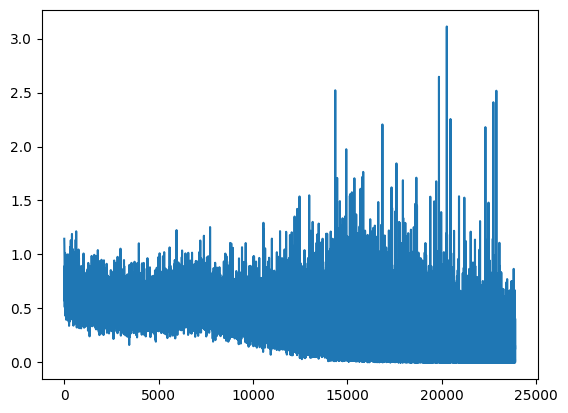

In [35]:
plt.plot(train_losses)

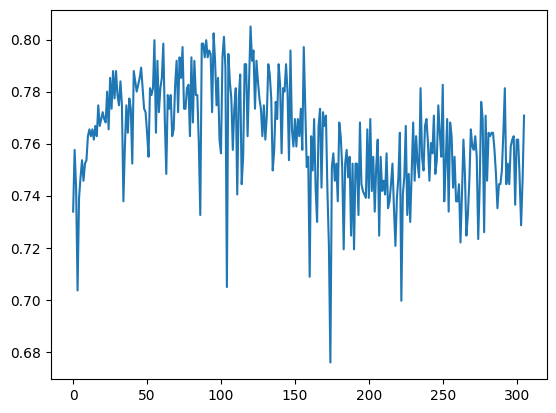

In [36]:
plt.plot(test_accuracy)

In [37]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 534/736 (0.7255)
{'acc_detail': tensor([0.9087, 0.5113, 0.7222], device='cuda:0'),
 'acc_unweighted': tensor(0.7141, device='cuda:0'),
 'acc_weighted': tensor(0.7255, device='cuda:0'),
 'f1s': tensor(0.7103, device='cuda:0'),
 'f1s_detail': tensor([0.7993, 0.5780, 0.7536], device='cuda:0'),
 'precision_detail': tensor([0.7134, 0.6647, 0.7879], device='cuda:0'),
 'recall_detail': tensor([0.9087, 0.5113, 0.7222], device='cuda:0'),
 'rocauc': tensor([0.9392, 0.8445, 0.8891], device='cuda:0'),
 'uar': tensor(0.7141, device='cuda:0'),
 'wap': tensor(0.7243, device='cuda:0')}


tensor([[239,  19,   5],
        [ 64, 113,  44],
        [ 32,  38, 182]], device='cuda:0')

In [38]:
best_epoch = 121
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 611/736 (0.8302)
{'acc_detail': tensor([0.8365, 0.8462, 0.8095], device='cuda:0'),
 'acc_unweighted': tensor(0.8307, device='cuda:0'),
 'acc_weighted': tensor(0.8302, device='cuda:0'),
 'f1s': tensor(0.8304, device='cuda:0'),
 'f1s_detail': tensor([0.8980, 0.7556, 0.8378], device='cuda:0'),
 'precision_detail': tensor([0.9692, 0.6825, 0.8681], device='cuda:0'),
 'recall_detail': tensor([0.8365, 0.8462, 0.8095], device='cuda:0'),
 'rocauc': tensor([0.9729, 0.8999, 0.9437], device='cuda:0'),
 'uar': tensor(0.8307, device='cuda:0'),
 'wap': tensor(0.8485, device='cuda:0')}


tensor([[220,  41,   2],
        [  5, 187,  29],
        [  2,  46, 204]], device='cuda:0')